Author: Rohan Krishna Balaji  <br>
Course : Simulation Science <br>
Date  : 25.06.2021  <br>
Project : ICTM Analysis, Master's Thesis at Fraunhofer IPT <br>
Email :  rohan.balaji@rwth-aachen.de <br>
Verion : 1.01 <br>

# Introduction
To obtain the complete data set which includes feature from both planning data used in CAM planning and machining data obtained from Parquet fles First is to convert the machining data in machine coordinate system to tool tip data in work space coordinate system through 'Forward Kinematic Transformations' on compensated data. Then each tool tip data is clusterd to the correspoding acqired data points. Then the obtained clasters are averged to generate combined dataset with both planning and machining data.
The dataset is filtered to remove the outliers

In [1]:
# Importing necessary libraries and general settings
import transformation
import compensation
import data_imports
import pandas as pd
import os
import glob
import math
import re
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from mpl_toolkits import mplot3d
import numpy as np
from scipy.signal import find_peaks

#pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=np.inf)

Path locations (folder location) for respective files

In [2]:
dir_paraquet = 'Manufacturing_Data/'
dir_planning = 'Planing_Data/'
dir_final_save  = 'Final_df/' 
dir_paraquet = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Manufacturing_Data/'
dir_planning = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Planning_Data/'
dir_compensation = 'D:/rohan/thesis/Projects/Machine_Learning/Data/Compensation_Data/'

In [3]:
print('Enter the Block number, example 1030')
block = input()
block = int(block)

Enter the Block number, example 1030
1030


In [4]:
## print('Enter the blade angle, muliples of 12')
angle = input()
angle = int(angle)

24


In [5]:
# Importing all the data
df_m,df_p,compensation_values_df = data_imports.data_out(block,angle,dir_paraquet,dir_planning,dir_compensation)

In [6]:
df_p.columns

Index(['Leading angle', 'Side tilt angle', 'Surface Contact point X',
       'Surface contact point Y', 'Surface contact point z',
       'Surface Orietation X', 'Surface Orietation Y', 'Surface Orietation Z',
       'Tool Tip Point X', 'Tool Tip Point Y', 'Tool Tip Point Z',
       'Tool Orientation X', 'Tool Orientation Y', 'Tool Orientation Z',
       'Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)'],
      dtype='object')

In [7]:
df_m.columns

Index(['time', 'MachineX', 'MachineY', 'MachineZ', 'MachineA', 'MachineC',
       'LoadSpindle', 'TransfX', 'TransfY', 'TransfZ', 'TransfI', 'TransfJ',
       'TransfK', 'executionDuration', 'previousExecutionDuration',
       'relativeTimetoPreviousCall program number', 'timeStamp', 'Tool Length',
       'Tool Radius', 'G54-X', 'G54-Y', 'G54-Z', 'G54-A', 'G54-C',
       'ProgNumber', 'Blade', 'Step', 'Level', 'Fx_mean', 'Fy_mean', 'Fz_mean',
       'Mz_mean', 'Fc_mean', 'Fa_mean', 'FcN_mean', 'Fres_mean', 'Fx_sigma',
       'Fy_sigma', 'Fz_sigma', 'Mz_sigma', 'Fc_sigma', 'Fa_sigma', 'FcN_sigma',
       'Fres_sigma', 'Fx_max', 'Fy_max', 'Fz_max', 'Mz_max', 'Fc_max',
       'Fa_max', 'FcN_max', 'Fres_max'],
      dtype='object')

In [8]:
# Just copying machine data points linear(x,y,x) and rotart (a,c) into arrays.
# These machine points (x,y,x,a,c) are transformed from machine coordinate system to workpiece coordinate system by forward tramsformation

x = df_m['MachineX'].copy(deep=True)
y = df_m['MachineY'].copy(deep=True)
z = df_m['MachineZ'].copy(deep=True)
a = np.radians(df_m['MachineA']).copy(deep=True)
c = np.radians(df_m['MachineC']).copy(deep=True)

size1 = x.shape[0]

# converting pandas series to numpy array
x = x.to_numpy()
y = y.to_numpy()
z = z.to_numpy()
a = a.to_numpy()
c = c.to_numpy()

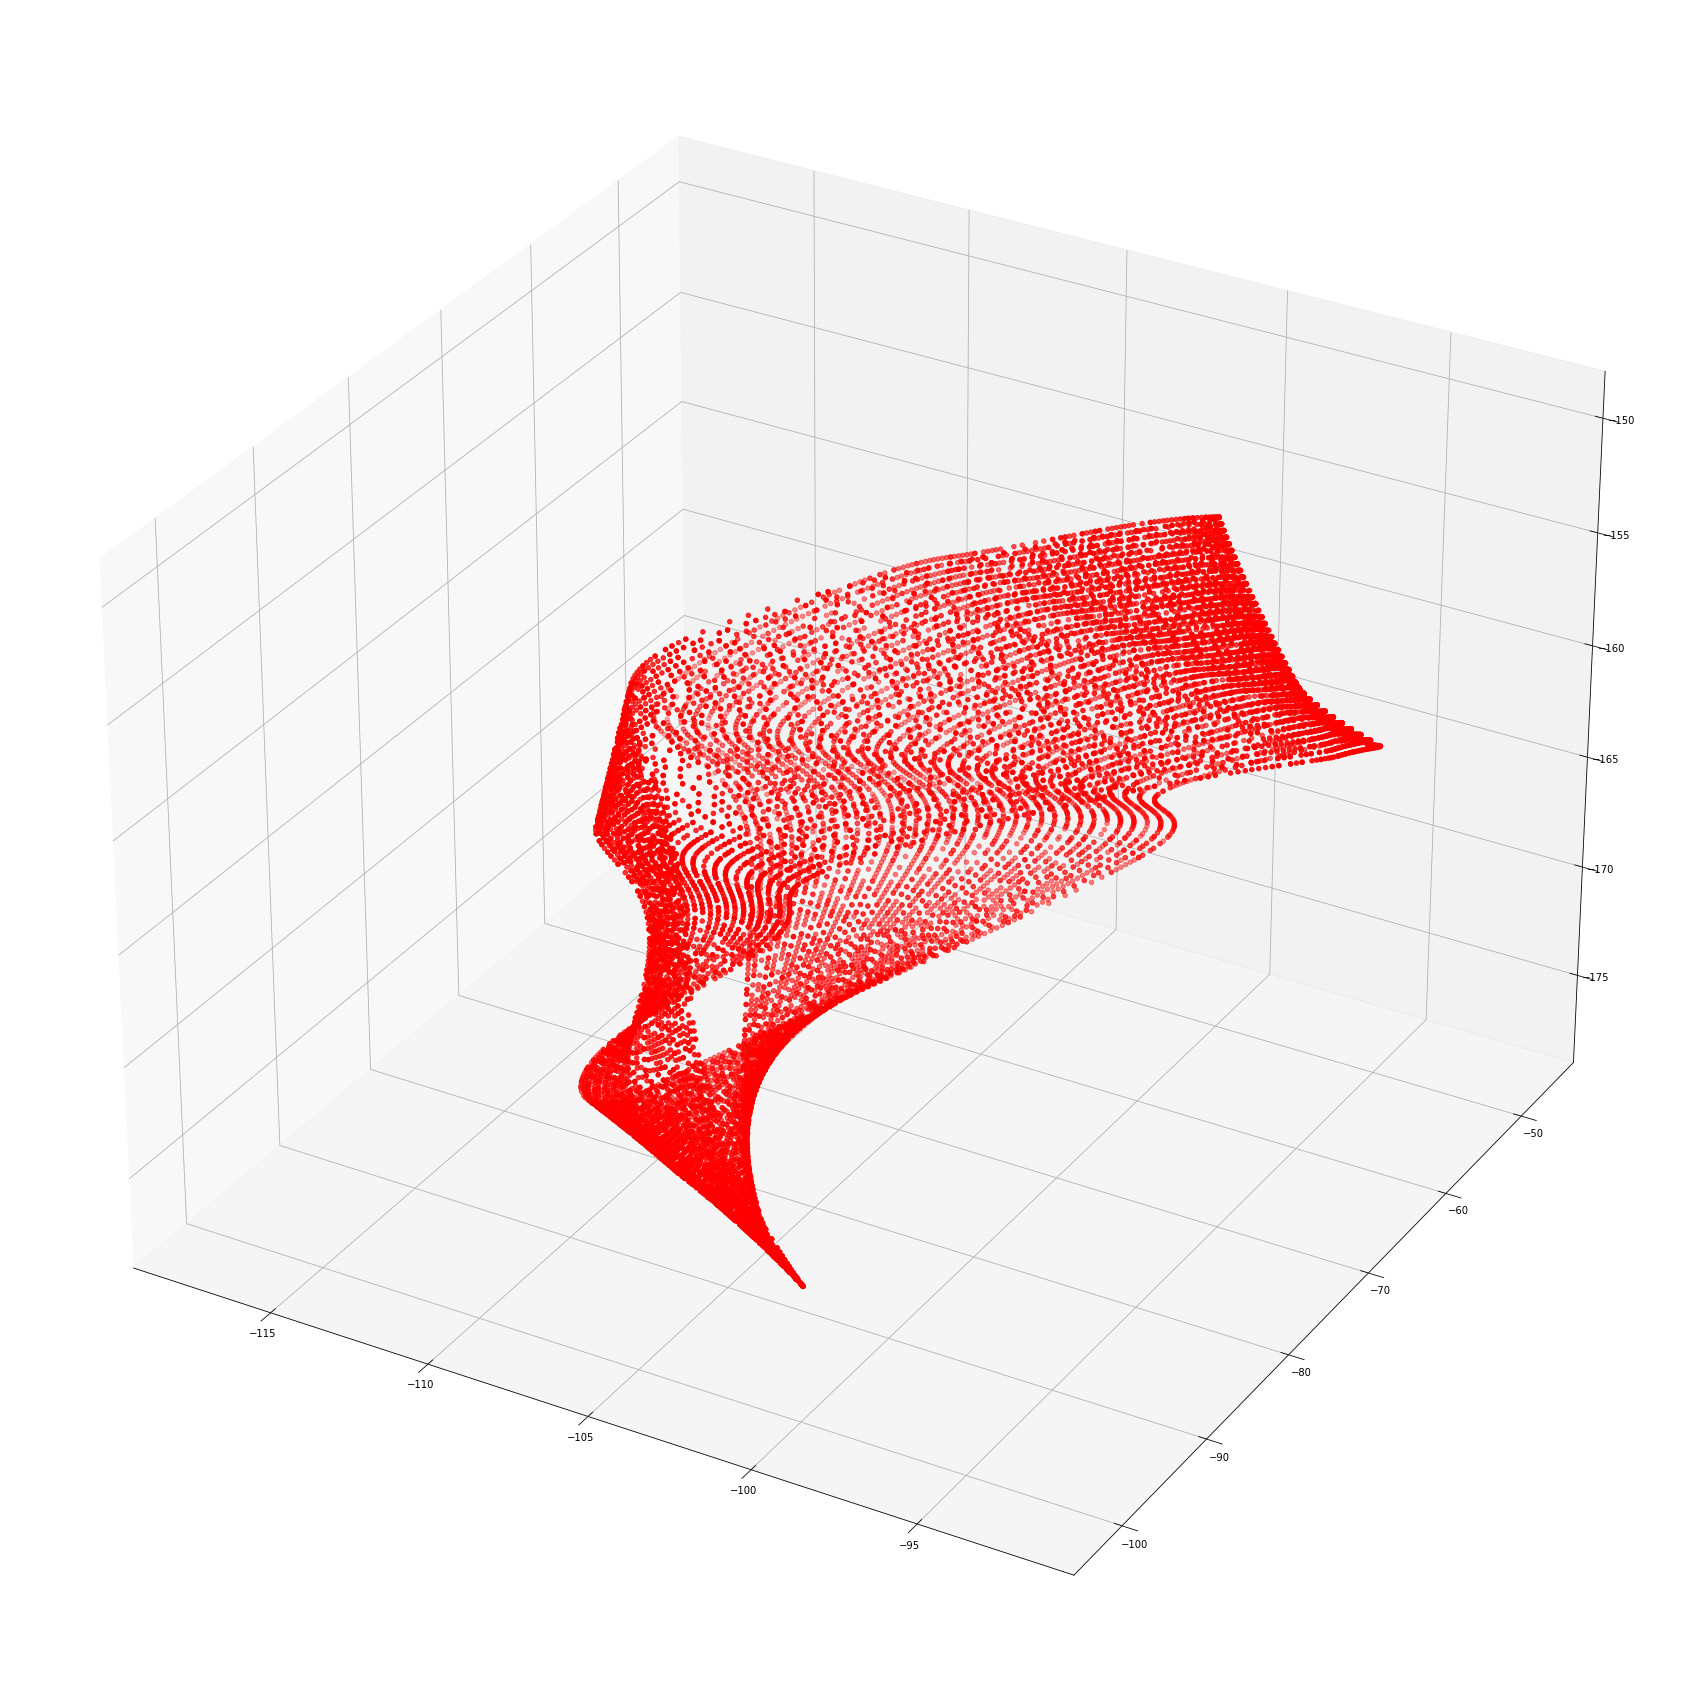

In [9]:
plt.figure(figsize=(30,45))
ax = plt.axes(projection='3d')
ax.scatter3D(x[10000:-10000], y[10000:-10000], z[10000:-10000], color = 'red',label = 'raw machine Data')
#ax.scatter3D(x, y, z, color = 'red',label = 'raw machine Data')

In [10]:
#compensation_values
compensation_values = compensation_values_df.to_numpy()

### Applying compensation on the Aquired Data
Based on the macine position compensation is applied to the machine datat, so that the errors are negated. This is implemented in the script compensation.py 
<img src="images/compensation.png">

In [11]:
# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3 = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1, deltaY1, deltaZ1,deltaI1,deltaJ1,deltaK1 = obj3.calculate(x,y,z)  
size3 = x.shape[0]

conc3 = np.concatenate((deltaX1.reshape(size3,1),deltaY1.reshape(size3,1),deltaZ1.reshape(size3,1),deltaI1.reshape(size3,1),deltaJ1.reshape(size3,1),deltaK1.reshape(size3,1)),axis=1)

# prininting the compensation error values
df_obj3 = pd.DataFrame(conc3, columns=['deltaX1','deltaY1','deltaZ1','deltaI1','deltaJ1','deltaK1'])
df_obj3.head(5)  
                          

deltaX1    deltaY1    deltaZ1  deltaI1  deltaJ1  deltaK1
0  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
1  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
2  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
3  26.443495 -11.914891 -10.001572      0.0      0.0      0.0
4  26.443495 -11.914891 -10.001572      0.0      0.0      0.0

In [12]:
x_compensated = x + deltaX1*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated = y + deltaY1*10**-3
z_compensated = z + deltaZ1*10**-3

conc4 = np.concatenate((x_compensated.reshape(size3,1),y_compensated.reshape(size3,1),z_compensated.reshape(size3,1)),axis=1)
df_obj4 = pd.DataFrame(conc4, columns=['x_compensated','y_compensated','z_compensated'])
df_obj4.head(5)

x_compensated  y_compensated  z_compensated
0    -158.991757    -118.613215     -79.440502
1    -158.991757    -118.613215     -79.440502
2    -158.991757    -118.613215     -79.440502
3    -158.991757    -118.613215     -79.440502
4    -158.991757    -118.613215     -79.440502

In [13]:
df_m['compensation_x'] = deltaX1*10**-3
df_m['compensation_y'] = deltaY1*10**-3
df_m['compensation_z'] = deltaZ1*10**-3
df_m.iloc[10000:10010]

time  MachineX  MachineY  MachineZ  MachineA  MachineC  \
86.739998  86.739998 -103.6344  -96.2363 -168.2141  -82.2746  349.7110   
86.754997  86.754997 -103.8011  -95.9182 -168.0601  -82.1433  349.5896   
86.760002  86.760002 -103.8011  -95.9182 -168.0601  -82.1433  349.5896   
86.769997  86.769997 -104.1187  -95.2880 -167.7545  -81.8854  349.3557   
86.777496  86.777496 -104.1187  -95.2880 -167.7545  -81.8854  349.3557   
86.784996  86.784996 -104.4358  -94.6181 -167.4276  -81.6143  349.1175   
86.792496  86.792496 -104.4358  -94.6181 -167.4276  -81.6143  349.1175   
86.800003  86.800003 -104.5901  -94.2771 -167.2603  -81.4773  348.9996   
86.807503  86.807503 -104.7412  -93.9328 -167.0906  -81.3395  348.8826   
86.815002  86.815002 -105.0218  -93.2545 -166.7528  -81.0700  348.6595   

           LoadSpindle    TransfX     TransfY    TransfZ   TransfI   TransfJ  \
86.739998     9.977273 -67.894437  206.197763  33.233967  0.468635 -0.304750   
86.754997     9.995455 -67.636912  206.286409  33.376734  0.341425 -0.286402   
86.760002     9.995455 -67.636912  206.286409  33.376734  0.341425 -0.286402   
86.769997     9.995455 -67.136724  206.457658  33.653001  0.120803 -0.162619   
86.777496     9.995455 -67.136724  206.457658  33.653001  0.120803 -0.162619   
86.784996    10.031818 -66.620311  206.632905  33.937973 -0.026158  0.061746   
86.792496    10.031818 -66.620311  206.632905  33.937973 -0.026158  0.061746   
86.800003    10.031818 -66.361738  206.720172  34.080315 -0.056564  0.194642   
86.807503    10.031818 -66.102898  206.807110  34.222738 -0.055341  0.330687   
86.815002    10.059091 -65.600959  206.974743  34.498297  0.032865  0.573080   

            TransfK  executionDuration  previousExecutionDuration  \
86.739998  0.829161           0.004907                   0.002006   
86.754997  0.895211           0.010303                   0.004907   
86.760002  0.895211           0.003265                   0.010303   
86.769997  0.979266           0.006443                   0.003265   
86.777496  0.979266           0.002092                   0.006443   
86.784996  0.997749           0.007135                   0.002092   
86.792496  0.997749           0.001943                   0.007135   
86.800003  0.979242           0.008211                   0.001943   
86.807503  0.942116           0.002962                   0.008211   
86.815002  0.818840           0.010271                   0.002962   

           relativeTimetoPreviousCall program number     timeStamp  \
86.739998                                   0.007052  6.375063e+10   
86.754997                                   0.007656  6.375063e+10   
86.760002                                   0.010422  6.375063e+10   
86.769997                                   0.006799  6.375063e+10   
86.777496                                   0.006882  6.375063e+10   
86.784996                                   0.006974  6.375063e+10   
86.792496                                   0.007172  6.375063e+10   
86.800003                                   0.006769  6.375063e+10   
86.807503                                   0.008301  6.375063e+10   
86.815002                                   0.006664  6.375063e+10   

           Tool Length  Tool Radius  G54-X  G54-Y    G54-Z  G54-A  G54-C  \
86.739998     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.754997     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.760002     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.769997     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.777496     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.784996     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.792496     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.800003     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.807503     226.4591          6.0    0.0    0.0 -510.483   24.0    0.0   
86.815002     226.4591       

### Forward Transformation:
Forward transformation is performed by applying rotational and transitional
transformations on the machine points and orientation in the machine coordi-
nate system.
There are two ways to interpret the transformations. Firstly, by pre-multiplication
of all the transformation matrices with respect to base coordinate system (i.e
Machine Coordinate System). Second method is the apply post- multiplica-
tion this can be understood as applying 'Relative Transformation'.
The notation used for machine data points obtained by paraqet fles are
x,y,z,a,c in machine coordinate system. The tool tip and orientations obtained
in workpiece coordinate system X,Y,Z,I,J,K. This is implemented in transformation.py script.

<img src="images/transformation.png">

In [14]:
obj = transformation.Transformation(size1,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS, tool_orientation_workpiece_CS = obj.forward(x_compensated,y_compensated,z_compensated,a,c)

X = tool_position_workpiece_CS[0,0,:]
Y = tool_position_workpiece_CS[1,0,:]
Z = tool_position_workpiece_CS[2,0,:]
print(X.shape)

I = tool_orientation_workpiece_CS[0,0,:]
J = tool_orientation_workpiece_CS[1,0,:]
K = tool_orientation_workpiece_CS[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values or equivalent values i.e (cos(a or c),sin(a or c))
machine_points_xyz, machine_direction_ac = obj.backward(X,Y,Z,I,J,K)

x_out = machine_points_xyz[0,0,:]
y_out = machine_points_xyz[1,0,:]
z_out = machine_points_xyz[2,0,:]

a_out = machine_direction_ac[0,0,:]
c_out = machine_direction_ac[1,0,:]

conc1 = np.concatenate((x.reshape(size1,1),x_out.reshape(size1,1),y.reshape(size1,1),y_out.reshape(size1,1),z.reshape(size1,1),z_out.reshape(size1,1),a.reshape(size1,1),a_out.reshape(size1,1),c.reshape(size1,1),c_out.reshape(size1,1)),axis=1)

df_obj1 = pd.DataFrame(conc1, columns=['x','x_out','y','y_out','z','z_out','a','a_out','c','c_out'])

df_obj1.iloc[10000:10005]


(38515,)


x       x_out        y       y_out         z       z_out  \
10000 -103.6344 -172.242721 -96.2363 -104.129142 -168.2141 -226.326953   
10001 -103.8011 -172.359884 -95.9182 -103.952439 -168.0601 -226.214510   
10002 -103.8011 -172.359884 -95.9182 -103.952439 -168.0601 -226.214510   
10003 -104.1187 -172.583005 -95.2880 -103.600141 -167.7545 -225.985993   
10004 -104.1187 -172.583005 -95.2880 -103.600141 -167.7545 -225.985993   

              a     a_out         c     c_out  
10000 -1.435963 -1.435963  6.103608 -0.598456  
10001 -1.433671 -1.433671  6.101490 -0.600575  
10002 -1.433671 -1.433671  6.101490 -0.600575  
10003 -1.429170 -1.429170  6.097407 -0.604657  
10004 -1.429170 -1.429170  6.097407 -0.604657

In [15]:
conc11 = np.concatenate((x.reshape(size1,1),y.reshape(size1,1),z.reshape(size1,1),a.reshape(size1,1),c.reshape(size1,1),X.reshape(size1,1),Y.reshape(size1,1),Z.reshape(size1,1),I.reshape(size1,1),J.reshape(size1,1),K.reshape(size1,1)),axis=1)
dfout11 = pd.DataFrame(conc11, columns=['x','y','z','a','c','X','Y','Z','I','J','K'])
dfout11.head(10)


x         y        z         a         c          X           Y  \
0 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
1 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
2 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
3 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
4 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
5 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
6 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
7 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
8 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   
9 -159.0182 -118.6013 -79.4305 -1.313123  5.933905  62.410659  293.421642   

           Z         I         J         K  
0  99.941964  0.671874  0.695447  0.254831  
1  99.941964  0.671874  0.695447  0.254831  
2  99.941964  0.671874  0.695447  0.254831  
3  99.941964  0.671874  0.695447  0.254831  
4  99.941964  0.671874  0.695447  0.254831  
5  99.941964  0.671874  0.695447  0.254831  
6  99.941964  0.671874  0.695447  0.254831  
7  99.941964  0.671874  0.695447  0.254831  
8  99.941964  0.671874  0.695447  0.254831  
9  99.941964  0.671874  0.695447  0.254831

In [16]:
# example
n = 15000
distance1 = (((df_p['Tool Tip Point X']-X[n])**2+(df_p['Tool Tip Point Y']-Y[n])**2+(df_p['Tool Tip Point Z']-Z[n])**2)**(1/2))
distance1.min()

0.1040247762824539

In [17]:
tool_tip_X = df_p['Tool Tip Point X'].to_numpy()
tool_tip_Y = df_p['Tool Tip Point Y'].to_numpy()
tool_tip_Z = df_p['Tool Tip Point Z'].to_numpy()
X_inv=tool_tip_X
Y_inv=tool_tip_Y
Z_inv=tool_tip_Z

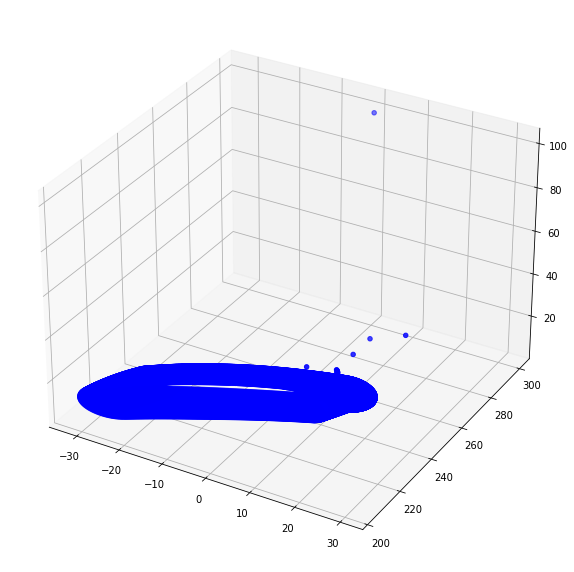

In [18]:
plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.scatter3D(X_inv, Y_inv, Z_inv, color = 'blue',label = 'raw Planning Data')

In [19]:
# Plotting the result obtained during the study
def subplotter(low,high,X,Y,Z,X_inv,Y_inv,Z_inv):
    
    range = np.arange(low,high)
    fig,axs = plt.subplots(3,figsize=(10,15))

    axs[0].plot(range,X[range],label = 'X acquired', color='blue')
    axs[0].plot(range,X_inv[range],label = 'X planning', color='red')
    axs[0].legend() 
    axs[0].set_xlabel('row index (dimension less)')
    axs[0].set_ylabel('X in mm')
    #axs[0].set_title('X data comparison')   
    
    axs[1].plot(range,Y[range], label = 'Y acquired', color='blue')
    axs[1].plot(range,Y_inv[range], label = 'Y planning', color='red') 
    axs[1].legend()
    axs[1].set_xlabel('row index (dimension less)')
    axs[1].set_ylabel('Y in mm')
   # axs[1].set_title('Y data comparison')   
    

    axs[2].plot(range,Z[range], label = 'Z acquired', color='blue')
    axs[2].plot(range,Z_inv[range] , label = 'Z planning', color='red')
    axs[2].legend()
    axs[2].set_xlabel('row index (dimension less)')
    axs[2].set_ylabel('Z in mm')
    #axs[2].set_title('Z data comparison')   
    
    
    fig.canvas.draw()
    fig.canvas.flush_events()


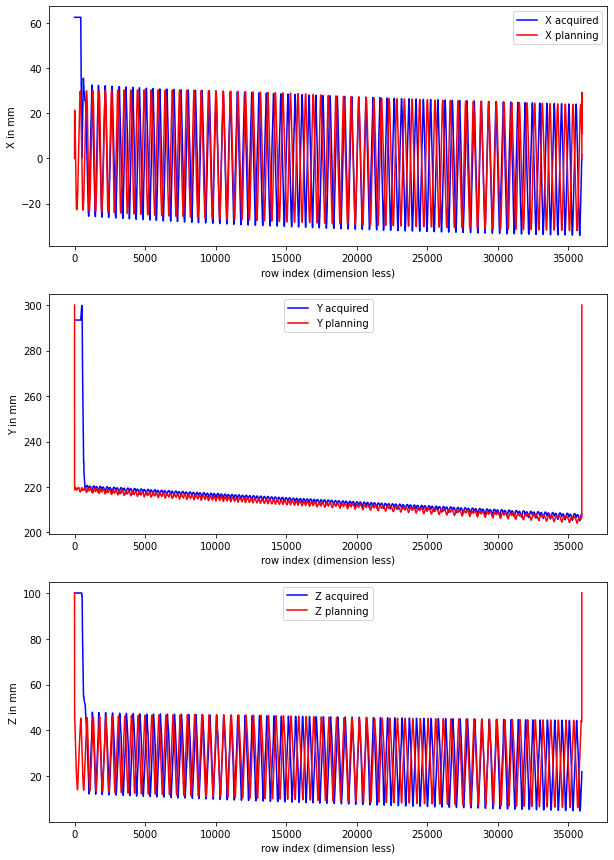

In [20]:
subplotter(0,df_p.shape[0],X,Y,Z,X_inv,Y_inv,Z_inv)

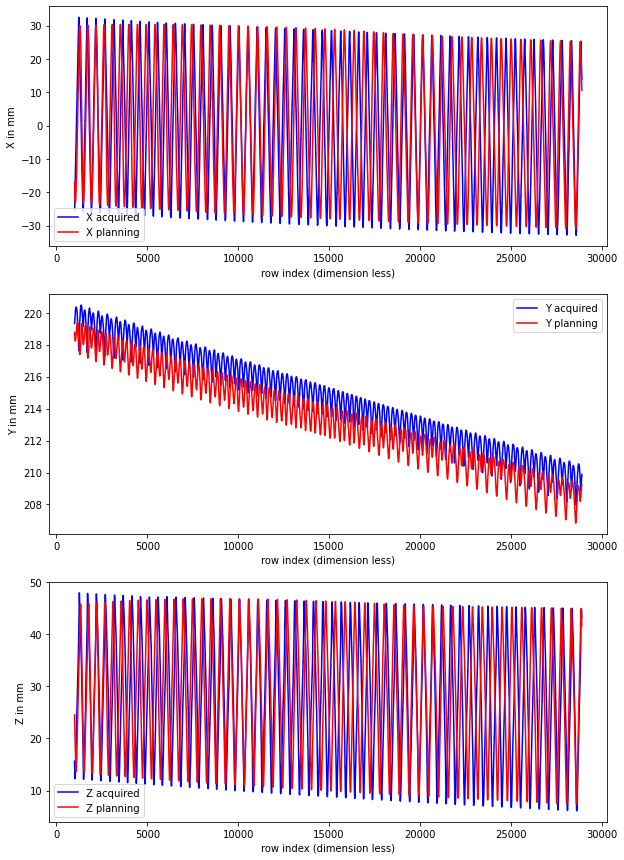

In [21]:
subplotter(1000,28900,X,Y,Z,X_inv,Y_inv,Z_inv)

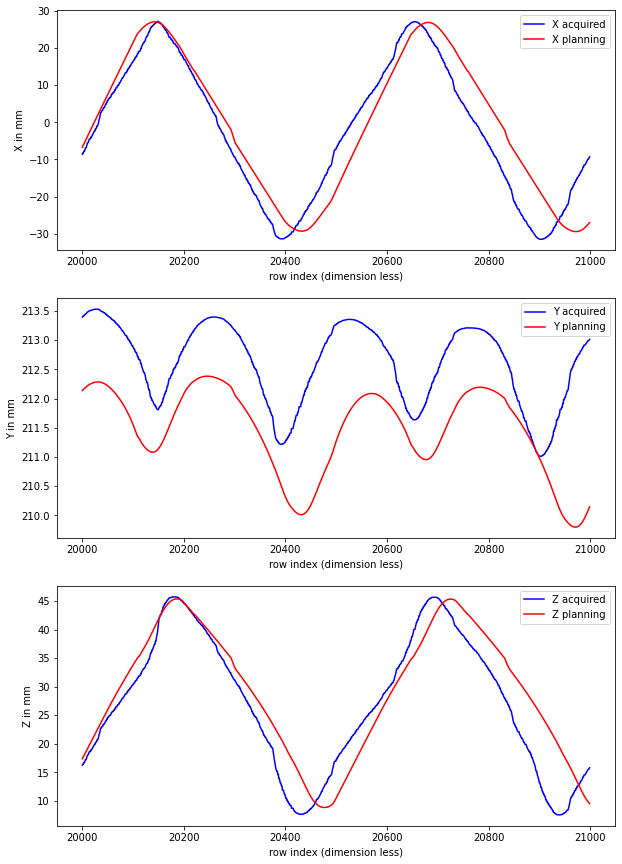

In [22]:
subplotter(20000,21000,X,Y,Z,X_inv,Y_inv,Z_inv)

In [23]:
"""
range1 = np.arange(1000,34900)
X = X[range1]
Y = Y[range1]
Z = Z[range1]

tool_tip_X = tool_tip_X[range1]
tool_tip_Y = tool_tip_Y[range1]
tool_tip_Z = tool_tip_Z[range1]
 
X_inv = tool_tip_X
Y_inv = tool_tip_Y
Z_inv = tool_tip_Z
"""

'\nrange1 = np.arange(1000,34900)\nX = X[range1]\nY = Y[range1]\nZ = Z[range1]\n\ntool_tip_X = tool_tip_X[range1]\ntool_tip_Y = tool_tip_Y[range1]\ntool_tip_Z = tool_tip_Z[range1]\n \nX_inv = tool_tip_X\nY_inv = tool_tip_Y\nZ_inv = tool_tip_Z\n'

In [71]:
def shiftt(df_m, df_p, compensation_values_df):
    x_final = df_m['MachineX']                 # using machine data from newly created combined dataset
    y_final = df_m['MachineY']
    z_final = df_m['MachineZ']
    a_final = df_m['MachineA']
    c_final = df_m['MachineC']

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype =  np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype =  np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = df_p['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = df_p['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = df_p['Tool Tip Point Z'].to_numpy()

    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final

    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    #Shifting the data 
    div = 15
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff = np.mean(Y_final[i*chunck_len:(i+1)*chunck_len]) - np.mean(Y_inv_final[i*chunck_len:(i+1)*chunck_len])
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - diff
        
        else:
            diff = np.mean(Y_final[i*chunck_len:length]) - np.mean(Y_inv_final[i*chunck_len:length])
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - diff

        
    return X_final,Y_final,Z_final



In [76]:
X_final,Y_final,Z_final = shiftt(df_m, df_p, compensation_values_df)

In [77]:
df_p['Tool Tip Point X'] = X_final
df_p['Tool Tip Point Y'] = Y_final
df_p['Tool Tip Point Z'] = Z_final

ValueError: Length of values (38515) does not match length of index (35961)

### Finding the closest points
Here the distances are calculated, for each aquired data point, forward transformation was performed above, and now for each of those poits the disace for all planning points are calculated. Partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, we may match up with far way points, which were causing lots of outliers.the position closest the iterator is considered, since the far away values are thus avoided from matching. store both position and the value in two separate lists

In [43]:
# Here the distances are calculated, for each aquired data point, forward transformation was performed above,
# and now for each of those poits the disace for all planning points are calculated.
lst1 = []
lst2 = []

dist  = np.zeros(len(tool_tip_X))
print('Enter the tolerance number value, example 3 mm')
#tol = input()
tol = 0.3
count = 0 
k = 5

for i in np.arange(len(X)):   # 47917
    
    dist = (((tool_tip_X-X[i])**2+(tool_tip_Y-Y[i])**2+(tool_tip_Z-Z[i])**2)**(1/2))
    
    # partition the data into 5 chuncks and find the closest distance points in those chucks, if we use full set at once, 
    # we may match up with far way points, which were causing lots of outliers
    
    pos = np.argpartition(dist, k)
    pos = pos[:k]
    min_val = dist[pos]
    #print(pos,min_val)
    
    # the position closest the iterator is considered, since the far away values are thus avoided from matching
    pos = pos[np.argmin(abs(pos - i))]
    min_val = dist[pos]
    
    #print(i,pos,min_val)
    # store both position and the value in two separate lists
    if(abs(min_val<=float(tol))): 
        lst1.append(pos)
        lst2.append(min_val)
        count = count+1
        print(i,pos,min_val,count)
    else:
        lst1.append(np.nan)
        lst2.append(np.nan)
   

Enter the tolerance number value, example 3 mm
6529 3967 0.2786958134337053 1
6532 3973 0.28254282347825715 2
6533 3975 0.2763197580942586 3
6954 4842 0.29813548998590944 4
6955 4843 0.29591032668271955 5
6960 4847 0.29936311221731104 6
6961 4847 0.29936311221731104 7
6962 4848 0.29893998438022557 8
6963 4848 0.29893998438022557 9
6986 4865 0.28504181972710585 10
6987 4865 0.28504181972710585 11
6988 4867 0.2872345423817337 12
6989 4868 0.29043463164609196 13
6990 4869 0.29344066456384865 14
6991 4870 0.29718235602536647 15
6992 4870 0.29718235602536647 16
7041 4431 0.28372201956528265 17
7043 4434 0.2634279277729427 18
7044 4437 0.2633808176471826 19
7045 4438 0.2038205240411721 20
7046 4441 0.19575815108184766 21
7047 4443 0.22939640602072833 22
7048 4445 0.23308584316536715 23
7049 4449 0.2076519789870712 24
7050 4449 0.2076519789870712 25
7051 4451 0.22322890301545611 26
7052 4454 0.22863670798742486 27
7053 4454 0.22863670798742486 28
7054 4456 0.23036642364546406 29
7055 4458 0.2

8896 6290 0.19724102784439168 287
8897 6291 0.19436092140856037 288
8898 6292 0.19134642657561127 289
8899 6292 0.19134642657561127 290
8900 6294 0.18917586390938929 291
8901 6296 0.18292901634788677 292
8902 6296 0.18292901634788677 293
8903 6298 0.17661001817073593 294
8904 6298 0.17661001817073593 295
8905 6299 0.18372135993205876 296
8906 6300 0.1801967353672598 297
8907 6301 0.1769467435344077 298
8908 6301 0.1769467435344077 299
8909 6302 0.17364856238056484 300
8910 6303 0.170619226532238 301
8911 6304 0.1833915186449952 302
8912 6304 0.1833915186449952 303
8913 6306 0.17690327145530252 304
8914 6306 0.17690327145530252 305
8915 6307 0.1736583305895465 306
8916 6307 0.1736583305895465 307
8917 6309 0.18878039685215167 308
8918 6309 0.18878039685215167 309
8919 6311 0.1823743764170769 310
8920 6312 0.17924923530211026 311
8924 6825 0.29685099531193715 312
8925 6826 0.2942499720789936 313
8926 6827 0.29797147129821994 314
8927 6828 0.2951287387699701 315
8928 6829 0.29237661668958

9994 7385 0.2731012438350728 592
9995 7386 0.28243258109932123 593
9996 7386 0.28243258109932123 594
9997 7387 0.2929372527302113 595
10017 6900 0.13549689778288607 596
10018 6900 0.13549689778288607 597
10019 6903 0.1265330234004982 598
10020 6903 0.1265330234004982 599
10021 6906 0.2443791768047942 600
10022 6906 0.2443791768047942 601
10023 6907 0.24458940071752647 602
10062 6464 0.27452861085346447 603
10063 6464 0.27452861085346447 604
10065 6469 0.236914398435842 605
10066 6469 0.236914398435842 606
10067 6471 0.2231854466070827 607
10068 6974 0.25208335989991915 608
10069 6474 0.1882724116733508 609
10070 6977 0.22153817041208726 610
10071 6477 0.19773651272145867 611
10072 6477 0.19773651272145867 612
10073 6980 0.2111149854442009 613
10074 6982 0.25341694867512626 614
10075 6983 0.2415436192577193 615
10076 6983 0.2415436192577193 616
10191 7091 0.29398358721012713 617
10192 7091 0.29398358721012713 618
10194 7093 0.2818006591476158 619
10195 7094 0.28252977051508754 620
10196

11078 8000 0.2759590375669511 942
11079 7491 0.2188617136341117 943
11080 8003 0.2243040817697421 944
11081 8006 0.2291656453511179 945
11082 8006 0.2291656453511179 946
11083 8007 0.22741966142654294 947
11084 8008 0.25056389328203976 948
11085 8009 0.28705416154464747 949
11086 8009 0.28705416154464747 950
11190 8112 0.292024668849063 951
11193 8115 0.23612957857556266 952
11194 8115 0.23612957857556266 953
11197 8117 0.2857626477452279 954
11198 8117 0.2857626477452279 955
11201 8120 0.28503950231108877 956
11202 8120 0.28503950231108877 957
11205 8125 0.2591909380586149 958
11206 8125 0.2591909380586149 959
11207 8126 0.25138273911388054 960
11208 8126 0.25138273911388054 961
11209 8129 0.28334761817863596 962
11210 8130 0.26121240869569823 963
11211 8130 0.26121240869569823 964
11212 8132 0.2822209651335919 965
11213 8132 0.2822209651335919 966
11214 8135 0.2663709762782963 967
11215 8135 0.2663709762782963 968
11216 8136 0.2724041106424297 969
11217 8136 0.2724041106424297 970
11

12086 9032 0.2746545509548133 1332
12087 9033 0.2326848503554578 1333
12088 9033 0.2326848503554578 1334
12089 9034 0.21315926779435168 1335
12090 9035 0.21410744520435912 1336
12091 9035 0.21410744520435912 1337
12192 9130 0.19994518877617756 1338
12199 9139 0.21924247385100193 1339
12200 9140 0.23787746261401194 1340
12201 9140 0.23787746261401194 1341
12204 9142 0.2405807251929104 1342
12207 9145 0.26050792984052035 1343
12208 9145 0.26050792984052035 1344
12209 9146 0.250134478605731 1345
12210 9146 0.250134478605731 1346
12213 9151 0.25517572157920926 1347
12214 9151 0.25517572157920926 1348
12215 9152 0.2577801850002127 1349
12216 8640 0.23233104594073664 1350
12217 9155 0.2760099971494775 1351
12218 9156 0.26348787975977767 1352
12219 9156 0.26348787975977767 1353
12220 9157 0.2726703265351068 1354
12221 9157 0.2726703265351068 1355
12222 9160 0.27323148256185426 1356
12223 9160 0.27323148256185426 1357
12224 8649 0.2662885902299856 1358
12225 8649 0.2662885902299856 1359
12226 

13042 9973 0.29626270968613594 1742
13050 9982 0.23868496191678176 1743
13051 9982 0.23868496191678176 1744
13052 9985 0.25980870005834983 1745
13053 9986 0.1714249851044354 1746
13054 9986 0.1714249851044354 1747
13055 9988 0.22186609765102305 1748
13056 9988 0.22186609765102305 1749
13113 10068 0.28084103416620626 1750
13114 10070 0.2966217008986019 1751
13115 10070 0.2966217008986019 1752
13116 10071 0.2472075090069749 1753
13117 10072 0.23227983332387422 1754
13118 10073 0.25128034611115785 1755
13119 10074 0.23147592173688122 1756
13120 10074 0.23147592173688122 1757
13121 10075 0.2537302625039018 1758
13122 10075 0.2537302625039018 1759
13169 10136 0.2903650035431111 1760
13174 10141 0.27379019359646845 1761
13175 10141 0.27379019359646845 1762
13179 10146 0.2556300013936454 1763
13180 10146 0.2556300013936454 1764
13184 10151 0.23669411847049143 1765
13185 10152 0.20626499284257238 1766
13186 10152 0.20626499284257238 1767
13187 10154 0.29565996449034454 1768
13188 10154 0.29565

13992 11478 0.267281374633182 2145
13993 11478 0.267281374633182 2146
13994 11480 0.2539728980800283 2147
13995 11480 0.2539728980800283 2148
13996 11481 0.2515969117681878 2149
13997 11482 0.24980231406797945 2150
13998 11483 0.24813637970386346 2151
13999 11484 0.24661029517915625 2152
14000 11484 0.24661029517915625 2153
14001 11485 0.24511434973286622 2154
14002 11486 0.2446178179888936 2155
14003 11486 0.2446178179888936 2156
14004 11488 0.24427807329249795 2157
14005 11489 0.24463744707707033 2158
14006 11489 0.24463744707707033 2159
14007 11490 0.25330407280726913 2160
14008 11491 0.255562625090105 2161
14009 11491 0.255562625090105 2162
14010 11492 0.25801049300237183 2163
14011 11492 0.25801049300237183 2164
14012 11493 0.26132617952447007 2165
14013 11494 0.2653624103438907 2166
14014 11495 0.2837316480106154 2167
14015 11496 0.28897658424397044 2168
14016 11496 0.28897658424397044 2169
14017 11497 0.29516455177470474 2170
14018 11497 0.29516455177470474 2171
14028 11503 0.29

14978 11973 0.278455848161827 2516
14979 11975 0.28208379270024064 2517
14980 11975 0.28208379270024064 2518
14981 11976 0.19715837558083393 2519
14982 11976 0.19715837558083393 2520
14983 11978 0.185900391615438 2521
14984 11978 0.185900391615438 2522
14985 11979 0.1805895545889029 2523
14986 11979 0.1805895545889029 2524
14987 11981 0.1644599057162293 2525
14988 11981 0.1644599057162293 2526
14989 11982 0.16063543940607516 2527
14990 11983 0.15695749741712559 2528
14991 11983 0.15695749741712559 2529
14992 11983 0.15695749741712559 2530
14993 11985 0.15863707361096982 2531
14994 11985 0.15863707361096982 2532
14995 11987 0.15612055714241393 2533
14996 11987 0.15612055714241393 2534
14997 11989 0.15503800435960016 2535
14998 11989 0.15503800435960016 2536
14999 11991 0.17757531409978378 2537
15000 11991 0.17757531409978378 2538
15001 11992 0.179059390775035 2539
15002 11992 0.179059390775035 2540
15003 11993 0.1808973572221725 2541
15004 11994 0.1830516959377835 2542
15005 11996 0.217

15981 13031 0.22126016571101995 2878
15982 13032 0.23204666591902975 2879
15983 13032 0.23204666591902975 2880
15984 13033 0.23243799139546967 2881
15985 13034 0.23293222558477217 2882
15986 13035 0.23384572559887312 2883
15987 13035 0.23384572559887312 2884
15988 13036 0.23499469662534356 2885
15989 13037 0.25883667644715064 2886
15990 13038 0.261479189487219 2887
15991 13039 0.2642334137898683 2888
15992 13040 0.267392971418315 2889
15993 13040 0.267392971418315 2890
15994 13041 0.27088672101879563 2891
15995 13041 0.27088672101879563 2892
15996 13042 0.2073800024701422 2893
15997 13044 0.19946272060334855 2894
15998 13044 0.19946272060334855 2895
15999 13046 0.18411863634168416 2896
16000 13046 0.18411863634168416 2897
16001 13048 0.1819368482002536 2898
16002 13048 0.1819368482002536 2899
16003 13048 0.1819368482002536 2900
16004 13049 0.18113433101123755 2901
16005 13050 0.18139559215694417 2902
16006 13051 0.18672017346373876 2903
16007 13052 0.18874857316946117 2904
16008 13052 

16980 14104 0.23883227685403233 3233
16981 14105 0.2409562363985674 3234
16982 14105 0.2409562363985674 3235
16983 14107 0.25810768081577984 3236
16984 14107 0.25810768081577984 3237
16985 14109 0.2671713573866205 3238
16986 14109 0.2671713573866205 3239
16987 14110 0.2719747162357571 3240
16988 14111 0.29612904311007193 3241
16991 14115 0.2772692479191251 3242
16992 14118 0.2824704667208612 3243
16993 14121 0.2863733984494955 3244
16994 14123 0.2961769509341435 3245
17087 14202 0.2576613701195235 3246
17088 14202 0.2576613701195235 3247
17089 14203 0.18431744425982766 3248
17130 14287 0.24508457104576692 3249
17131 14287 0.24508457104576692 3250
17132 14288 0.20214893632010453 3251
17133 14289 0.19489627765522857 3252
17134 14289 0.19489627765522857 3253
17135 14290 0.24673153886304922 3254
17136 14290 0.24673153886304922 3255
17137 14291 0.2587387081155836 3256
17138 14291 0.2587387081155836 3257
17139 14292 0.29397767543374775 3258
17140 14292 0.29397767543374775 3259
17219 14386 0.

18150 15891 0.27478955379843184 3518
18151 15358 0.16300406309913812 3519
18152 15360 0.2585433287537482 3520
18264 14932 0.2831606890228639 3521
18265 14932 0.2831606890228639 3522
18266 14933 0.22051951132544345 3523
18267 14935 0.15284376370141192 3524
18268 14935 0.15284376370141192 3525
18269 14937 0.2564243892082225 3526
18270 14939 0.15376605333687554 3527
18271 14939 0.15376605333687554 3528
18272 14942 0.23512309402555268 3529
18273 14946 0.251301868924919 3530
18274 14948 0.17065120577892598 3531
18275 14952 0.18731600834295378 3532
18276 14956 0.23277775613722146 3533
18277 14958 0.16329633112674144 3534
18278 14960 0.28661454851257917 3535
18279 14961 0.23151786099904223 3536
18280 14962 0.1905035850824389 3537
18281 14963 0.17320694250178673 3538
18282 14963 0.17320694250178673 3539
18283 14964 0.1859878805517614 3540
18284 14966 0.23513228636167594 3541
18285 14967 0.1979662004510142 3542
18286 14968 0.1841218268872745 3543
18287 14969 0.1983625149829454 3544
18288 14971 

19307 16032 0.22763766102266225 3803
19308 16032 0.22763766102266225 3804
19309 16034 0.18633631075896964 3805
19310 16035 0.1943445318777887 3806
19311 16037 0.23055982114363613 3807
19312 16038 0.20163102321919146 3808
19313 16039 0.19707313461449835 3809
19314 16040 0.2188143459707789 3810
19315 16040 0.2188143459707789 3811
19316 16042 0.23758520198423677 3812
19317 16044 0.20792262434170813 3813
19318 16044 0.20792262434170813 3814
19319 16045 0.22855215569953205 3815
19320 16047 0.23085326571941728 3816
19321 16047 0.23085326571941728 3817
19322 16048 0.22184542532201168 3818
19323 16048 0.22184542532201168 3819
19324 16050 0.2352465294172431 3820
19325 16050 0.2352465294172431 3821
19326 16053 0.22628210064751927 3822
19327 16054 0.22618492091794914 3823
19328 16055 0.23934837560408348 3824
19329 16057 0.25807412719418477 3825
19330 16059 0.23505638803460757 3826
19331 16059 0.23505638803460757 3827
19332 16059 0.23505638803460757 3828
19333 16063 0.24998017874428674 3829
19334 

20466 17269 0.23873474504634695 4150
20467 17270 0.23073352919267914 4151
20468 17271 0.2264727805784167 4152
20469 17272 0.2246690277261109 4153
20470 17273 0.22468452841945796 4154
20471 17275 0.24246016714942278 4155
20472 17275 0.24246016714942278 4156
20473 17277 0.2572912022236273 4157
20474 17278 0.2659321755981405 4158
20475 17279 0.2998385576617143 4159
20476 17279 0.24319579616374926 4160
20477 17280 0.23416301038227158 4161
20478 17282 0.2193506230971069 4162
20479 17282 0.2193506230971069 4163
20480 17282 0.2193506230971069 4164
20481 17284 0.2073541225162338 4165
20482 17284 0.2073541225162338 4166
20483 17286 0.20830555116965424 4167
20484 17288 0.22896166573115287 4168
20485 17288 0.22896166573115287 4169
20486 17290 0.24297720198773745 4170
20487 17290 0.24297720198773745 4171
20488 17291 0.25119002973758114 4172
20489 17291 0.25119002973758114 4173
20490 17292 0.26002151018632436 4174
20491 17293 0.2949192941493929 4175
20492 17295 0.20780511655251344 4176
20493 17298 

21516 18389 0.2993276031659482 4499
21521 18393 0.2508817237507415 4500
21522 18394 0.25218237549115397 4501
21523 18394 0.25218237549115397 4502
21524 18396 0.2569193575622327 4503
21525 18396 0.2569193575622327 4504
21526 18398 0.26661726863448393 4505
21527 18398 0.26661726863448393 4506
21528 18399 0.2731525494121072 4507
21529 18400 0.27983628798386956 4508
21530 18401 0.28704646367127645 4509
21641 19580 0.25078303641041 4510
21642 19580 0.25078303641041 4511
21643 19581 0.18616500157383536 4512
21644 19583 0.19333675406522915 4513
21645 19584 0.11312655982996295 4514
21646 19588 0.21390850029433006 4515
21647 19588 0.21390850029433006 4516
21648 20128 0.23136224172402808 4517
21649 20132 0.2457010339823262 4518
21650 20137 0.29949774609358787 4519
21665 20705 0.29911520512563095 4520
21666 20705 0.29911520512563095 4521
21667 20706 0.26542488998601704 4522
21668 20706 0.26542488998601704 4523
21669 20173 0.19874347910877838 4524
21670 20173 0.19874347910877838 4525
21671 20173 0

22654 21205 0.2142501804450947 4841
22655 20667 0.2233009035507626 4842
22656 21208 0.212411951366685 4843
22657 21210 0.22053978722350331 4844
22658 21212 0.2285457527309266 4845
22661 21217 0.2794232539791312 4846
22662 21217 0.2794232539791312 4847
22663 21219 0.2565400392543914 4848
22664 21219 0.2565400392543914 4849
22667 21226 0.29342517659579576 4850
22668 21226 0.29342517659579576 4851
22677 21779 0.2998314871506954 4852
22678 21241 0.23048533146481523 4853
22679 21241 0.23048533146481523 4854
22680 21243 0.2037355593427503 4855
22681 21245 0.1777830397809094 4856
22682 21245 0.1777830397809094 4857
22683 21787 0.2885102180315712 4858
22684 21787 0.2885102180315712 4859
22685 21249 0.1262458471308569 4860
22686 21254 0.24475515427856662 4861
22687 21254 0.24475515427856662 4862
22688 21254 0.24475515427856662 4863
22689 21256 0.21931153393733402 4864
22690 21256 0.21931153393733402 4865
22691 21258 0.19543626941502462 4866
22692 21258 0.19543626941502462 4867
22693 21260 0.232

23719 22328 0.26530831882541306 5187
23720 22330 0.2421153476799492 5188
23721 22330 0.2421153476799492 5189
23722 22332 0.21816933418599102 5190
23723 22332 0.21816933418599102 5191
23724 22332 0.21816933418599102 5192
23725 22334 0.1931095833862417 5193
23726 22336 0.16883534813300968 5194
23727 22336 0.16883534813300968 5195
23728 22338 0.14693364413946458 5196
23729 22338 0.14693364413946458 5197
23730 22340 0.17309145264064027 5198
23731 22340 0.17309145264064027 5199
23732 22343 0.188824483516932 5200
23733 22345 0.27516635602002704 5201
23734 22346 0.20214943290115087 5202
23735 22348 0.2868166461067191 5203
23736 22348 0.2868166461067191 5204
23737 22349 0.2241828715325562 5205
23738 22350 0.18774891137386981 5206
23739 22352 0.25441398403005505 5207
23740 22352 0.25441398403005505 5208
23741 22352 0.25441398403005505 5209
23742 22353 0.2243535636525154 5210
23745 22357 0.2928227976226113 5211
23746 22358 0.28681420517338435 5212
23747 22358 0.28681420517338435 5213
23835 20838

24773 23439 0.2462148116874239 5542
24774 23439 0.2462148116874239 5543
24775 23442 0.2922953656866747 5544
24776 23442 0.2922953656866747 5545
24777 23443 0.28712089098619187 5546
24778 23443 0.28712089098619187 5547
24779 23443 0.28712089098619187 5548
24860 21919 0.25917643477434643 5549
24861 21920 0.23240708950960323 5550
24862 21922 0.287672906364873 5551
24863 21922 0.287672906364873 5552
24864 21923 0.2489267374047152 5553
24865 21923 0.2489267374047152 5554
24866 21924 0.22968857072420534 5555
24867 21924 0.22968857072420534 5556
24868 21927 0.2590853814180346 5557
24869 21928 0.24382133806859405 5558
24870 21929 0.23255890578863272 5559
24871 21929 0.23255890578863272 5560
24872 21932 0.2549304104242432 5561
24873 21932 0.2549304104242432 5562
24874 21934 0.2397917424245384 5563
24875 21934 0.2397917424245384 5564
24876 21935 0.25854776729110757 5565
24877 21935 0.25854776729110757 5566
24878 21937 0.2553348162001459 5567
24879 21938 0.24496371800663494 5568
24880 21939 0.257

25772 24486 0.2642708667515632 5917
25773 24488 0.25489368771606496 5918
25774 24488 0.25489368771606496 5919
25775 24490 0.24491994344219106 5920
25776 24490 0.24491994344219106 5921
25777 24492 0.2340726432247135 5922
25778 24494 0.22276866423449299 5923
25779 24498 0.2016941199724224 5924
25780 24501 0.29030227026901945 5925
25781 24504 0.1925540763077946 5926
25782 24507 0.19347179543292922 5927
25783 24510 0.1952280162797574 5928
25784 24510 0.1952280162797574 5929
25785 24512 0.22669419302673094 5930
25786 24512 0.22669419302673094 5931
25787 24514 0.2237692388271727 5932
25788 24514 0.2237692388271727 5933
25789 24514 0.2237692388271727 5934
25790 24516 0.20569308845250586 5935
25791 24517 0.22347866844545677 5936
25792 24517 0.22347866844545677 5937
25793 24519 0.21994179687945373 5938
25794 24519 0.21994179687945373 5939
25798 24523 0.2760663724634997 5940
25799 24523 0.2760663724634997 5941
25800 24525 0.25719016289982266 5942
25801 24525 0.25719016289982266 5943
25802 24526 

26752 24971 0.29256500593389734 6364
26753 24973 0.2671604426112904 6365
26754 24973 0.2671604426112904 6366
26755 24976 0.2543360790860593 6367
26756 24976 0.2543360790860593 6368
26757 24978 0.24888188286575283 6369
26758 24980 0.20768519590533197 6370
26759 24981 0.17684409759670933 6371
26760 24983 0.28144702840859925 6372
26761 24984 0.19543813950097766 6373
26762 24985 0.14760155248711337 6374
26763 24987 0.19786132032361692 6375
26764 24989 0.2579883804738577 6376
26765 24990 0.18101084930646688 6377
26766 24992 0.24529394914729147 6378
26767 24992 0.24529394914729147 6379
26768 24995 0.23352785840932 6380
26769 24995 0.23352785840932 6381
26770 24998 0.23203375695301906 6382
26771 24998 0.23203375695301906 6383
26772 25542 0.28920782620971774 6384
26773 25544 0.29264927257782586 6385
26774 25545 0.29457821766485753 6386
26775 25548 0.28244478638112164 6387
26776 25550 0.2715815232051759 6388
26777 25552 0.26434091574858204 6389
26778 25552 0.26434091574858204 6390
26783 25559 0

27163 23793 0.2805009988377942 6615
27164 23793 0.22641648216773816 6616
27165 23793 0.22641648216773816 6617
27166 23795 0.21864711853355748 6618
27167 23795 0.21864711853355748 6619
27168 23797 0.21277080211372967 6620
27169 23799 0.20510829684902973 6621
27170 23799 0.20510829684902973 6622
27171 23800 0.20548719242249583 6623
27172 23801 0.20601055164023835 6624
27173 23802 0.2070441998314932 6625
27174 23803 0.21528260693656076 6626
27175 23803 0.21528260693656076 6627
27176 23804 0.21822265441299654 6628
27177 23805 0.22160626963893953 6629
27178 23806 0.2252491740449176 6630
27179 23806 0.2252491740449176 6631
27180 23807 0.22913330099754037 6632
27181 23809 0.2543727591279469 6633
27182 23809 0.2543727591279469 6634
27183 23810 0.2598498635214438 6635
27184 23811 0.2657430452583295 6636
27185 23811 0.2657430452583295 6637
27186 23812 0.27154487038512815 6638
27187 23813 0.29846419997722995 6639
27255 24959 0.2916852850299027 6640
27256 24959 0.2916852850299027 6641
27257 24960 

27620 24283 0.23422411308123453 6842
27621 24285 0.2209956346985773 6843
27622 24285 0.2209956346985773 6844
27623 24287 0.22539323241854553 6845
27624 24287 0.22539323241854553 6846
27625 24289 0.2559523053089407 6847
27626 24289 0.2559523053089407 6848
27627 24290 0.2688844593412315 6849
27628 24291 0.2835983045950423 6850
27629 24292 0.29944419593412575 6851
27630 24293 0.2230801189394996 6852
27631 24293 0.2230801189394996 6853
27632 24294 0.21798313898113178 6854
27633 24295 0.21556109533156315 6855
27634 24295 0.21556109533156315 6856
27635 24296 0.21588628082845002 6857
27636 24297 0.22706507249224986 6858
27637 24297 0.22706507249224986 6859
27638 24299 0.24499249210151988 6860
27639 24301 0.26910469773796486 6861
27641 24303 0.23328484897224383 6862
27642 24303 0.23328484897224383 6863
27643 24304 0.22683002174693043 6864
27644 24304 0.22683002174693043 6865
27645 24306 0.21781006067748315 6866
27646 24306 0.21781006067748315 6867
27647 24308 0.22265933165600124 6868
27648 243

27996 24675 0.1831561093964041 7085
27997 24678 0.2654443343370364 7086
27998 24678 0.2654443343370364 7087
27999 24679 0.2174552029275936 7088
28000 24680 0.19952656601384966 7089
28001 24681 0.17317233668956622 7090
28002 24683 0.29015221456850665 7091
28003 24684 0.24086934866859175 7092
28004 24685 0.20122225084207204 7093
28005 24687 0.17366052779601737 7094
28006 24687 0.17366052779601737 7095
28007 24689 0.2719611918981967 7096
28008 24690 0.2277239617870016 7097
28009 24690 0.2277239617870016 7098
28010 24691 0.19439479952772995 7099
28011 24692 0.18526149052761187 7100
28012 24693 0.17672715718233117 7101
28013 24695 0.2650056199579954 7102
28014 24696 0.22397422810151082 7103
28015 24697 0.19352170101186772 7104
28016 24698 0.18541885632340893 7105
28017 24699 0.17823373686206148 7106
28018 24701 0.2667347279831782 7107
28019 24701 0.2667347279831782 7108
28020 24702 0.2262048442223956 7109
28021 24703 0.19546422201681296 7110
28022 24704 0.1872323657722215 7111
28023 24704 0

28445 25691 0.2191847937500746 7317
28448 25694 0.25652191055197565 7318
28449 25695 0.2265752417651535 7319
28450 25696 0.21984663799119458 7320
28451 25696 0.21984663799119458 7321
28452 25698 0.29072997486572877 7322
28453 25700 0.22826376678503557 7323
28454 25700 0.22826376678503557 7324
28457 25704 0.24843896230653909 7325
28458 25704 0.24843896230653909 7326
28459 25706 0.29729550367275814 7327
28460 25706 0.29729550367275814 7328
28461 25707 0.26233649274447 7329
28464 25710 0.2650888800166511 7330
28465 25710 0.2650888800166511 7331
28466 25710 0.2650888800166511 7332
28467 25711 0.2590986792332837 7333
28468 25712 0.2665181500732719 7334
28469 25713 0.2909688840852771 7335
28470 25714 0.27211371284653546 7336
28471 25715 0.2741618764505757 7337
28472 25175 0.2667681913524859 7338
28473 25718 0.29368866874865907 7339
28474 25719 0.2824217640851222 7340
28475 25180 0.24492805057471878 7341
28476 25180 0.24492805057471878 7342
28477 25181 0.18109625859364623 7343
28478 25184 0.2

28876 27232 0.16368605228570043 7546
28877 27232 0.16368605228570043 7547
28878 27234 0.26493434224974466 7548
28879 27234 0.26493434224974466 7549
28880 27778 0.2969722253126325 7550
28881 27779 0.29726780497898914 7551
28882 27237 0.11353751712265378 7552
28883 27237 0.11353751712265378 7553
28884 27239 0.2772780779515675 7554
28885 27241 0.1345388041727568 7555
28886 27241 0.1345388041727568 7556
28887 27241 0.1345388041727568 7557
28888 27242 0.12308176832070176 7558
28889 27242 0.12308176832070176 7559
28890 27245 0.21971657903370648 7560
28891 27245 0.21971657903370648 7561
28892 27245 0.21971657903370648 7562
28893 27247 0.14844142637326194 7563
28894 27247 0.14844142637326194 7564
28895 27250 0.25084511136566967 7565
28896 27250 0.25084511136566967 7566
28897 27252 0.1785144811742047 7567
28898 27252 0.1785144811742047 7568
28899 27252 0.1785144811742047 7569
28900 27253 0.1706865994951778 7570
28901 27255 0.27969456300609064 7571
28902 27258 0.19869871214050122 7572
28903 2725

29330 27151 0.1364095460351471 7787
29331 27151 0.1364095460351471 7788
29332 27151 0.1364095460351471 7789
29333 27698 0.23942965716262046 7790
29334 27698 0.23942965716262046 7791
29335 27701 0.22455747453581815 7792
29336 27701 0.22455747453581815 7793
29337 27704 0.21779496601010787 7794
29338 27704 0.21779496601010787 7795
29339 27706 0.24074774550176128 7796
29340 27708 0.2907874380567983 7797
29341 27709 0.22819575967892294 7798
29342 27711 0.2737132903635681 7799
29343 27711 0.2737132903635681 7800
29344 27714 0.2651062544147933 7801
29345 27714 0.2651062544147933 7802
29346 27717 0.2652818527021198 7803
29347 27717 0.2652818527021198 7804
29349 27720 0.26916724083351906 7805
29350 27722 0.24859414031633298 7806
29351 27722 0.24859414031633298 7807
29379 28299 0.29770301374463354 7808
29380 28299 0.29770301374463354 7809
29381 28301 0.2934888573520585 7810
29382 28301 0.2934888573520585 7811
29383 28303 0.2905370882802052 7812
29384 28303 0.2905370882802052 7813
29385 28305 0.2

29734 25957 0.10968300803330232 8026
29735 25958 0.11473835062396366 8027
29736 25959 0.12068374061009303 8028
29737 26504 0.2972517612822857 8029
29738 26505 0.29257564600849606 8030
29739 26506 0.29198604249874377 8031
29740 26507 0.2915632450543616 8032
29741 26508 0.2914882635141884 8033
29742 26508 0.2914882635141884 8034
29743 26509 0.2915290400683034 8035
29744 26510 0.2970302646051999 8036
29745 26511 0.2981624368390357 8037
29746 26512 0.29945625665396214 8038
29747 26512 0.29945625665396214 8039
29759 26521 0.29760937880638516 8040
29760 26522 0.2939340366094763 8041
29761 26523 0.2900769216424315 8042
29762 26524 0.27823249142766543 8043
29763 26525 0.2753829577721349 8044
29764 26526 0.272387338673459 8045
29765 26526 0.272387338673459 8046
29766 26527 0.2698728815347189 8047
29767 26527 0.2698728815347189 8048
29768 26529 0.26357197109379527 8049
29769 26531 0.26055955238102196 8050
29770 26532 0.25921273342870343 8051
29771 26532 0.25921273342870343 8052
29772 26532 0.259

30203 27000 0.29067728981677377 8278
30204 27001 0.28629273763029306 8279
30205 27003 0.2886052525018952 8280
30206 27004 0.2938793486704028 8281
30207 27004 0.2938793486704028 8282
30213 27009 0.29529463916884885 8283
30214 27009 0.29529463916884885 8284
30215 27011 0.28644800553345395 8285
30216 27011 0.28644800553345395 8286
30217 27013 0.29074966344477415 8287
30218 27013 0.29074966344477415 8288
30228 27021 0.29420302159062384 8289
30229 27022 0.29380865992918204 8290
30230 27022 0.29380865992918204 8291
30231 27024 0.2972602796868183 8292
30232 27024 0.2972602796868183 8293
30236 26485 0.2836634938308383 8294
30237 26486 0.2996393699156975 8295
30238 26486 0.2996393699156975 8296
30243 26489 0.11705116637786545 8297
30244 26490 0.12340618543891295 8298
30245 26491 0.13101898884687335 8299
30246 26491 0.13101898884687335 8300
30247 26493 0.16985331708350948 8301
30248 26493 0.16985331708350948 8302
30249 26495 0.1910784455035817 8303
30250 26495 0.1910784455035817 8304
30251 26496

30543 27356 0.2063734393373608 8520
30544 27357 0.16220196982305382 8521
30545 27358 0.14649938722252054 8522
30546 27360 0.2275584007433375 8523
30547 27360 0.2275584007433375 8524
30548 27361 0.18035821532657811 8525
30549 27362 0.16420783387367127 8526
30550 27362 0.16420783387367127 8527
30551 27365 0.22234145781229342 8528
30552 27365 0.22234145781229342 8529
30553 27367 0.16510134365503207 8530
30554 27367 0.16510134365503207 8531
30555 27370 0.22120398016214102 8532
30556 27370 0.22120398016214102 8533
30559 27374 0.24733704099038692 8534
30560 27374 0.24733704099038692 8535
30561 27376 0.19140524682689944 8536
30562 27376 0.19140524682689944 8537
30563 27377 0.1831356298370924 8538
30564 27378 0.2019121790417731 8539
30565 27380 0.21146310179123842 8540
30566 27380 0.21146310179123842 8541
30567 27382 0.19084770100531231 8542
30568 27382 0.19084770100531231 8543
30569 27385 0.22013994173381088 8544
30570 27385 0.22013994173381088 8545
30571 27385 0.22013994173381088 8546
30572 

30968 29417 0.19487656451401955 8762
30969 29417 0.19487656451401955 8763
30970 29420 0.27882638787159225 8764
30971 29420 0.27882638787159225 8765
30972 29421 0.22869433394528035 8766
30973 29421 0.22869433394528035 8767
30974 29423 0.1935651401187752 8768
30975 29423 0.1935651401187752 8769
30976 29424 0.18068998546608495 8770
30977 29426 0.27764932452495666 8771
30978 29427 0.23763341925689702 8772
30979 29428 0.20979861575156483 8773
30980 29429 0.20315139408987026 8774
30981 29429 0.20315139408987026 8775
30982 29431 0.22572506306469056 8776
30983 29433 0.23683770892411096 8777
30984 29433 0.23683770892411096 8778
30985 29435 0.2258770391876219 8779
30986 29435 0.2258770391876219 8780
30987 28893 0.13827676060988292 8781
30988 29438 0.24585854045378985 8782
30989 29441 0.26708200448695135 8783
30990 29445 0.27259720835655626 8784
30991 28905 0.189392068336735 8785
30992 28909 0.2589521039306465 8786
30993 28910 0.20705837477459776 8787
30994 28911 0.16914362386681825 8788
30995 28

31366 28749 0.2884076188624359 9016
31367 28749 0.2884076188624359 9017
31368 28750 0.2799700534383741 9018
31369 28751 0.2823103622024231 9019
31370 28753 0.26591601933970854 9020
31371 28753 0.26591601933970854 9021
31372 28754 0.2577088719382093 9022
31373 28754 0.2577088719382093 9023
31374 28755 0.249431785519003 9024
31375 28755 0.249431785519003 9025
31376 28757 0.24886280452496132 9026
31377 28757 0.24886280452496132 9027
31378 28757 0.24886280452496132 9028
31379 28758 0.24104160365601285 9029
31380 28759 0.23341011584527663 9030
31381 28761 0.24040360755367074 9031
31382 28763 0.22751184996049295 9032
31387 29312 0.2963381348459208 9033
31388 29312 0.2963381348459208 9034
31389 29313 0.28713430117382455 9035
31390 29315 0.2686570839403763 9036
31391 29315 0.2686570839403763 9037
31392 29316 0.2736887587831129 9038
31393 29317 0.2657615047247782 9039
31394 29317 0.2657615047247782 9040
31395 29318 0.2577765514685742 9041
31396 29319 0.2505339823021789 9042
31397 29320 0.243622

31762 28097 0.17724299571098762 9279
31763 28099 0.23106634863341713 9280
31764 28099 0.23106634863341713 9281
31766 28102 0.29301617802587515 9282
31771 28105 0.15173967093733814 9283
31772 28105 0.15173967093733814 9284
31773 28107 0.16837389413523637 9285
31774 28107 0.16837389413523637 9286
31775 28108 0.1984944476908286 9287
31776 28109 0.2133680949869092 9288
31777 28110 0.22875684341029395 9289
31778 28110 0.22875684341029395 9290
31779 28112 0.2609554289331058 9291
31780 28112 0.2609554289331058 9292
31781 28113 0.16186661698118393 9293
31782 28113 0.16186661698118393 9294
31783 28115 0.1549190208368632 9295
31784 28116 0.15482284467612292 9296
31785 28118 0.16822486526894545 9297
31786 28118 0.16822486526894545 9298
31787 28119 0.17580951237275222 9299
31788 28119 0.17580951237275222 9300
31789 28121 0.1930896644016503 9301
31790 28122 0.2216535890127506 9302
31791 28123 0.23261168789182612 9303
31792 28124 0.24330425642137474 9304
31793 28125 0.25414009948255484 9305
31794 28

32105 29013 0.23541057489942693 9555
32106 29013 0.23541057489942693 9556
32107 29015 0.24692065934057067 9557
32108 29016 0.22347883903975854 9558
32109 29017 0.22109885862709627 9559
32110 29018 0.23988179746717297 9560
32111 29020 0.2407641243960674 9561
32112 29021 0.2311337107603274 9562
32113 29022 0.22580580921254034 9563
32114 29023 0.24072628313525862 9564
32115 29025 0.2509858430884089 9565
32116 29025 0.2509858430884089 9566
32117 29026 0.23199181928741316 9567
32118 29028 0.23881440755528324 9568
32119 29028 0.23881440755528324 9569
32120 29029 0.26466229075540665 9570
32121 29031 0.24073316962891628 9571
32122 29032 0.23314984675171882 9572
32123 29033 0.23588185265116476 9573
32124 29034 0.25321142229426374 9574
32125 29034 0.25321142229426374 9575
32126 29036 0.2548147555232444 9576
32127 29036 0.2548147555232444 9577
32128 29038 0.23704327372544057 9578
32129 29038 0.23704327372544057 9579
32130 29040 0.2633234617771243 9580
32131 29042 0.251314000716187 9581
32132 2904

32494 31036 0.26294984737064864 9813
32495 31036 0.26294984737064864 9814
32496 31037 0.21937742501321877 9815
32497 31037 0.21937742501321877 9816
32498 31039 0.28022600221390864 9817
32499 31040 0.2264186714329416 9818
32500 31041 0.2088009653790426 9819
32501 31041 0.2088009653790426 9820
32503 31044 0.2692697962310031 9821
32504 31044 0.2692697962310031 9822
32505 31045 0.21770493460518023 9823
32506 31048 0.2792944832993122 9824
32507 31048 0.2792944832993122 9825
32508 31049 0.24119249701845139 9826
32509 31049 0.24119249701845139 9827
32510 31050 0.22877856741116742 9828
32511 31051 0.21872015642065973 9829
32512 31051 0.21872015642065973 9830
32513 31053 0.2396403124735676 9831
32514 31056 0.23814663453639076 9832
32515 30519 0.2702280888775727 9833
32516 31062 0.25729065332920614 9834
32517 31068 0.2821176113185975 9835
32518 30530 0.21759164836860792 9836
32519 30531 0.16408462497938434 9837
32520 30532 0.13990025785508436 9838
32521 30535 0.2348480395807557 9839
32522 30535 

32870 29260 0.21712330470101357 10079
32871 29262 0.21559992654328902 10080
32872 29265 0.23914810696689115 10081
32873 29266 0.23915832171896897 10082
32874 29266 0.23915832171896897 10083
32878 29270 0.2665152318756556 10084
32879 29270 0.2665152318756556 10085
32886 29819 0.297254394485364 10086
32887 29819 0.297254394485364 10087
32888 29821 0.2860074853913252 10088
32889 29821 0.2860074853913252 10089
32890 29822 0.2803608183880152 10090
32891 29822 0.2803608183880152 10091
32892 29824 0.2860879098833081 10092
32893 29824 0.2860879098833081 10093
32894 29826 0.27419215856870816 10094
32895 29826 0.27419215856870816 10095
32896 29827 0.268302829362957 10096
32897 29828 0.283745916397345 10097
32898 29829 0.2778772860645033 10098
32899 29830 0.2720699804118679 10099
32900 29830 0.2720699804118679 10100
32901 29832 0.2602621511277275 10101
32902 29833 0.28028964350169444 10102
32903 29834 0.2750537533179759 10103
32904 29834 0.2750537533179759 10104
32905 29836 0.2646649946264228 101

33297 29720 0.20996781003185244 10360
33298 29722 0.22473340513512927 10361
33299 29722 0.22473340513512927 10362
33300 29724 0.271088121328631 10363
33301 29724 0.271088121328631 10364
33304 29726 0.20767761171816967 10365
33305 29728 0.19109269155757538 10366
33306 29728 0.19109269155757538 10367
33307 29730 0.20004368650229878 10368
33308 29730 0.20004368650229878 10369
33309 29731 0.21013971436659082 10370
33310 29731 0.21013971436659082 10371
33311 29732 0.240305380225406 10372
33312 29733 0.2581431406340516 10373
33313 29734 0.27692095163474695 10374
33314 29735 0.29660157744551835 10375
33315 29735 0.29660157744551835 10376
33316 29736 0.1913109261184841 10377
33317 29738 0.18968103562811464 10378
33318 29738 0.18968103562811464 10379
33319 29739 0.19348661584372795 10380
33320 29740 0.20000749882302687 10381
33321 29741 0.22193510409918432 10382
33322 29743 0.24770571687475668 10383
33323 29743 0.24770571687475668 10384
33324 29745 0.2763473944895248 10385
33325 29745 0.2174237

33618 30604 0.18712201313117105 10638
33619 30604 0.18712201313117105 10639
33620 30605 0.16241373049406937 10640
33621 30605 0.16241373049406937 10641
33622 30608 0.22525873148553177 10642
33623 30608 0.22525873148553177 10643
33624 30611 0.29878777928899586 10644
33625 30611 0.29878777928899586 10645
33626 30613 0.20515114660066125 10646
33627 30613 0.20515114660066125 10647
33628 30614 0.19376707053893588 10648
33629 30615 0.1945613469496176 10649
33630 30616 0.22278610782383224 10650
33631 30618 0.20868255642824277 10651
33632 30618 0.20868255642824277 10652
33633 30619 0.2028812994982314 10653
33634 30620 0.21269194380622233 10654
33635 30620 0.21269194380622233 10655
33636 30623 0.21520300263777373 10656
33637 30623 0.21520300263777373 10657
33638 30625 0.24275653961175728 10658
33639 30627 0.2396037574711846 10659
33640 30628 0.22311322695681413 10660
33641 30628 0.22311322695681413 10661
33642 30090 0.24464783078355853 10662
33643 30090 0.24464783078355853 10663
33644 30090 0.2

34005 32615 0.29744543675770774 10897
34006 32617 0.28998205592230547 10898
34007 32617 0.28998205592230547 10899
34008 32619 0.2839713824791675 10900
34021 32634 0.2971119807835988 10901
34022 32636 0.29169983854188786 10902
34023 32636 0.29169983854188786 10903
34024 32638 0.28599975109864656 10904
34025 32638 0.28599975109864656 10905
34026 32640 0.2793410479855167 10906
34027 32640 0.2793410479855167 10907
34028 32642 0.27207320146273883 10908
34029 32642 0.27207320146273883 10909
34030 32644 0.2647054220142138 10910
34031 32644 0.2647054220142138 10911
34032 32646 0.25809849142446273 10912
34033 32648 0.2532304019445765 10913
34037 32652 0.27168559045150376 10914
34039 32656 0.25183900204489923 10915
34040 32656 0.25183900204489923 10916
34041 32658 0.2721667303935516 10917
34042 32659 0.2525492287140872 10918
34043 32661 0.27017271595537207 10919
34046 32664 0.26846073777280677 10920
34047 32664 0.26846073777280677 10921
34048 32665 0.25229165627909655 10922
34049 32667 0.2795236

34394 30860 0.29432569722427515 11155
34395 30861 0.29634754662242374 11156
34396 30861 0.29634754662242374 11157
34397 30862 0.29813165468867747 11158
34398 30863 0.2998997582577559 11159
34412 30874 0.29606148513529545 11160
34413 30875 0.29200865776183527 11161
34414 30876 0.28792369330304424 11162
34415 30878 0.27923915390652276 11163
34416 30880 0.2633730322498288 11164
34417 30882 0.25447863459350206 11165
34418 30885 0.2384033190353356 11166
34419 30887 0.22888629721145237 11167
34420 30887 0.22888629721145237 11168
34421 30889 0.22205043945023556 11169
34422 30889 0.22205043945023556 11170
34423 30890 0.21719244319897732 11171
34424 30890 0.21719244319897732 11172
34425 30891 0.2123855948354944 11173
34426 30892 0.2073863365238088 11174
34427 30893 0.20213714812104946 11175
34428 30894 0.20630261530332308 11176
34429 30895 0.20147826638669789 11177
34430 30895 0.20147826638669789 11178
34431 30896 0.19648404521627005 11179
34432 30896 0.19648404521627005 11180
34433 30898 0.186

34733 31780 0.27740151811505204 11447
34734 31781 0.28984307853156194 11448
34735 31241 0.2614420559232064 11449
34736 31241 0.2614420559232064 11450
34737 31785 0.27926273543312125 11451
34738 31785 0.27926273543312125 11452
34739 31785 0.27926273543312125 11453
34740 31786 0.2819792133867969 11454
34741 31787 0.2952893171152387 11455
34742 31247 0.27443044493357216 11456
34743 31790 0.2966027713085406 11457
34744 31791 0.29800222867485704 11458
34849 31346 0.24198125516639324 11459
34850 31347 0.23960540951488776 11460
34851 31348 0.24109199254369107 11461
34852 31348 0.24109199254369107 11462
34853 31350 0.26615377782471616 11463
34854 31351 0.2795977977060629 11464
34855 31351 0.2795977977060629 11465
34858 31355 0.23015992401980426 11466
34859 31356 0.22898824974689597 11467
34860 31356 0.22898824974689597 11468
34861 31357 0.23155930283254286 11469
34862 31359 0.26000077051103665 11470
34863 31359 0.26000077051103665 11471
34864 31360 0.2748988549799053 11472
34865 31361 0.291453

35150 32752 0.2826519880214472 11682
35151 32752 0.2826519880214472 11683
35152 32754 0.2858333028940045 11684
35153 32754 0.2858333028940045 11685
35154 32214 0.25605700865395203 11686
35155 32215 0.19099125793201896 11687
35156 32216 0.13893657403927198 11688
35157 32219 0.23761143011571173 11689
35158 32219 0.23761143011571173 11690
35159 32220 0.1808994590082246 11691
35160 32220 0.1808994590082246 11692
35161 32221 0.14492575634217147 11693
35162 32223 0.25750507946749346 11694
35163 32224 0.2242352517313191 11695
35164 32224 0.2242352517313191 11696
35165 32226 0.16040494197454885 11697
35166 32227 0.2445240589863585 11698
35167 32228 0.19955349699359545 11699
35168 32229 0.18475353155131985 11700
35169 32231 0.28730143012233916 11701
35170 32232 0.23684401452483694 11702
35171 32232 0.23684401452483694 11703
35172 32233 0.20315626519349134 11704
35173 32233 0.20315626519349134 11705
35174 32234 0.1955534758826515 11706
35175 32235 0.20603021489800666 11707
35176 32237 0.23455853

35567 34262 0.297027683595167 11936
35568 34264 0.2934291189143858 11937
35569 34264 0.2934291189143858 11938
35570 34266 0.2900412932261898 11939
35571 34266 0.2900412932261898 11940
35572 34268 0.2869776730696332 11941
35573 34268 0.2869776730696332 11942
35574 34270 0.2846644758948335 11943
35575 34270 0.2846644758948335 11944
35576 34272 0.28326606843657165 11945
35586 34284 0.2890651241690501 11946
35587 34284 0.2890651241690501 11947
35589 34287 0.2914793073851818 11948
35590 34287 0.2914793073851818 11949
35591 34290 0.29228768548215217 11950
35592 34290 0.29228768548215217 11951
35593 34293 0.2910549908966358 11952
35594 34293 0.2910549908966358 11953
35595 34294 0.2970219029958829 11954
35596 34296 0.29290318971861173 11955
35597 34297 0.29899906086197603 11956
35598 34297 0.29899906086197603 11957
35599 34299 0.2997585172250427 11958
35600 34299 0.2997585172250427 11959
35602 34304 0.2971599071637859 11960
35603 34305 0.29765741554574576 11961
35604 33765 0.28450584056905426 

35961 31970 0.21669695891968294 12187
35967 32518 0.29839680813562813 12188
35968 32518 0.29839680813562813 12189
35969 32519 0.2932024112242288 12190
35970 32519 0.2932024112242288 12191
35971 32521 0.2907303141348399 12192
35972 32521 0.2907303141348399 12193
35973 32523 0.2794772991543137 12194
35974 32523 0.2794772991543137 12195
35975 32524 0.27354682086655874 12196
35976 32525 0.2802667615705392 12197
35977 32526 0.27435373739030655 12198
35978 32527 0.2682024248229141 12199
35979 32528 0.26208691521206995 12200
35980 32528 0.26208691521206995 12201
35981 32529 0.2557716161642787 12202
35982 32530 0.26658486113536917 12203
35983 32531 0.2605203120783977 12204
35984 32531 0.2605203120783977 12205
35985 32532 0.2542996460582946 12206
35986 32532 0.2542996460582946 12207
35987 32534 0.241842010244193 12208
35988 32534 0.241842010244193 12209
35989 32536 0.25166436301440526 12210
35990 32536 0.25166436301440526 12211
35991 32537 0.2461349539188841 12212
35992 32537 0.2461349539188841

36386 32974 0.2888630555661513 12434
36387 32974 0.2888630555661513 12435
36388 32975 0.2921520087695133 12436
36393 32980 0.27452883979249454 12437
36394 32980 0.27452883979249454 12438
36395 32981 0.2698520466829787 12439
36396 32982 0.27182299232157336 12440
36397 32983 0.2769935885403321 12441
36398 32983 0.2769935885403321 12442
36399 32985 0.2970935482169086 12443
36400 32985 0.2970935482169086 12444
36402 32987 0.2862993715729079 12445
36403 32987 0.2862993715729079 12446
36404 32989 0.27212313274320415 12447
36405 32989 0.27212313274320415 12448
36406 32991 0.2742303838168748 12449
36407 32991 0.2742303838168748 12450
36408 32992 0.2807049397027684 12451
36409 32993 0.2894741115794654 12452
36414 32997 0.29465967110689273 12453
36415 32997 0.29465967110689273 12454
36416 32998 0.29005319739751356 12455
36417 32998 0.29005319739751356 12456
36418 33000 0.2858856699407968 12457
36419 33000 0.2858856699407968 12458
36420 33002 0.2937804745004688 12459
36421 33002 0.293780474500468

36762 33372 0.11419366035756684 12706
36763 33372 0.11419366035756684 12707
36764 33374 0.2614800716124506 12708
36765 33375 0.20576890407723633 12709
36766 33376 0.15718452278219483 12710
36767 33377 0.1226164884719586 12711
36768 33379 0.2679737627048173 12712
36769 33380 0.24257444596920752 12713
36770 33381 0.19068343849284414 12714
36771 33381 0.19068343849284414 12715
36772 33383 0.11762511497398186 12716
36773 33383 0.11762511497398186 12717
36774 33385 0.26109417546997304 12718
36775 33385 0.26109417546997304 12719
36776 33386 0.23848907447693254 12720
36777 33388 0.1462574780156013 12721
36778 33388 0.1462574780156013 12722
36779 33389 0.11760495417697121 12723
36780 33391 0.26978929089108367 12724
36781 33392 0.24922889871723855 12725
36782 33393 0.2001086267706496 12726
36783 33394 0.15578866791588283 12727
36784 33394 0.15578866791588283 12728
36785 33397 0.28505461378427177 12729
36786 33397 0.28505461378427177 12730
36788 33402 0.14893649674883755 12731
36789 33406 0.2024

37186 34904 0.2861944114875437 12937
37187 34904 0.2861944114875437 12938
37188 34906 0.23460161326694232 12939
37189 34907 0.2280461307505571 12940
37190 34907 0.2280461307505571 12941
37191 34368 0.24688814428041908 12942
37192 34368 0.24688814428041908 12943
37193 34912 0.2582533235794766 12944
37194 34912 0.2582533235794766 12945
37195 34912 0.2582533235794766 12946
37196 34913 0.28127151160541725 12947
37197 34373 0.22606704112971607 12948
37198 34916 0.2802103877051141 12949
37199 34375 0.12712382626465318 12950
37200 34377 0.2758685203546911 12951
37201 34378 0.2097676785272205 12952
37202 34378 0.2097676785272205 12953
37203 34380 0.12069871476142287 12954
37204 34380 0.12069871476142287 12955
37205 34383 0.1995816147870995 12956
37206 34383 0.1995816147870995 12957
37207 34384 0.15629545060184427 12958
37208 34384 0.15629545060184427 12959
37209 34387 0.22351053885004857 12960
37210 34388 0.1965336737558452 12961
37211 34389 0.16836380799946374 12962
37212 34391 0.268698622422

37597 35312 0.2685904072128607 13186
37598 35855 0.2850342763134993 13187
37599 35855 0.2850342763134993 13188
37600 35858 0.28196494101730357 13189
37601 35860 0.28762746317744975 13190
37602 35860 0.28762746317744975 13191
37604 35863 0.2843111998984804 13192
37613 35881 0.28671193172304027 13193
37627 35902 0.296653486624499 13194
37628 35904 0.2818373779022622 13195
37629 35904 0.2818373779022622 13196
37630 35906 0.2665688579040818 13197
37631 35906 0.2665688579040818 13198
37636 35912 0.27790651020596513 13199
37637 35912 0.27790651020596513 13200
37642 35918 0.2680268176863841 13201
37649 35927 0.26141703650965825 13202
37650 35928 0.21181819370519545 13203
37651 35928 0.21181819370519545 13204
37653 35932 0.21703913592666355 13205
37654 35932 0.21703913592666355 13206
37655 35932 0.21703913592666355 13207
37656 35934 0.25001777312428985 13208
37657 35934 0.25001777312428985 13209
37658 35935 0.2435597037076529 13210
37659 35935 0.2435597037076529 13211
37662 35397 0.27543880100

38028 34149 0.21490651782918554 13430
38029 34151 0.20555904148310683 13431
38030 34151 0.20555904148310683 13432
38031 34151 0.20555904148310683 13433
38032 34152 0.20075331154158543 13434
38033 34153 0.19566760167690472 13435
38034 34154 0.19987775129985835 13436
38035 34155 0.19478470679781987 13437
38036 34155 0.19478470679781987 13438
38037 34156 0.18933302335386296 13439
38038 34156 0.18933302335386296 13440
38039 34158 0.17867403550692562 13441
38040 34158 0.17867403550692562 13442
38041 34159 0.1885370567683508 13443
38045 34706 0.2916715732208379 13444
38046 34707 0.28675152027957596 13445
38047 34708 0.2784835732756347 13446
38048 34708 0.2784835732756347 13447
38049 34709 0.2701965671346946 13448
38050 34709 0.2701965671346946 13449
38051 34710 0.2618073444178691 13450
38052 34711 0.25323838155200873 13451
38053 34712 0.25153064492056476 13452
38054 34713 0.24272367626983005 13453
38055 34714 0.23363296311980436 13454
38056 34714 0.23363296311980436 13455
38057 34715 0.22436

In [44]:
print(np.shape(lst1))

(38515,)


In [45]:
# Seeing all the unique clusers and number of points in it (Just for understanding)
(unique,count) = np.unique(lst1, return_counts=True)

df_freq = pd.DataFrame({'Unique Cluster Points':np.array(unique),'Count':np.array(count)})
df_freq = df_freq.dropna()
df_freq.iloc[:]

Unique Cluster Points  Count
0                    3967.0      1
1                    3973.0      1
2                    3975.0      1
3                    4431.0      1
4                    4434.0      1
...                     ...    ...
8937                35932.0      5
8938                35934.0      2
8939                35935.0      2
8940                35957.0      2
8941                35960.0    126

[8942 rows x 2 columns]

In [46]:

df_cluster = pd.DataFrame({'cluster index in planning data':np.array(lst1),'distance error':np.array(lst2)})
#df_cluster = df_cluster.dropna()
df_cluster.iloc[22000:22100]

cluster index in planning data  distance error
22000                         18919.0        0.253977
22001                         18919.0        0.253977
22002                         18919.0        0.253977
22003                         18920.0        0.259319
22004                         18921.0        0.282912
...                               ...             ...
22095                             NaN             NaN
22096                             NaN             NaN
22097                             NaN             NaN
22098                             NaN             NaN
22099                             NaN             NaN

[100 rows x 2 columns]

### Clustering:
For a given planning point, there are none or multiple matching acquried points, those are found in this section. For each planning datapoint, see whih index match with the stored index for minimum distance. Those can be considered as the cluster points and the corresponding distance. 

<img src="images/cluster.png">

In [47]:
# Clustering: for a given planning point, there are none or multiple matching acquried points, those are found in this section of code 
lst3 = []
tcp_val = []
# For each planning datapoint, see whih index match with the stored index for minimum distance.
# Those can be considered as the cluster points and the corresponding distance
for i in np.arange(len(tool_tip_Y)):     # each planning point
    
    matching = np.where(np.array(lst1)==i)    # see what all machine points matches
    tcp_val.append([lst2[index] for index in matching[0]])          # get the same minmum tcp error distance 
    lst3.append(matching[0])
    print(i,matching[0])
    

0 []
1 []
2 []
3 []
4 []
5 []
6 []
7 []
8 []
9 []
10 []
11 []
12 []
13 []
14 []
15 []
16 []
17 []
18 []
19 []
20 []
21 []
22 []
23 []
24 []
25 []
26 []
27 []
28 []
29 []
30 []
31 []
32 []
33 []
34 []
35 []
36 []
37 []
38 []
39 []
40 []
41 []
42 []
43 []
44 []
45 []
46 []
47 []
48 []
49 []
50 []
51 []
52 []
53 []
54 []
55 []
56 []
57 []
58 []
59 []
60 []
61 []
62 []
63 []
64 []
65 []
66 []
67 []
68 []
69 []
70 []
71 []
72 []
73 []
74 []
75 []
76 []
77 []
78 []
79 []
80 []
81 []
82 []
83 []
84 []
85 []
86 []
87 []
88 []
89 []
90 []
91 []
92 []
93 []
94 []
95 []
96 []
97 []
98 []
99 []
100 []
101 []
102 []
103 []
104 []
105 []
106 []
107 []
108 []
109 []
110 []
111 []
112 []
113 []
114 []
115 []
116 []
117 []
118 []
119 []
120 []
121 []
122 []
123 []
124 []
125 []
126 []
127 []
128 []
129 []
130 []
131 []
132 []
133 []
134 []
135 []
136 []
137 []
138 []
139 []
140 []
141 []
142 []
143 []
144 []
145 []
146 []
147 []
148 []
149 []
150 []
151 []
152 []
153 []
154 []
155 []
156 []
157 []
158 

1245 []
1246 []
1247 []
1248 []
1249 []
1250 []
1251 []
1252 []
1253 []
1254 []
1255 []
1256 []
1257 []
1258 []
1259 []
1260 []
1261 []
1262 []
1263 []
1264 []
1265 []
1266 []
1267 []
1268 []
1269 []
1270 []
1271 []
1272 []
1273 []
1274 []
1275 []
1276 []
1277 []
1278 []
1279 []
1280 []
1281 []
1282 []
1283 []
1284 []
1285 []
1286 []
1287 []
1288 []
1289 []
1290 []
1291 []
1292 []
1293 []
1294 []
1295 []
1296 []
1297 []
1298 []
1299 []
1300 []
1301 []
1302 []
1303 []
1304 []
1305 []
1306 []
1307 []
1308 []
1309 []
1310 []
1311 []
1312 []
1313 []
1314 []
1315 []
1316 []
1317 []
1318 []
1319 []
1320 []
1321 []
1322 []
1323 []
1324 []
1325 []
1326 []
1327 []
1328 []
1329 []
1330 []
1331 []
1332 []
1333 []
1334 []
1335 []
1336 []
1337 []
1338 []
1339 []
1340 []
1341 []
1342 []
1343 []
1344 []
1345 []
1346 []
1347 []
1348 []
1349 []
1350 []
1351 []
1352 []
1353 []
1354 []
1355 []
1356 []
1357 []
1358 []
1359 []
1360 []
1361 []
1362 []
1363 []
1364 []
1365 []
1366 []
1367 []
1368 []
1369 []


2315 []
2316 []
2317 []
2318 []
2319 []
2320 []
2321 []
2322 []
2323 []
2324 []
2325 []
2326 []
2327 []
2328 []
2329 []
2330 []
2331 []
2332 []
2333 []
2334 []
2335 []
2336 []
2337 []
2338 []
2339 []
2340 []
2341 []
2342 []
2343 []
2344 []
2345 []
2346 []
2347 []
2348 []
2349 []
2350 []
2351 []
2352 []
2353 []
2354 []
2355 []
2356 []
2357 []
2358 []
2359 []
2360 []
2361 []
2362 []
2363 []
2364 []
2365 []
2366 []
2367 []
2368 []
2369 []
2370 []
2371 []
2372 []
2373 []
2374 []
2375 []
2376 []
2377 []
2378 []
2379 []
2380 []
2381 []
2382 []
2383 []
2384 []
2385 []
2386 []
2387 []
2388 []
2389 []
2390 []
2391 []
2392 []
2393 []
2394 []
2395 []
2396 []
2397 []
2398 []
2399 []
2400 []
2401 []
2402 []
2403 []
2404 []
2405 []
2406 []
2407 []
2408 []
2409 []
2410 []
2411 []
2412 []
2413 []
2414 []
2415 []
2416 []
2417 []
2418 []
2419 []
2420 []
2421 []
2422 []
2423 []
2424 []
2425 []
2426 []
2427 []
2428 []
2429 []
2430 []
2431 []
2432 []
2433 []
2434 []
2435 []
2436 []
2437 []
2438 []
2439 []


3374 []
3375 []
3376 []
3377 []
3378 []
3379 []
3380 []
3381 []
3382 []
3383 []
3384 []
3385 []
3386 []
3387 []
3388 []
3389 []
3390 []
3391 []
3392 []
3393 []
3394 []
3395 []
3396 []
3397 []
3398 []
3399 []
3400 []
3401 []
3402 []
3403 []
3404 []
3405 []
3406 []
3407 []
3408 []
3409 []
3410 []
3411 []
3412 []
3413 []
3414 []
3415 []
3416 []
3417 []
3418 []
3419 []
3420 []
3421 []
3422 []
3423 []
3424 []
3425 []
3426 []
3427 []
3428 []
3429 []
3430 []
3431 []
3432 []
3433 []
3434 []
3435 []
3436 []
3437 []
3438 []
3439 []
3440 []
3441 []
3442 []
3443 []
3444 []
3445 []
3446 []
3447 []
3448 []
3449 []
3450 []
3451 []
3452 []
3453 []
3454 []
3455 []
3456 []
3457 []
3458 []
3459 []
3460 []
3461 []
3462 []
3463 []
3464 []
3465 []
3466 []
3467 []
3468 []
3469 []
3470 []
3471 []
3472 []
3473 []
3474 []
3475 []
3476 []
3477 []
3478 []
3479 []
3480 []
3481 []
3482 []
3483 []
3484 []
3485 []
3486 []
3487 []
3488 []
3489 []
3490 []
3491 []
3492 []
3493 []
3494 []
3495 []
3496 []
3497 []
3498 []


4451 [7051 7534]
4452 []
4453 []
4454 [7052 7053]
4455 []
4456 [7054 7537]
4457 []
4458 [7055 7056 7538 7539]
4459 []
4460 [7540 7541]
4461 []
4462 []
4463 [7057]
4464 []
4465 [7542 7543]
4466 []
4467 [7544 7545]
4468 []
4469 [7546]
4470 []
4471 [7547 7548]
4472 []
4473 []
4474 []
4475 [7549 7550]
4476 []
4477 [7551 7552]
4478 []
4479 [7553]
4480 []
4481 [7554 7555 7556]
4482 []
4483 []
4484 []
4485 []
4486 []
4487 []
4488 []
4489 []
4490 []
4491 []
4492 []
4493 []
4494 []
4495 []
4496 []
4497 []
4498 []
4499 []
4500 []
4501 []
4502 []
4503 []
4504 []
4505 []
4506 []
4507 []
4508 []
4509 []
4510 []
4511 []
4512 []
4513 []
4514 []
4515 []
4516 []
4517 []
4518 []
4519 []
4520 []
4521 []
4522 []
4523 []
4524 []
4525 []
4526 []
4527 []
4528 []
4529 []
4530 []
4531 []
4532 []
4533 []
4534 []
4535 []
4536 []
4537 []
4538 []
4539 []
4540 []
4541 []
4542 []
4543 []
4544 []
4545 []
4546 []
4547 []
4548 []
4549 []
4550 []
4551 []
4552 []
4553 []
4554 []
4555 []
4556 []
4557 []
4558 []
4559 []
45

5414 []
5415 []
5416 [8557 8558]
5417 []
5418 []
5419 []
5420 []
5421 [8560 8561]
5422 []
5423 [8562]
5424 []
5425 []
5426 []
5427 []
5428 []
5429 []
5430 [8567 8568]
5431 []
5432 [8569]
5433 []
5434 []
5435 []
5436 []
5437 [8571 8572 8573]
5438 []
5439 [8574]
5440 []
5441 [8575]
5442 []
5443 [8576]
5444 []
5445 []
5446 [8577 8578]
5447 []
5448 []
5449 []
5450 [8579 8580]
5451 []
5452 [8581]
5453 []
5454 [8582 8583 8584]
5455 []
5456 [8585]
5457 []
5458 []
5459 [8586]
5460 []
5461 [8587 8588]
5462 []
5463 [8589 8590]
5464 []
5465 [8591]
5466 []
5467 []
5468 [8592 8593]
5469 []
5470 [8594 8595]
5471 []
5472 [8596 8597]
5473 []
5474 []
5475 [8598 8599]
5476 []
5477 []
5478 []
5479 []
5480 []
5481 []
5482 []
5483 []
5484 []
5485 []
5486 []
5487 []
5488 []
5489 []
5490 []
5491 []
5492 []
5493 []
5494 []
5495 []
5496 []
5497 []
5498 []
5499 []
5500 []
5501 []
5502 []
5503 []
5504 []
5505 []
5506 []
5507 []
5508 []
5509 []
5510 []
5511 []
5512 []
5513 []
5514 []
5515 []
5516 []
5517 []
5518 

6367 []
6368 []
6369 []
6370 []
6371 [8994 8995]
6372 []
6373 []
6374 []
6375 []
6376 []
6377 [9002 9003]
6378 []
6379 [9004 9005]
6380 [9006 9007]
6381 []
6382 []
6383 []
6384 []
6385 []
6386 []
6387 []
6388 []
6389 []
6390 []
6391 []
6392 []
6393 []
6394 []
6395 []
6396 []
6397 []
6398 [9526]
6399 []
6400 [9527]
6401 [9528]
6402 [9529 9530]
6403 []
6404 [9531]
6405 [9532 9533]
6406 []
6407 []
6408 []
6409 []
6410 []
6411 []
6412 []
6413 []
6414 []
6415 []
6416 []
6417 []
6418 []
6419 []
6420 []
6421 []
6422 []
6423 []
6424 []
6425 []
6426 []
6427 []
6428 []
6429 []
6430 []
6431 []
6432 []
6433 []
6434 []
6435 []
6436 []
6437 []
6438 []
6439 []
6440 []
6441 []
6442 []
6443 []
6444 []
6445 []
6446 []
6447 []
6448 []
6449 []
6450 []
6451 []
6452 []
6453 []
6454 []
6455 []
6456 []
6457 []
6458 []
6459 []
6460 []
6461 [9573 9574]
6462 []
6463 []
6464 [10062 10063]
6465 []
6466 []
6467 []
6468 []
6469 [10065 10066]
6470 [9579 9580]
6471 [ 9581  9582 10067]
6472 []
6473 []
6474 [10069]
6475

7286 [9877]
7287 [9878]
7288 [9879 9880]
7289 [9881 9882]
7290 []
7291 [9883 9884]
7292 []
7293 [9885 9886]
7294 []
7295 [9887 9888]
7296 [9889 9890]
7297 []
7298 [9891 9892]
7299 []
7300 [9893 9894]
7301 [9895]
7302 [9896]
7303 [9897]
7304 [9898 9899]
7305 []
7306 [9900]
7307 [9901]
7308 []
7309 [9902]
7310 [9903 9904]
7311 [9905]
7312 [9906]
7313 []
7314 [9907 9908]
7315 []
7316 [9909]
7317 [9910]
7318 [9911 9912]
7319 []
7320 [9913 9914]
7321 []
7322 [9915 9916]
7323 []
7324 [9917 9918]
7325 [9919 9920]
7326 []
7327 []
7328 []
7329 []
7330 []
7331 []
7332 []
7333 []
7334 []
7335 [9931 9932]
7336 []
7337 []
7338 []
7339 []
7340 [9936 9937]
7341 []
7342 [9938 9939]
7343 [9940 9941]
7344 [9942]
7345 [9943]
7346 [9944]
7347 []
7348 []
7349 []
7350 []
7351 [9463]
7352 [9464]
7353 [9465 9466]
7354 [9467 9468]
7355 [9469]
7356 [9470 9471]
7357 [9472]
7358 [9473]
7359 [9474 9475]
7360 [9476]
7361 []
7362 [9477 9478]
7363 [9479]
7364 [9480 9481]
7365 []
7366 []
7367 []
7368 []
7369 [9972]
73

8143 [11221]
8144 [11222 11223 11721]
8145 [11224]
8146 []
8147 []
8148 [11722]
8149 [11226 11227]
8150 []
8151 []
8152 [11724 11725]
8153 []
8154 [11229 11230 11726]
8155 []
8156 []
8157 [11728 11729]
8158 []
8159 [11730]
8160 [11731]
8161 []
8162 [11732]
8163 [11733]
8164 []
8165 [11734 11735 11736]
8166 []
8167 []
8168 [11738]
8169 [11739]
8170 [11740 11741]
8171 []
8172 [11742]
8173 [11743]
8174 [11744]
8175 [11745]
8176 []
8177 []
8178 [11748]
8179 [11749]
8180 [11750]
8181 [11751]
8182 []
8183 [11752]
8184 [11753 11754]
8185 []
8186 []
8187 []
8188 []
8189 []
8190 []
8191 []
8192 []
8193 []
8194 []
8195 []
8196 []
8197 []
8198 []
8199 []
8200 []
8201 []
8202 []
8203 []
8204 []
8205 []
8206 []
8207 []
8208 []
8209 []
8210 []
8211 []
8212 []
8213 []
8214 []
8215 []
8216 []
8217 []
8218 []
8219 []
8220 []
8221 []
8222 []
8223 []
8224 []
8225 []
8226 []
8227 []
8228 []
8229 []
8230 []
8231 []
8232 []
8233 []
8234 []
8235 []
8236 []
8237 []
8238 []
8239 []
8240 []
8241 []
8242 []
8243

8930 []
8931 []
8932 []
8933 []
8934 []
8935 []
8936 []
8937 []
8938 []
8939 []
8940 []
8941 []
8942 []
8943 []
8944 []
8945 []
8946 [12033 12034]
8947 []
8948 []
8949 [12035 12036]
8950 []
8951 [12037]
8952 [12038 12039]
8953 [12040]
8954 []
8955 []
8956 []
8957 []
8958 []
8959 []
8960 []
8961 []
8962 []
8963 []
8964 []
8965 []
8966 []
8967 []
8968 []
8969 []
8970 []
8971 []
8972 []
8973 []
8974 []
8975 []
8976 []
8977 []
8978 []
8979 []
8980 []
8981 []
8982 []
8983 []
8984 []
8985 []
8986 []
8987 []
8988 []
8989 []
8990 []
8991 []
8992 []
8993 []
8994 []
8995 []
8996 []
8997 []
8998 []
8999 []
9000 []
9001 []
9002 []
9003 []
9004 []
9005 []
9006 []
9007 []
9008 []
9009 []
9010 []
9011 []
9012 []
9013 []
9014 []
9015 []
9016 []
9017 []
9018 []
9019 []
9020 []
9021 []
9022 []
9023 []
9024 []
9025 []
9026 []
9027 []
9028 []
9029 []
9030 []
9031 []
9032 [12085 12086]
9033 [12087 12088]
9034 [12089]
9035 [12090 12091]
9036 []
9037 []
9038 []
9039 []
9040 []
9041 []
9042 []
9043 []
9044 []

9813 []
9814 []
9815 []
9816 []
9817 []
9818 []
9819 []
9820 []
9821 []
9822 []
9823 []
9824 []
9825 []
9826 []
9827 []
9828 []
9829 []
9830 []
9831 []
9832 [12881]
9833 []
9834 [12882 12883]
9835 [12884]
9836 []
9837 [12885 12886]
9838 [12887 12888]
9839 []
9840 [12889 12890]
9841 []
9842 [12891 12892]
9843 [12893]
9844 [12894]
9845 [12895]
9846 [12896]
9847 []
9848 [12897 12898]
9849 [12899]
9850 [12900]
9851 [12901]
9852 []
9853 []
9854 [12902]
9855 []
9856 [12903]
9857 []
9858 [12904]
9859 []
9860 [12905]
9861 []
9862 []
9863 [12906]
9864 []
9865 [12907 12908]
9866 []
9867 [12909 12910]
9868 []
9869 [12911 12912]
9870 [12913]
9871 [12914]
9872 []
9873 []
9874 []
9875 []
9876 []
9877 []
9878 []
9879 []
9880 []
9881 [12926]
9882 [12927]
9883 [12928]
9884 [12929]
9885 [12930 12931]
9886 [12932]
9887 [12933]
9888 []
9889 []
9890 []
9891 [12433]
9892 []
9893 []
9894 [12434]
9895 []
9896 [12435]
9897 [12436 12437]
9898 [12438]
9899 []
9900 [12439 12440]
9901 [12441 12442]
9902 []
9903 [1

10593 []
10594 []
10595 [13628]
10596 [13629 13630]
10597 [13631 13632]
10598 []
10599 [13633]
10600 [13634]
10601 [13635 13636]
10602 []
10603 []
10604 []
10605 []
10606 []
10607 []
10608 []
10609 []
10610 []
10611 []
10612 []
10613 []
10614 []
10615 []
10616 []
10617 []
10618 []
10619 []
10620 []
10621 []
10622 []
10623 []
10624 []
10625 []
10626 []
10627 []
10628 []
10629 []
10630 []
10631 []
10632 []
10633 []
10634 []
10635 []
10636 []
10637 []
10638 []
10639 []
10640 []
10641 []
10642 []
10643 []
10644 []
10645 []
10646 []
10647 []
10648 []
10649 []
10650 [13680 13681]
10651 []
10652 []
10653 []
10654 []
10655 [13684]
10656 []
10657 []
10658 []
10659 []
10660 [13689]
10661 []
10662 []
10663 [13691 13692]
10664 []
10665 [13693]
10666 []
10667 []
10668 []
10669 []
10670 []
10671 []
10672 []
10673 [13701]
10674 [13702 13703]
10675 []
10676 []
10677 [13705]
10678 [13706 13707]
10679 [13708]
10680 []
10681 []
10682 [13709 13710]
10683 [13711 13712]
10684 []
10685 []
10686 [13713 13714 

11396 []
11397 []
11398 []
11399 []
11400 []
11401 []
11402 []
11403 []
11404 []
11405 []
11406 []
11407 []
11408 []
11409 []
11410 []
11411 []
11412 [14442 14443]
11413 [14444]
11414 []
11415 [14445 14446]
11416 []
11417 [14447 14448]
11418 []
11419 [14449 14450]
11420 [14451 14452]
11421 []
11422 [14453 14454]
11423 []
11424 [14455 14456]
11425 [14457]
11426 []
11427 [14458]
11428 []
11429 []
11430 [14460]
11431 []
11432 []
11433 [14461]
11434 []
11435 [14462]
11436 []
11437 [14463]
11438 [14464]
11439 [14465]
11440 [14466 14467]
11441 []
11442 [14468]
11443 [14469 14470]
11444 [14471]
11445 [14472 14473]
11446 []
11447 [14474 14475]
11448 []
11449 [14476 14477 14478]
11450 [14479]
11451 [14480]
11452 []
11453 [14481]
11454 []
11455 [14482 14483]
11456 [14484]
11457 [14485]
11458 [14486 14487]
11459 []
11460 []
11461 []
11462 []
11463 []
11464 []
11465 []
11466 []
11467 []
11468 []
11469 [14501 14502]
11470 []
11471 [14503 14504]
11472 []
11473 [13985 13986]
11474 [13987]
11475 [1398

12125 []
12126 []
12127 []
12128 []
12129 []
12130 []
12131 []
12132 []
12133 []
12134 []
12135 []
12136 []
12137 []
12138 []
12139 []
12140 []
12141 []
12142 []
12143 []
12144 []
12145 []
12146 []
12147 []
12148 []
12149 []
12150 []
12151 []
12152 []
12153 []
12154 []
12155 []
12156 []
12157 []
12158 []
12159 []
12160 []
12161 []
12162 []
12163 []
12164 []
12165 []
12166 []
12167 []
12168 [15163]
12169 []
12170 [15164]
12171 []
12172 [15165]
12173 [15166 15167 15168]
12174 []
12175 []
12176 []
12177 []
12178 []
12179 []
12180 []
12181 []
12182 []
12183 []
12184 []
12185 []
12186 []
12187 []
12188 []
12189 []
12190 []
12191 []
12192 []
12193 []
12194 []
12195 []
12196 []
12197 []
12198 []
12199 []
12200 []
12201 []
12202 []
12203 []
12204 []
12205 []
12206 []
12207 []
12208 []
12209 []
12210 []
12211 []
12212 []
12213 []
12214 []
12215 []
12216 []
12217 []
12218 []
12219 []
12220 []
12221 []
12222 []
12223 []
12224 []
12225 []
12226 []
12227 []
12228 []
12229 []
12230 []
12231 []
12232

12903 []
12904 []
12905 []
12906 []
12907 []
12908 []
12909 []
12910 []
12911 []
12912 []
12913 []
12914 []
12915 []
12916 []
12917 []
12918 []
12919 []
12920 []
12921 []
12922 []
12923 []
12924 []
12925 []
12926 []
12927 []
12928 []
12929 []
12930 []
12931 []
12932 []
12933 []
12934 []
12935 []
12936 []
12937 []
12938 []
12939 []
12940 []
12941 []
12942 []
12943 []
12944 []
12945 []
12946 []
12947 []
12948 []
12949 []
12950 []
12951 []
12952 []
12953 []
12954 []
12955 []
12956 []
12957 []
12958 []
12959 []
12960 []
12961 []
12962 []
12963 []
12964 []
12965 []
12966 []
12967 []
12968 []
12969 []
12970 []
12971 []
12972 []
12973 []
12974 []
12975 []
12976 []
12977 []
12978 []
12979 []
12980 []
12981 []
12982 []
12983 []
12984 []
12985 []
12986 []
12987 []
12988 []
12989 []
12990 []
12991 [16437]
12992 [16438]
12993 []
12994 []
12995 []
12996 []
12997 []
12998 [16445 16446]
12999 [16447 16448]
13000 [16449 16450]
13001 []
13002 []
13003 []
13004 [15958 15959]
13005 [15960]
13006 [15961]


13709 []
13710 []
13711 []
13712 []
13713 []
13714 []
13715 []
13716 []
13717 []
13718 []
13719 []
13720 []
13721 []
13722 []
13723 []
13724 []
13725 []
13726 []
13727 []
13728 []
13729 []
13730 []
13731 []
13732 []
13733 []
13734 []
13735 []
13736 []
13737 []
13738 []
13739 []
13740 []
13741 []
13742 []
13743 []
13744 []
13745 []
13746 []
13747 []
13748 []
13749 []
13750 []
13751 []
13752 []
13753 []
13754 []
13755 []
13756 [16658]
13757 []
13758 []
13759 [16659]
13760 [16660]
13761 []
13762 []
13763 []
13764 []
13765 []
13766 []
13767 []
13768 []
13769 []
13770 []
13771 []
13772 []
13773 []
13774 []
13775 []
13776 []
13777 []
13778 []
13779 []
13780 []
13781 []
13782 []
13783 []
13784 []
13785 []
13786 []
13787 []
13788 []
13789 []
13790 []
13791 []
13792 []
13793 []
13794 []
13795 []
13796 []
13797 []
13798 []
13799 []
13800 []
13801 []
13802 []
13803 []
13804 []
13805 []
13806 []
13807 []
13808 []
13809 []
13810 []
13811 []
13812 []
13813 []
13814 []
13815 []
13816 []
13817 []
1381

14559 []
14560 []
14561 []
14562 []
14563 []
14564 []
14565 []
14566 []
14567 []
14568 []
14569 []
14570 []
14571 []
14572 []
14573 []
14574 []
14575 []
14576 []
14577 []
14578 []
14579 []
14580 []
14581 []
14582 []
14583 []
14584 [17915]
14585 []
14586 [17916]
14587 [17917]
14588 [17918]
14589 [17919]
14590 [17920]
14591 [17921]
14592 [17922 17923]
14593 []
14594 []
14595 []
14596 [17927 17928]
14597 [17929]
14598 []
14599 [17930]
14600 []
14601 [17931 17932]
14602 []
14603 [17933]
14604 []
14605 [17934]
14606 [17935]
14607 [17936]
14608 [17937]
14609 []
14610 []
14611 []
14612 []
14613 [17943 17944]
14614 []
14615 [17945 17946 17947]
14616 [17948]
14617 []
14618 [17452]
14619 []
14620 []
14621 [17453]
14622 []
14623 []
14624 [17454 17455]
14625 []
14626 [17456 17457 17458]
14627 [17459]
14628 [17460]
14629 [17461]
14630 [17462]
14631 [17463 17464]
14632 [17465]
14633 []
14634 []
14635 []
14636 []
14637 [17471]
14638 [17472]
14639 [17473 17474]
14640 []
14641 [17475 17476]
14642 []
14

15379 []
15380 []
15381 []
15382 []
15383 []
15384 []
15385 []
15386 []
15387 []
15388 []
15389 []
15390 []
15391 []
15392 []
15393 []
15394 []
15395 []
15396 []
15397 []
15398 []
15399 []
15400 []
15401 []
15402 []
15403 []
15404 []
15405 []
15406 []
15407 []
15408 []
15409 []
15410 []
15411 []
15412 []
15413 []
15414 []
15415 []
15416 []
15417 []
15418 []
15419 []
15420 []
15421 []
15422 []
15423 []
15424 []
15425 []
15426 []
15427 []
15428 []
15429 []
15430 []
15431 []
15432 []
15433 []
15434 []
15435 []
15436 []
15437 []
15438 []
15439 []
15440 []
15441 []
15442 []
15443 []
15444 []
15445 []
15446 []
15447 []
15448 []
15449 []
15450 []
15451 []
15452 []
15453 []
15454 []
15455 []
15456 []
15457 []
15458 []
15459 []
15460 []
15461 []
15462 []
15463 []
15464 []
15465 []
15466 []
15467 []
15468 [18765 18766 18767]
15469 []
15470 [18768 18769]
15471 []
15472 []
15473 [18770 18771]
15474 []
15475 []
15476 [18772]
15477 [18773]
15478 [18774]
15479 [18775 18776]
15480 []
15481 [18777 1877

16236 [19504]
16237 []
16238 []
16239 []
16240 []
16241 []
16242 []
16243 []
16244 []
16245 []
16246 [19516 19517]
16247 []
16248 []
16249 []
16250 []
16251 []
16252 []
16253 []
16254 []
16255 []
16256 []
16257 []
16258 []
16259 []
16260 []
16261 []
16262 []
16263 []
16264 []
16265 []
16266 []
16267 []
16268 []
16269 []
16270 []
16271 []
16272 []
16273 []
16274 []
16275 []
16276 []
16277 []
16278 []
16279 []
16280 []
16281 []
16282 []
16283 []
16284 []
16285 []
16286 []
16287 []
16288 []
16289 []
16290 []
16291 []
16292 []
16293 []
16294 []
16295 []
16296 []
16297 []
16298 []
16299 []
16300 []
16301 []
16302 []
16303 []
16304 []
16305 []
16306 []
16307 []
16308 []
16309 []
16310 []
16311 []
16312 []
16313 []
16314 []
16315 []
16316 []
16317 []
16318 []
16319 []
16320 []
16321 []
16322 []
16323 []
16324 []
16325 []
16326 []
16327 []
16328 []
16329 []
16330 []
16331 []
16332 []
16333 []
16334 []
16335 []
16336 []
16337 []
16338 []
16339 []
16340 []
16341 []
16342 []
16343 []
16344 []
163

17123 [20325 20326]
17124 []
17125 [20327 20328]
17126 []
17127 [20329]
17128 [20330 20331]
17129 []
17130 [20332]
17131 []
17132 [20333]
17133 []
17134 [20334 20335]
17135 []
17136 []
17137 []
17138 []
17139 [20338 20339]
17140 [20340 20341]
17141 [20342 20343 20847]
17142 []
17143 []
17144 [20344]
17145 [20345]
17146 [20346]
17147 [20347 20348]
17148 []
17149 []
17150 [20349]
17151 []
17152 [20350]
17153 [20351]
17154 [20352]
17155 []
17156 [20353]
17157 [20354 20355]
17158 []
17159 [20356]
17160 []
17161 []
17162 [20357 20358]
17163 [20359]
17164 [20360 20361]
17165 [20362 20864]
17166 []
17167 []
17168 []
17169 []
17170 []
17171 []
17172 []
17173 []
17174 []
17175 []
17176 []
17177 []
17178 []
17179 []
17180 []
17181 []
17182 []
17183 []
17184 []
17185 []
17186 []
17187 []
17188 []
17189 []
17190 []
17191 []
17192 []
17193 []
17194 []
17195 []
17196 []
17197 []
17198 []
17199 []
17200 []
17201 []
17202 []
17203 []
17204 []
17205 []
17206 []
17207 []
17208 []
17209 []
17210 []
17211

17952 []
17953 []
17954 []
17955 []
17956 []
17957 []
17958 []
17959 []
17960 []
17961 []
17962 []
17963 [20137 20138]
17964 []
17965 [20139]
17966 [20140]
17967 []
17968 [20141]
17969 [20142 20143]
17970 []
17971 []
17972 []
17973 []
17974 []
17975 []
17976 []
17977 []
17978 []
17979 []
17980 []
17981 []
17982 []
17983 []
17984 []
17985 []
17986 []
17987 []
17988 []
17989 []
17990 []
17991 []
17992 []
17993 []
17994 []
17995 []
17996 []
17997 []
17998 []
17999 []
18000 []
18001 []
18002 []
18003 []
18004 []
18005 []
18006 []
18007 []
18008 []
18009 []
18010 []
18011 []
18012 []
18013 []
18014 []
18015 []
18016 []
18017 []
18018 []
18019 []
18020 []
18021 []
18022 []
18023 []
18024 []
18025 []
18026 []
18027 []
18028 []
18029 []
18030 []
18031 [19676]
18032 [19677 19678]
18033 []
18034 [19679]
18035 []
18036 []
18037 []
18038 [20179 20180]
18039 [20181 20182 20183]
18040 [20184]
18041 []
18042 [20185 20186]
18043 [20187 20188]
18044 []
18045 []
18046 []
18047 []
18048 []
18049 []
18050

18780 []
18781 []
18782 []
18783 []
18784 []
18785 []
18786 []
18787 []
18788 []
18789 []
18790 []
18791 []
18792 []
18793 []
18794 []
18795 []
18796 []
18797 []
18798 []
18799 []
18800 []
18801 []
18802 []
18803 []
18804 []
18805 []
18806 []
18807 []
18808 []
18809 []
18810 []
18811 []
18812 []
18813 []
18814 []
18815 []
18816 []
18817 []
18818 []
18819 []
18820 []
18821 []
18822 []
18823 []
18824 []
18825 []
18826 []
18827 []
18828 []
18829 []
18830 []
18831 []
18832 []
18833 []
18834 []
18835 []
18836 []
18837 []
18838 []
18839 []
18840 []
18841 []
18842 []
18843 []
18844 []
18845 []
18846 []
18847 []
18848 []
18849 []
18850 []
18851 []
18852 []
18853 []
18854 []
18855 []
18856 []
18857 []
18858 []
18859 []
18860 []
18861 []
18862 []
18863 []
18864 []
18865 []
18866 []
18867 []
18868 []
18869 []
18870 []
18871 []
18872 []
18873 []
18874 []
18875 []
18876 []
18877 []
18878 []
18879 []
18880 []
18881 [21967 21968]
18882 []
18883 []
18884 [21971 21972]
18885 []
18886 [21973]
18887 [219

19625 []
19626 []
19627 []
19628 []
19629 []
19630 []
19631 []
19632 []
19633 []
19634 []
19635 []
19636 []
19637 []
19638 []
19639 []
19640 [21179 21180]
19641 []
19642 []
19643 []
19644 [21181 21182 21183]
19645 [21184]
19646 [21185]
19647 []
19648 [21186]
19649 [21187]
19650 [21188]
19651 []
19652 []
19653 []
19654 []
19655 []
19656 []
19657 []
19658 []
19659 []
19660 []
19661 []
19662 []
19663 []
19664 []
19665 []
19666 []
19667 []
19668 []
19669 []
19670 []
19671 []
19672 []
19673 []
19674 []
19675 []
19676 []
19677 []
19678 []
19679 []
19680 []
19681 []
19682 []
19683 []
19684 []
19685 []
19686 []
19687 []
19688 []
19689 []
19690 []
19691 []
19692 []
19693 []
19694 []
19695 []
19696 []
19697 []
19698 []
19699 []
19700 []
19701 []
19702 []
19703 []
19704 []
19705 []
19706 []
19707 []
19708 []
19709 []
19710 []
19711 []
19712 []
19713 []
19714 []
19715 []
19716 []
19717 []
19718 []
19719 []
19720 []
19721 []
19722 []
19723 []
19724 []
19725 []
19726 []
19727 []
19728 []
19729 []
19

20441 []
20442 []
20443 []
20444 []
20445 []
20446 []
20447 []
20448 []
20449 []
20450 []
20451 []
20452 []
20453 []
20454 []
20455 []
20456 []
20457 []
20458 []
20459 []
20460 []
20461 []
20462 []
20463 []
20464 []
20465 []
20466 []
20467 []
20468 []
20469 []
20470 []
20471 []
20472 []
20473 []
20474 []
20475 []
20476 []
20477 []
20478 []
20479 []
20480 []
20481 []
20482 []
20483 []
20484 []
20485 []
20486 []
20487 []
20488 []
20489 []
20490 []
20491 []
20492 []
20493 []
20494 []
20495 []
20496 []
20497 []
20498 []
20499 []
20500 [24017]
20501 [24018]
20502 [24019]
20503 []
20504 []
20505 []
20506 []
20507 []
20508 []
20509 []
20510 []
20511 []
20512 [23527 23528 24029 24030]
20513 []
20514 [23529 23530 24031 24032]
20515 []
20516 []
20517 []
20518 []
20519 [24037 24038]
20520 []
20521 [23535]
20522 []
20523 [23536]
20524 [24042 24043]
20525 [24044 24045]
20526 [23537]
20527 []
20528 [23538]
20529 []
20530 []
20531 []
20532 []
20533 []
20534 [23545 23546]
20535 [23547]
20536 [23548]
2

21277 []
21278 []
21279 []
21280 []
21281 []
21282 []
21283 []
21284 []
21285 []
21286 []
21287 []
21288 []
21289 []
21290 []
21291 []
21292 []
21293 []
21294 []
21295 []
21296 []
21297 []
21298 []
21299 []
21300 []
21301 []
21302 []
21303 []
21304 []
21305 []
21306 []
21307 []
21308 []
21309 []
21310 []
21311 []
21312 []
21313 []
21314 []
21315 []
21316 []
21317 []
21318 []
21319 []
21320 []
21321 []
21322 []
21323 []
21324 []
21325 []
21326 []
21327 []
21328 []
21329 []
21330 []
21331 []
21332 []
21333 []
21334 []
21335 []
21336 []
21337 []
21338 []
21339 []
21340 []
21341 []
21342 []
21343 []
21344 []
21345 []
21346 []
21347 []
21348 []
21349 []
21350 []
21351 []
21352 []
21353 []
21354 []
21355 []
21356 []
21357 []
21358 []
21359 []
21360 []
21361 []
21362 []
21363 []
21364 []
21365 []
21366 []
21367 []
21368 []
21369 []
21370 []
21371 []
21372 []
21373 []
21374 []
21375 []
21376 []
21377 [24344]
21378 [24345]
21379 []
21380 []
21381 [24348]
21382 [24349]
21383 [24350 24351]
21384 

22060 []
22061 []
22062 []
22063 []
22064 []
22065 []
22066 []
22067 []
22068 []
22069 []
22070 []
22071 []
22072 []
22073 []
22074 []
22075 []
22076 []
22077 []
22078 []
22079 []
22080 []
22081 []
22082 []
22083 []
22084 []
22085 []
22086 []
22087 []
22088 []
22089 []
22090 []
22091 []
22092 []
22093 []
22094 []
22095 []
22096 []
22097 []
22098 []
22099 []
22100 []
22101 []
22102 []
22103 []
22104 []
22105 []
22106 []
22107 []
22108 []
22109 []
22110 []
22111 []
22112 []
22113 []
22114 []
22115 []
22116 []
22117 []
22118 [25557 25558]
22119 []
22120 []
22121 []
22122 [25561 25562 25563]
22123 [25564]
22124 [25565]
22125 [25566 25567]
22126 []
22127 [25568]
22128 [25569]
22129 []
22130 []
22131 []
22132 [25576]
22133 [25577]
22134 [25578]
22135 [25579]
22136 [25580]
22137 [25581]
22138 [25582 25583]
22139 []
22140 [25584 25585]
22141 []
22142 []
22143 [25590]
22144 [25591]
22145 [25592 25593]
22146 []
22147 [25594 25595]
22148 [25596]
22149 [25597]
22150 [25598 25599]
22151 [25600]
221

22830 [24199]
22831 [24200]
22832 []
22833 [24201]
22834 [24202]
22835 []
22836 []
22837 [24203 24204]
22838 []
22839 [24205]
22840 []
22841 [24206]
22842 []
22843 []
22844 []
22845 []
22846 []
22847 []
22848 [24210 24211]
22849 []
22850 [24212 24213]
22851 []
22852 []
22853 []
22854 [24214 24215]
22855 []
22856 []
22857 []
22858 []
22859 []
22860 []
22861 []
22862 []
22863 [24222 24223]
22864 []
22865 [24224]
22866 []
22867 [24225 24226]
22868 []
22869 [24227 24228]
22870 []
22871 [24229 24230 24231]
22872 []
22873 [24232 24233 24234]
22874 []
22875 []
22876 []
22877 [24235]
22878 []
22879 []
22880 []
22881 [24236]
22882 []
22883 []
22884 [24237]
22885 []
22886 []
22887 [24238]
22888 []
22889 []
22890 [24239]
22891 []
22892 [24240]
22893 [24241 24242]
22894 [24243 24244]
22895 []
22896 [24245]
22897 [24246 24247]
22898 [24248]
22899 []
22900 []
22901 []
22902 []
22903 []
22904 [24253]
22905 []
22906 []
22907 []
22908 []
22909 []
22910 []
22911 []
22912 []
22913 []
22914 []
22915 []
22

23645 [27003 27004]
23646 []
23647 []
23648 []
23649 []
23650 []
23651 []
23652 []
23653 []
23654 []
23655 []
23656 []
23657 []
23658 []
23659 []
23660 []
23661 []
23662 []
23663 []
23664 []
23665 []
23666 []
23667 []
23668 []
23669 []
23670 []
23671 []
23672 []
23673 []
23674 []
23675 []
23676 []
23677 []
23678 []
23679 []
23680 []
23681 []
23682 []
23683 []
23684 []
23685 []
23686 []
23687 []
23688 []
23689 []
23690 []
23691 []
23692 []
23693 []
23694 []
23695 []
23696 []
23697 []
23698 []
23699 []
23700 []
23701 []
23702 []
23703 []
23704 []
23705 []
23706 []
23707 []
23708 []
23709 []
23710 []
23711 []
23712 []
23713 []
23714 []
23715 []
23716 []
23717 []
23718 []
23719 []
23720 []
23721 []
23722 []
23723 []
23724 []
23725 []
23726 []
23727 []
23728 []
23729 []
23730 []
23731 []
23732 []
23733 []
23734 []
23735 []
23736 []
23737 []
23738 []
23739 [27098]
23740 [27099]
23741 [27100]
23742 [27101 27102]
23743 [27103]
23744 [27104]
23745 [27105]
23746 []
23747 [27106 27107]
23748 []
2

24368 []
24369 []
24370 []
24371 []
24372 []
24373 []
24374 []
24375 []
24376 []
24377 []
24378 []
24379 []
24380 []
24381 []
24382 []
24383 []
24384 []
24385 []
24386 []
24387 []
24388 []
24389 []
24390 []
24391 []
24392 []
24393 []
24394 []
24395 []
24396 []
24397 []
24398 []
24399 []
24400 []
24401 []
24402 []
24403 []
24404 []
24405 []
24406 []
24407 []
24408 []
24409 []
24410 []
24411 []
24412 []
24413 []
24414 []
24415 []
24416 []
24417 []
24418 []
24419 []
24420 []
24421 []
24422 []
24423 []
24424 []
24425 []
24426 []
24427 []
24428 []
24429 [26250]
24430 [26251 26252]
24431 []
24432 []
24433 []
24434 [26253]
24435 []
24436 []
24437 []
24438 [26254]
24439 []
24440 []
24441 []
24442 [26255]
24443 []
24444 []
24445 []
24446 [26256]
24447 []
24448 []
24449 [25744]
24450 []
24451 [26257]
24452 []
24453 [26258]
24454 []
24455 []
24456 [26259 26260]
24457 [25748]
24458 []
24459 []
24460 []
24461 []
24462 []
24463 [25752 25753]
24464 []
24465 [25754 25755]
24466 []
24467 []
24468 []
24

25149 []
25150 [27928 27929]
25151 []
25152 []
25153 [27930 27931]
25154 [27932]
25155 [27933 27934]
25156 []
25157 []
25158 [27936 27937]
25159 [27938]
25160 []
25161 []
25162 []
25163 []
25164 [27944]
25165 []
25166 [27945 27946]
25167 [27947 27948]
25168 []
25169 []
25170 [27951 27952]
25171 []
25172 []
25173 [27954]
25174 [27955 27956]
25175 [28472]
25176 []
25177 [27957 27958]
25178 []
25179 [27959 27960]
25180 [28475 28476]
25181 [28477]
25182 []
25183 [27962 27963]
25184 [28478 28479]
25185 []
25186 [28480 28481]
25187 []
25188 []
25189 [28482 28483]
25190 [28484]
25191 [28485]
25192 []
25193 []
25194 [28486 28487 28488]
25195 [28489]
25196 [28490]
25197 []
25198 []
25199 [28491]
25200 [28492]
25201 []
25202 []
25203 []
25204 [28493]
25205 []
25206 [28494]
25207 []
25208 []
25209 [28495]
25210 []
25211 []
25212 []
25213 [28496]
25214 []
25215 []
25216 [28497 28498]
25217 []
25218 []
25219 [28499]
25220 [28500]
25221 [28501]
25222 [28502]
25223 []
25224 [28503 28504]
25225 []
252

25835 []
25836 []
25837 []
25838 []
25839 []
25840 []
25841 []
25842 []
25843 []
25844 []
25845 []
25846 []
25847 []
25848 []
25849 []
25850 []
25851 []
25852 []
25853 []
25854 []
25855 []
25856 []
25857 []
25858 []
25859 []
25860 []
25861 []
25862 []
25863 []
25864 []
25865 []
25866 []
25867 []
25868 []
25869 []
25870 []
25871 []
25872 []
25873 []
25874 []
25875 []
25876 []
25877 []
25878 []
25879 []
25880 []
25881 []
25882 []
25883 []
25884 []
25885 []
25886 []
25887 []
25888 []
25889 []
25890 []
25891 []
25892 []
25893 []
25894 []
25895 []
25896 []
25897 []
25898 []
25899 []
25900 []
25901 []
25902 []
25903 []
25904 []
25905 []
25906 []
25907 []
25908 []
25909 []
25910 [29160]
25911 [29161]
25912 [29162]
25913 [29163]
25914 [29164]
25915 [29165]
25916 [29166 29167]
25917 []
25918 []
25919 [29171 29172]
25920 []
25921 [29173 29174]
25922 []
25923 [29175 29176]
25924 [29177]
25925 [29178]
25926 [29179]
25927 []
25928 []
25929 [29182 29183]
25930 [29184]
25931 [29185]
25932 []
25933 [2

26531 [29769]
26532 [29770 29771 29772]
26533 []
26534 [29773]
26535 [29774]
26536 [29775 29776]
26537 [29777 29778]
26538 [29779]
26539 [29780]
26540 [29781]
26541 []
26542 [29782 29783 29784]
26543 [29785]
26544 [29786 29787]
26545 []
26546 []
26547 []
26548 []
26549 []
26550 []
26551 []
26552 []
26553 []
26554 []
26555 []
26556 []
26557 []
26558 []
26559 []
26560 []
26561 []
26562 []
26563 []
26564 []
26565 []
26566 []
26567 []
26568 []
26569 []
26570 []
26571 []
26572 []
26573 []
26574 []
26575 []
26576 []
26577 []
26578 []
26579 []
26580 []
26581 []
26582 []
26583 []
26584 []
26585 []
26586 []
26587 []
26588 []
26589 []
26590 []
26591 []
26592 []
26593 []
26594 []
26595 []
26596 []
26597 []
26598 []
26599 []
26600 []
26601 []
26602 []
26603 [28305]
26604 [28306 28307]
26605 []
26606 []
26607 [28308 28309 28310]
26608 [28823 28824]
26609 [28311]
26610 [28825]
26611 [28312]
26612 []
26613 []
26614 [28313]
26615 [28314]
26616 []
26617 [28315]
26618 []
26619 [28316 28317]
26620 []
266

27232 [28371 28372 28876 28877]
27233 []
27234 [28878 28879]
27235 []
27236 []
27237 [28882 28883]
27238 []
27239 [28884]
27240 []
27241 [28885 28886 28887]
27242 [28888 28889]
27243 []
27244 []
27245 [28890 28891 28892]
27246 []
27247 [28893 28894]
27248 []
27249 []
27250 [28895 28896]
27251 []
27252 [28897 28898 28899]
27253 [28900]
27254 []
27255 [28901]
27256 []
27257 []
27258 [28902 28903 28904]
27259 []
27260 []
27261 [28905 28906]
27262 []
27263 []
27264 [28907]
27265 [28908]
27266 []
27267 [28909]
27268 [28910]
27269 [28911]
27270 []
27271 []
27272 []
27273 [28913 28914]
27274 [28915 28916]
27275 []
27276 []
27277 []
27278 []
27279 []
27280 [29439]
27281 []
27282 []
27283 [29440]
27284 []
27285 [29441]
27286 []
27287 []
27288 [29442]
27289 [29443]
27290 [29444]
27291 []
27292 []
27293 [29446]
27294 [29447]
27295 [29448]
27296 [29449]
27297 []
27298 []
27299 [29450 29451 29452]
27300 []
27301 [29453 29454]
27302 []
27303 []
27304 []
27305 [29975]
27306 []
27307 []
27308 []
27309

27918 [31081]
27919 [31082]
27920 [31083 31084]
27921 []
27922 []
27923 [31085 31086]
27924 []
27925 [31087]
27926 []
27927 []
27928 [31088]
27929 [31089]
27930 [31090]
27931 []
27932 [31091]
27933 [31092 31093]
27934 [31094]
27935 []
27936 [31095 31096]
27937 []
27938 [31097]
27939 [31098]
27940 [31099 31100]
27941 []
27942 []
27943 [31101]
27944 []
27945 [31102 31103]
27946 []
27947 [31104]
27948 []
27949 [31105]
27950 []
27951 []
27952 []
27953 [31106]
27954 []
27955 [31107]
27956 []
27957 [31108]
27958 []
27959 []
27960 []
27961 [31109]
27962 [31110]
27963 []
27964 []
27965 [31111 31112]
27966 [31113]
27967 [31114]
27968 []
27969 [31115 31116]
27970 [31117]
27971 [31118 31119]
27972 []
27973 [31120]
27974 [31121]
27975 []
27976 []
27977 [31122 31123]
27978 []
27979 [31124]
27980 [31125 31126]
27981 [31127 31128]
27982 []
27983 []
27984 [31129 31130]
27985 []
27986 [31131 31132]
27987 [31133]
27988 []
27989 [31134]
27990 [31135]
27991 []
27992 []
27993 []
27994 []
27995 []
27996 []


28630 []
28631 []
28632 []
28633 []
28634 [32269]
28635 [32270 32271]
28636 []
28637 [32272]
28638 []
28639 []
28640 [32276]
28641 []
28642 []
28643 []
28644 [32279]
28645 []
28646 [32280]
28647 []
28648 []
28649 [32281]
28650 [32282]
28651 []
28652 [32283]
28653 []
28654 [32284 32285]
28655 []
28656 [32286 32287]
28657 []
28658 [32288 32289]
28659 [32290]
28660 [32291]
28661 [32292 32293]
28662 [32294]
28663 [32295]
28664 [32296]
28665 [32297]
28666 [32298]
28667 [32299]
28668 [32300]
28669 [32301]
28670 [32302 32303]
28671 [32304 32305]
28672 []
28673 [32306 32307]
28674 [32308]
28675 [32309]
28676 [32310]
28677 [32311 32312 32313]
28678 []
28679 [32314 32315]
28680 [32316]
28681 [32317]
28682 [32318]
28683 [32319]
28684 [32320]
28685 [32321 32322]
28686 [32323 32324]
28687 []
28688 [32325]
28689 []
28690 [32326 32327]
28691 []
28692 [32328 32329]
28693 []
28694 [32330 32331]
28695 [32332 32333]
28696 [32334]
28697 [32335]
28698 [32336 32337]
28699 [32338 32339 32340]
28700 [32341]
2

29315 [31390 31391]
29316 [31392]
29317 [31393 31394]
29318 [31395]
29319 [31396]
29320 [31397]
29321 [31398]
29322 [31399 31400]
29323 [31401]
29324 [31402 31403]
29325 [31404]
29326 [31405]
29327 []
29328 [31406]
29329 []
29330 [31407 31408]
29331 [31409 31410]
29332 []
29333 [30898 30899]
29334 []
29335 [30900 30901]
29336 [31413]
29337 []
29338 []
29339 [31415 31416]
29340 []
29341 [30903 30904]
29342 [31417 31418]
29343 []
29344 [30905 30906]
29345 []
29346 [30907]
29347 [30908]
29348 []
29349 [30909]
29350 []
29351 []
29352 []
29353 []
29354 []
29355 []
29356 []
29357 [30914 30915]
29358 []
29359 []
29360 []
29361 []
29362 []
29363 []
29364 []
29365 []
29366 []
29367 []
29368 [30922 30923]
29369 []
29370 [30924 30925]
29371 []
29372 [30926 30927]
29373 []
29374 [30928 30929]
29375 []
29376 []
29377 []
29378 []
29379 []
29380 []
29381 []
29382 []
29383 []
29384 []
29385 []
29386 []
29387 []
29388 []
29389 []
29390 []
29391 [30944]
29392 []
29393 [30945 30946 30947]
29394 []
29395 

29988 [32013]
29989 [31498]
29990 [31499]
29991 []
29992 [32015 32016]
29993 [32017]
29994 []
29995 [32018 32019]
29996 []
29997 [32020]
29998 [32021 32022]
29999 []
30000 []
30001 [32023 32024]
30002 []
30003 [32025 32026]
30004 []
30005 [32027 32028]
30006 [32029 32030]
30007 []
30008 [32031]
30009 [32032]
30010 [32033]
30011 []
30012 []
30013 [32035 32036]
30014 []
30015 [32037 32038]
30016 [32039 32040 32543 32544]
30017 []
30018 [32042 32547 32548]
30019 []
30020 []
30021 [32549]
30022 [32550 32551]
30023 [32552]
30024 [32553]
30025 []
30026 [32554 32555]
30027 []
30028 [32556]
30029 []
30030 [32557 32558]
30031 [32559 32560]
30032 []
30033 [32561 32562]
30034 []
30035 []
30036 [32563 32564]
30037 [32565 32566]
30038 []
30039 [32567 32568]
30040 []
30041 []
30042 [32569 32570]
30043 [32571]
30044 [32572]
30045 []
30046 [32573]
30047 [32574 32575]
30048 [32576]
30049 []
30050 []
30051 [32577 32578 32579]
30052 [32580]
30053 []
30054 []
30055 []
30056 [33102 33103]
30057 []
30058 []

30656 [33664]
30657 [33665 33666]
30658 [33667]
30659 [33668]
30660 [33669]
30661 []
30662 [33670 33671]
30663 []
30664 [33672 33673]
30665 [34184 34185]
30666 []
30667 []
30668 [33676]
30669 [33677]
30670 []
30671 [33678 33679 34190 34191]
30672 []
30673 []
30674 [33681]
30675 [33682]
30676 [33683]
30677 [33684 34196]
30678 []
30679 []
30680 [33686 33687]
30681 [33688 33689]
30682 []
30683 []
30684 [33692]
30685 []
30686 [34204 34205]
30687 []
30688 [33694 33695]
30689 [33696]
30690 [33697 34208 34209]
30691 []
30692 []
30693 [33699]
30694 []
30695 [33700]
30696 []
30697 []
30698 []
30699 [33701]
30700 []
30701 []
30702 [33702]
30703 [33703]
30704 []
30705 []
30706 []
30707 []
30708 [34224 34225]
30709 []
30710 []
30711 []
30712 []
30713 []
30714 []
30715 []
30716 []
30717 []
30718 []
30719 []
30720 []
30721 []
30722 []
30723 []
30724 []
30725 []
30726 []
30727 []
30728 []
30729 []
30730 []
30731 []
30732 []
30733 []
30734 []
30735 []
30736 []
30737 []
30738 []
30739 []
30740 []
30741

31344 []
31345 []
31346 [34849]
31347 [34850]
31348 [34851 34852]
31349 []
31350 [34853]
31351 [34854 34855]
31352 []
31353 []
31354 []
31355 [34858]
31356 [34859 34860]
31357 [34861]
31358 []
31359 [34862 34863]
31360 [34864]
31361 [34865]
31362 []
31363 [34868]
31364 [34869]
31365 [34870]
31366 [34871 34872]
31367 []
31368 [34873]
31369 [34874]
31370 [34875]
31371 [34876]
31372 [34878 34879]
31373 []
31374 [34880 34881]
31375 [34882]
31376 [34883]
31377 [34884]
31378 [34885]
31379 [34886 34887]
31380 [34888]
31381 [34889]
31382 []
31383 []
31384 []
31385 []
31386 []
31387 []
31388 [34892 35406]
31389 []
31390 [34893]
31391 []
31392 []
31393 [34894 35412 35413]
31394 [34895 35414]
31395 [35415 35416]
31396 [35417]
31397 [35418]
31398 [35419]
31399 [35420 35421]
31400 []
31401 [35422 35423 35424]
31402 [35425]
31403 [35426 35427]
31404 []
31405 [35428]
31406 []
31407 [35429 35430]
31408 []
31409 [35431 35432]
31410 [35433 35434]
31411 []
31412 []
31413 []
31414 []
31415 []
31416 []
314

32002 []
32003 [34978 34979]
32004 []
32005 [34980]
32006 [34981]
32007 [34982]
32008 [34983 34984]
32009 [34985]
32010 [34986]
32011 [34987 34988]
32012 []
32013 [34989 34990]
32014 [34468 34991]
32015 [34469 34470 34992 34993]
32016 [34471 34472]
32017 []
32018 [34473 34474]
32019 []
32020 [34475 34476]
32021 [34477 34478]
32022 [34479]
32023 [34480 34481]
32024 [34482]
32025 [34483]
32026 [34484]
32027 [34485 34486]
32028 []
32029 [34487]
32030 [34488]
32031 []
32032 [33969 33970]
32033 [33971 33972]
32034 [33973]
32035 []
32036 [33974]
32037 [33975 33976]
32038 [33977 33978]
32039 [33979 33980]
32040 []
32041 []
32042 []
32043 [33981]
32044 []
32045 [33982 33983]
32046 [33984 33985]
32047 []
32048 []
32049 [33986 33987]
32050 []
32051 [33988]
32052 [33989]
32053 []
32054 [33990]
32055 [33991]
32056 []
32057 [33992]
32058 []
32059 []
32060 []
32061 []
32062 []
32063 []
32064 []
32065 []
32066 []
32067 []
32068 [33476]
32069 []
32070 []
32071 []
32072 []
32073 []
32074 []
32075 []
32

32679 []
32680 [34060]
32681 []
32682 []
32683 []
32684 [34061]
32685 [34578 34579]
32686 []
32687 []
32688 []
32689 []
32690 [34582]
32691 [34583 34584]
32692 []
32693 []
32694 [34585]
32695 []
32696 [34586]
32697 [34587 34588]
32698 []
32699 [34589 34590]
32700 []
32701 [34591]
32702 [34592]
32703 [34593 34594]
32704 [34595 34596]
32705 []
32706 []
32707 [34597]
32708 [34598 34599]
32709 []
32710 [34600 34601]
32711 []
32712 []
32713 [34602 34603]
32714 [34604]
32715 [34605]
32716 []
32717 []
32718 []
32719 [34608 34609]
32720 [34610]
32721 []
32722 []
32723 [34612]
32724 []
32725 []
32726 []
32727 []
32728 []
32729 []
32730 []
32731 []
32732 [35132]
32733 [35133]
32734 []
32735 [35134 35135]
32736 []
32737 []
32738 [35136 35137]
32739 [35138 35139]
32740 [35140]
32741 [35141]
32742 []
32743 [35142]
32744 [35143]
32745 [35144]
32746 []
32747 []
32748 [35146 35147]
32749 []
32750 [35148 35149]
32751 []
32752 [35150 35151]
32753 []
32754 [35152 35153 35669]
32755 [35670]
32756 [35671]


33385 [36774 36775]
33386 [36776]
33387 []
33388 [36777 36778]
33389 [36779]
33390 []
33391 [36780]
33392 [36781]
33393 [36782]
33394 [36783 36784]
33395 [36261]
33396 [36262 36263]
33397 [36785 36786]
33398 []
33399 []
33400 []
33401 []
33402 [36788]
33403 []
33404 []
33405 []
33406 [36789]
33407 []
33408 [36275 36790]
33409 [36276 36277]
33410 []
33411 [36791]
33412 []
33413 [36792 36793]
33414 []
33415 [36794 36795]
33416 []
33417 [36796]
33418 [36797]
33419 [36798 36799]
33420 [36800]
33421 []
33422 []
33423 [36801 36802]
33424 []
33425 []
33426 []
33427 []
33428 []
33429 []
33430 []
33431 []
33432 []
33433 []
33434 []
33435 []
33436 []
33437 []
33438 []
33439 []
33440 []
33441 []
33442 []
33443 []
33444 []
33445 []
33446 []
33447 []
33448 []
33449 []
33450 []
33451 []
33452 []
33453 []
33454 []
33455 []
33456 []
33457 []
33458 []
33459 []
33460 []
33461 []
33462 []
33463 []
33464 []
33465 []
33466 []
33467 []
33468 []
33469 []
33470 []
33471 []
33472 []
33473 []
33474 []
33475 []


34147 [38025 38026]
34148 []
34149 [38027 38028]
34150 []
34151 [38029 38030 38031]
34152 [38032]
34153 [38033]
34154 [38034]
34155 [38035 38036]
34156 [38037 38038]
34157 []
34158 [38039 38040]
34159 [38041]
34160 []
34161 [37524 37525]
34162 []
34163 [37526 37527]
34164 []
34165 [37528]
34166 [37529 37530]
34167 [37531]
34168 [37532]
34169 [37533 37534]
34170 []
34171 [37535 37536]
34172 []
34173 [37537 37538]
34174 [37539 37540]
34175 [37541]
34176 [37542]
34177 []
34178 []
34179 []
34180 []
34181 []
34182 []
34183 []
34184 []
34185 [37035 37036]
34186 [37037]
34187 []
34188 []
34189 [37040]
34190 [37041 37042]
34191 [37043]
34192 [37044 37045]
34193 [37046]
34194 [37047]
34195 [36538 36539]
34196 [36540 36541 36542 37048 37049]
34197 [36543]
34198 [36544]
34199 []
34200 []
34201 [36545]
34202 []
34203 [36546]
34204 []
34205 [36547]
34206 []
34207 [36548]
34208 []
34209 []
34210 [36549 36550]
34211 [36551]
34212 [36045 36552]
34213 [36046 36047]
34214 []
34215 [36048 36049 36553 365

34847 []
34848 []
34849 []
34850 []
34851 []
34852 []
34853 [36637]
34854 [36638]
34855 []
34856 []
34857 []
34858 []
34859 [36641 36642]
34860 []
34861 []
34862 [36643 36644]
34863 []
34864 [36645]
34865 [36646]
34866 [36647]
34867 []
34868 [36648]
34869 []
34870 []
34871 []
34872 []
34873 [36651 36652]
34874 []
34875 [36653 36654]
34876 [36655]
34877 []
34878 [36656 36657 36658]
34879 []
34880 []
34881 [36659 36660]
34882 []
34883 [37164 37165]
34884 []
34885 [36664]
34886 [36665]
34887 []
34888 []
34889 []
34890 [37171 37172]
34891 []
34892 []
34893 [37174]
34894 [37175 37176]
34895 [37177]
34896 []
34897 []
34898 [37178 37179]
34899 [37180]
34900 [37181]
34901 []
34902 [37182 37183]
34903 [37184 37185]
34904 [37186 37187]
34905 []
34906 [37188]
34907 [37189 37190]
34908 []
34909 []
34910 []
34911 []
34912 [37193 37194 37195 37714 37715]
34913 [37196]
34914 []
34915 []
34916 [37198]
34917 [37718]
34918 []
34919 [37720]
34920 []
34921 [37721 37722 37723]
34922 [37724]
34923 [37725]
3

35684 []
35685 []
35686 []
35687 []
35688 []
35689 []
35690 []
35691 []
35692 []
35693 []
35694 []
35695 []
35696 []
35697 []
35698 []
35699 []
35700 []
35701 []
35702 []
35703 []
35704 []
35705 []
35706 []
35707 []
35708 []
35709 []
35710 []
35711 []
35712 []
35713 []
35714 []
35715 []
35716 []
35717 []
35718 []
35719 []
35720 []
35721 []
35722 []
35723 []
35724 []
35725 []
35726 []
35727 []
35728 []
35729 []
35730 []
35731 []
35732 []
35733 []
35734 []
35735 []
35736 []
35737 []
35738 []
35739 []
35740 []
35741 []
35742 []
35743 []
35744 []
35745 []
35746 []
35747 []
35748 []
35749 []
35750 []
35751 []
35752 []
35753 []
35754 []
35755 []
35756 []
35757 []
35758 []
35759 []
35760 []
35761 []
35762 []
35763 []
35764 []
35765 []
35766 []
35767 []
35768 []
35769 []
35770 []
35771 []
35772 []
35773 []
35774 []
35775 []
35776 []
35777 []
35778 []
35779 []
35780 []
35781 []
35782 []
35783 []
35784 []
35785 []
35786 []
35787 []
35788 []
35789 []
35790 []
35791 []
35792 []
35793 []
35794 []
3

### Visualization

In [48]:
# list for plotting
pltlst = []
for i in np.arange(len(tool_tip_X)):
    if (len(lst3[i]) != 0):
        pltlst.append(i)
        #print(i,lst3[i])

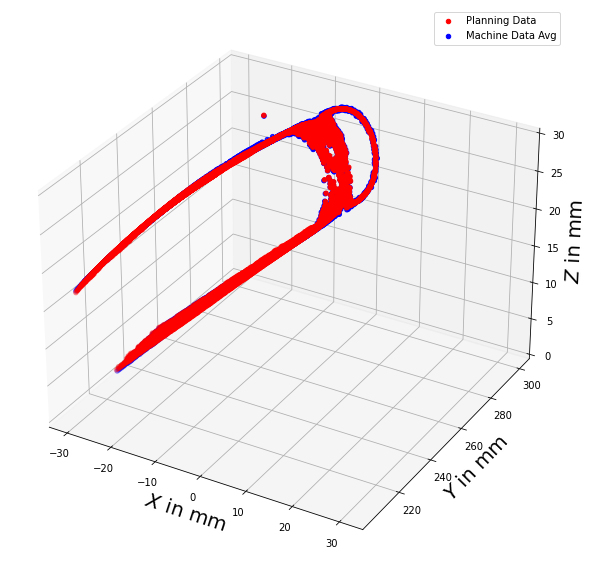

In [49]:
# Plot to show clusters
xdata, ydata, zdata = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

plt.figure(figsize=(10,15))
ax = plt.axes(projection='3d')
ax.set_zlim3d([0,30])
ax.set_xlabel('$X$ in mm', fontsize=20)
ax.set_ylabel('$Y$ in mm', fontsize=20)
ax.set_zlabel('$Z$ in mm', fontsize=20)

for i in np.arange(len(pltlst)):
    xdata[i] = tool_tip_X[pltlst[i]]
    ydata[i] = tool_tip_Y[pltlst[i]]
    zdata[i] = tool_tip_Z[pltlst[i]]

ax.scatter3D(xdata, ydata, zdata, color = 'red',label = 'Planning Data')
ax.legend()

xdata2, ydata2, zdata2 = np.zeros(len(pltlst),),np.zeros(len(pltlst),),np.zeros(len(pltlst),)

for i in np.arange(len(pltlst)):
    xdata2[i] = np.average(X[tuple([lst3[pltlst[i]]])])
    ydata2[i] = np.average(Y[tuple([lst3[pltlst[i]]])])
    zdata2[i] = np.average(Z[tuple([lst3[pltlst[i]]])])

ax.scatter3D(xdata2, ydata2, zdata2, color = 'blue',label = 'Machine Data Avg')
ax.legend()

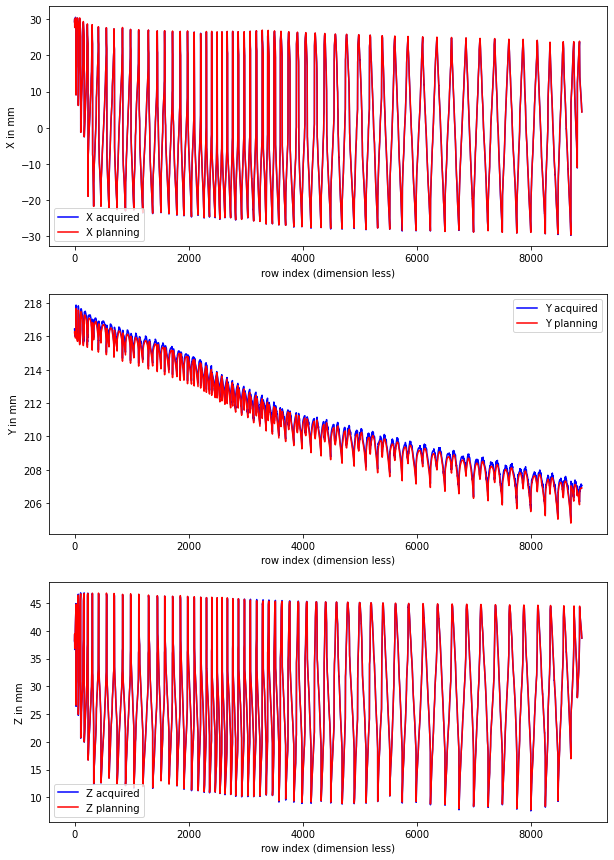

In [51]:
#subplotter(0,xdata.shape[0],xdata2,ydata2,zdata2,xdata,ydata,zdata)
subplotter(0,8900,xdata2,ydata2,zdata2,xdata,ydata,zdata)

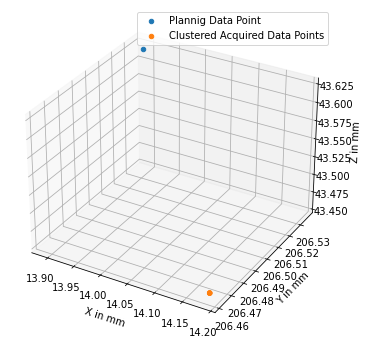

In [632]:
num = -10
xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)

plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')

ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]],label='Plannig Data Point')

for i in np.arange(len(lst3[pltlst[num]])):
    xdata[i] = X[lst3[pltlst[num]]][i]
    ydata[i] = Y[lst3[pltlst[num]]][i]
    zdata[i] = Z[lst3[pltlst[num]]][i]
    
ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
ax.set_xlabel('X in mm', fontsize=10)
ax.set_ylabel('Y in mm', fontsize=10)
ax.set_zlabel('Z in mm', fontsize=10)
plt.legend()

Input two numbers between 0 and 21771 with small difference for plots exaple 10000 then 10010
0


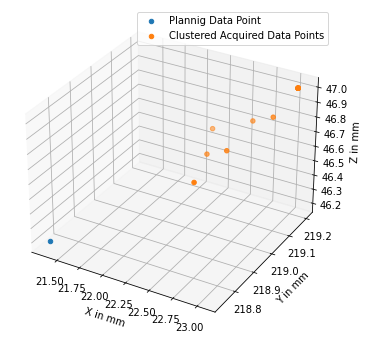

In [633]:
#for num in np.arange(len(pltlst)):
print('Input two numbers between 0 and {} with small difference for plots exaple 10000 then 10010'.format(len(pltlst)))
#lim1 = input()
#lim2 = input()

lim1 = 0
lim2 = 1

for num in np.arange(len(pltlst[int(lim1):int(lim2)])):
    xdata, ydata, zdata = np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),),np.zeros(len(lst3[pltlst[num]]),)
    
    fig = plt.figure(figsize=(6,6))
    print(num)
    ax = plt.axes(projection='3d')

    ax.scatter3D(tool_tip_X[pltlst[num]],tool_tip_Y[pltlst[num]] , tool_tip_Z[pltlst[num]], label='Plannig Data Point')

    for i in np.arange(len(lst3[pltlst[num]])):
        xdata[i] = X[lst3[pltlst[num]]][i]
        ydata[i] = Y[lst3[pltlst[num]]][i]
        zdata[i] = Z[lst3[pltlst[num]]][i]
    
    ax.scatter3D(xdata, ydata, zdata, label = 'Clustered Acquired Data Points')
    ax.set_xlabel('X in mm', fontsize=10)
    ax.set_ylabel('Y in mm', fontsize=10)
    ax.set_zlabel('Z in mm', fontsize=10)
    plt.legend()
    plt.pause(0.1)
   

In [634]:
# for the clusterd points the acquired points are averaged
lst4 = []
for i in np.arange(len(lst3)):
    lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))
    
mean_m = pd.concat(lst4,axis=1).T
mean_m.iloc[-100:-1]

<ipython-input-634-3ecf7367c8c3>:4: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  lst4.append(df_m.iloc[list(lst3[i])].mean(axis=0))


time    MachineX   MachineY    MachineZ   MachineA    MachineC  \
35861  325.720001   -104.2302   -77.5062   -169.2374   -75.6809    347.4168   
35862  321.385002   -104.2857   -77.7523   -169.1062   -75.7318    347.4003   
35863  323.557499  -103.95855  -77.81455   -168.9259   -75.6943    347.4725   
35864         NaN         NaN        NaN         NaN        NaN         NaN   
35865  321.400002   -103.6959   -78.1293   -168.6143   -75.7057     347.529   
35866  325.739998   -103.3325    -78.088   -168.5015   -75.6478    347.6173   
35867  321.404999    -103.417   -78.3213   -168.3784   -75.6932    347.5941   
35868  323.582499  -103.09845   -78.4026    -168.207  -75.65895     347.673   
35869         NaN         NaN        NaN         NaN        NaN         NaN   
35870         NaN         NaN        NaN         NaN        NaN         NaN   
35871  322.295999  -102.60246  -78.87556  -167.71852  -75.64826   347.80244   
35872         NaN         NaN        NaN         NaN        NaN         NaN   
35873  321.440002   -102.3183   -79.1747   -167.4258   -75.6419    347.8835   
35874  325.783749    -101.949   -79.1698   -167.3246   -75.5937    347.9884   
35875  317.110001   -102.1118   -79.6867   -167.0073   -75.6597    347.9527   
35876  325.797501   -101.6006   -79.4845   -167.0176   -75.5793    348.0984   
35877  318.566666 -101.745667 -79.920433    -166.747   -75.6298    348.0705   
35878         NaN         NaN        NaN         NaN        NaN         NaN   
35879  320.032499 -101.426667 -80.122667   -166.5292   -75.6032    348.1793   
35880         NaN         NaN        NaN         NaN        NaN         NaN   
35881   322.56875 -101.052275 -80.298725 -166.327975   -75.5709  348.309125   
35882         NaN         NaN        NaN         NaN        NaN         NaN   
35883  322.367999  -100.79742  -80.59776  -166.07098   -75.5578   348.41622   
35884         NaN         NaN        NaN         NaN        NaN         NaN   
35885  317.177502   -100.7391   -81.1516   -165.6704     -75.57    348.4948   
35886  321.504997   -100.5327   -80.9839   -165.7581   -75.5462    348.5449   
35887  321.522503   -100.3425   -81.2185    -165.565  -75.53345    348.6419   
35888  321.529999   -100.3029   -81.2663   -165.5275   -75.5318    348.6618   
35889  320.670999  -100.16546   -81.5323  -165.32224  -75.52314   348.75374   
35890         NaN         NaN        NaN         NaN        NaN         NaN   
35891  320.109998    -99.9967 -81.816633 -165.101667   -75.5111  348.869367   
35892     321.555    -99.8937   -81.7985   -165.1051   -75.5042    348.9021   
35893  321.566248     -99.744  -82.00205   -164.9437    -75.492   349.00485   
35894  321.567501    -99.7123   -82.0437   -164.9123   -75.4905    349.0257   
35895  325.907497    -99.3427   -82.0713   -164.8613    -75.466    349.1704   
35896    321.5825    -99.5443   -82.2726   -164.7309   -75.4767    349.1518   
35897  317.259998    -99.6589   -82.5983   -164.4928   -75.4752    349.2175   
35898  323.763335    -99.2814  -82.39085   -164.6228  -75.45855    349.2904   
35899         NaN         NaN        NaN         NaN        NaN         NaN   
35900  321.612501    -99.2611 -82.654733   -164.4188   -75.4504    349.3974   
35901         NaN         NaN        NaN         NaN        NaN         NaN   
35902  321.628499   -99.12746  -82.82526  -164.27154    -75.437    349.5286   
35903         NaN         NaN        NaN         NaN        NaN         NaN   
35904  322.510001   -98.93968  -82.96134  -164.14254  -75.42184   349.67938   
35905         NaN         NaN        NaN         NaN        NaN         NaN   
35906  322.277143  -98.833886 -83.096814 -164.007886 -75.408829    349.8147   
35907         NaN         NaN        NaN         NaN        NaN         NaN   
35908  317.337498    -99.0462   -83.2981   -163.8014   -75.3985    349.8984   
35909  321.677502    -98.7405   -83.2305   -163.8584   -75.3944    349.9693   
35910  324.285001   -98.47204    -83.251  -163.80744  -75.38178

In [635]:
# distances are averaged
tcp_avg = [(lambda x: sum(x)/len(x))(item) if len(item)!=0 else np.nan for item in tcp_val]
len(tcp_avg)
#tcp_avg

35961

In [636]:
# Now the final dataframe with plannind data and the corresponding averaged acquired data is obtained 
final_df = pd.concat([df_p,mean_m, pd.DataFrame({'tcp_error':tcp_avg})], axis=1)
final_df = final_df.drop(['Level','Step'],axis=1)
final_df = final_df.dropna()
print(final_df.shape)
final_df.iloc[0:10]

(21771, 69)


Leading angle  Side tilt angle  Surface Contact point X  \
8        0.605350         0.136441                20.230158   
9        0.597177         0.185822                20.229862   
10       0.586565         0.232489                20.229565   
11       0.573636         0.276109                20.229269   
12       0.558518         0.316495                20.228972   
13       0.541344         0.353585                20.228676   
14       0.522242         0.387416                20.228379   
15       0.501340         0.418094                20.228083   
16       0.478759         0.445778                20.227786   
17       0.454614         0.470650                20.227489   

    Surface contact point Y  Surface contact point z  Surface Orietation X  \
8                220.072035                39.789210             -0.152592   
9                220.072062                39.789089             -0.152594   
10               220.072090                39.788968             -0.152597   
11               220.072117                39.788846             -0.152599   
12               220.072145                39.788725             -0.152602   
13               220.072173                39.788604             -0.152604   
14               220.072200                39.788483             -0.152606   
15               220.072228                39.788361             -0.152609   
16               220.072255                39.788240             -0.152611   
17               220.072283                39.788119             -0.152614   

    Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
8               0.816819              0.556347         21.342939   
9               0.816819              0.556346         21.351183   
10              0.816819              0.556346         21.347464   
11              0.816819              0.556345         21.331797   
12              0.816819              0.556345         21.304243   
13              0.816819              0.556344         21.264914   
14              0.816819              0.556344         21.213966   
15              0.816819              0.556343         21.151604   
16              0.816818              0.556343         21.078077   
17              0.816818              0.556343         20.993679   

    Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
8         218.730804         46.195240            0.001198   
9         218.735870         46.005775            0.001198   
10        218.741852         45.816193            0.001198   
11        218.748688         45.627251            0.001198   
12        218.756363         45.439705            0.001198   
13        218.764847         45.254307            0.001198   
14        218.774109         45.071800            0.001198   
15        218.784103         44.892910            0.001198   
16        218.794815         44.718349            0.001198   
17        218.806168         44.548824            0.001198   

    Tool Orientation Y  Tool Orientation Z  \
8             0.999999            0.000856   
9             0.999999            0.000856   
10            0.999999            0.000856   
11            0.999999            0.000856   
12            0.999999            0.000856   
13            0.999999            0.000856   
14            0.999999            0.000856   
15            0.999999            0.000856   
16            0.999999            0.000856   
17            0.999999            0.000856   

    Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
8                                            5.929007                          
9                                            5.929006                          
10                                           5.929005                          
11                                           5.929004                          
12                                           5.929003                          
13                              

In [637]:
final_df['block'] = block
final_df['angle'] = angle

In [638]:
print(final_df.shape)
final_df.iloc[0:10]

(21771, 71)


Leading angle  Side tilt angle  Surface Contact point X  \
8        0.605350         0.136441                20.230158   
9        0.597177         0.185822                20.229862   
10       0.586565         0.232489                20.229565   
11       0.573636         0.276109                20.229269   
12       0.558518         0.316495                20.228972   
13       0.541344         0.353585                20.228676   
14       0.522242         0.387416                20.228379   
15       0.501340         0.418094                20.228083   
16       0.478759         0.445778                20.227786   
17       0.454614         0.470650                20.227489   

    Surface contact point Y  Surface contact point z  Surface Orietation X  \
8                220.072035                39.789210             -0.152592   
9                220.072062                39.789089             -0.152594   
10               220.072090                39.788968             -0.152597   
11               220.072117                39.788846             -0.152599   
12               220.072145                39.788725             -0.152602   
13               220.072173                39.788604             -0.152604   
14               220.072200                39.788483             -0.152606   
15               220.072228                39.788361             -0.152609   
16               220.072255                39.788240             -0.152611   
17               220.072283                39.788119             -0.152614   

    Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
8               0.816819              0.556347         21.342939   
9               0.816819              0.556346         21.351183   
10              0.816819              0.556346         21.347464   
11              0.816819              0.556345         21.331797   
12              0.816819              0.556345         21.304243   
13              0.816819              0.556344         21.264914   
14              0.816819              0.556344         21.213966   
15              0.816819              0.556343         21.151604   
16              0.816818              0.556343         21.078077   
17              0.816818              0.556343         20.993679   

    Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
8         218.730804         46.195240            0.001198   
9         218.735870         46.005775            0.001198   
10        218.741852         45.816193            0.001198   
11        218.748688         45.627251            0.001198   
12        218.756363         45.439705            0.001198   
13        218.764847         45.254307            0.001198   
14        218.774109         45.071800            0.001198   
15        218.784103         44.892910            0.001198   
16        218.794815         44.718349            0.001198   
17        218.806168         44.548824            0.001198   

    Tool Orientation Y  Tool Orientation Z  \
8             0.999999            0.000856   
9             0.999999            0.000856   
10            0.999999            0.000856   
11            0.999999            0.000856   
12            0.999999            0.000856   
13            0.999999            0.000856   
14            0.999999            0.000856   
15            0.999999            0.000856   
16            0.999999            0.000856   
17            0.999999            0.000856   

    Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
8                                            5.929007                          
9                                            5.929006                          
10                                           5.929005                          
11                                           5.929004                          
12                                           5.929003                          
13                              

In [639]:
final_df = final_df.iloc[int(final_df.shape[0]*0.05):-int(final_df.shape[0]*0.05),:]

In [640]:
print(final_df.shape)
final_df.iloc[0:10]

(19595, 71)


Leading angle  Side tilt angle  Surface Contact point X  \
2612      -0.046457         0.936221                25.567235   
2614      -0.035958         0.937537                25.570671   
2616      -0.026060         0.938421                25.575944   
2618      -0.017839         0.938866                25.577730   
2620       0.006823         0.938831                25.579916   
2622       0.003928         0.938373                25.580361   
2624       0.017142         0.937401                25.578973   
2626       0.026149         0.935882                25.578973   
2628       0.036207         0.933949                25.575912   
2629       0.042680         0.932776                25.574731   

      Surface contact point Y  Surface contact point z  Surface Orietation X  \
2612               219.516265                41.464655              0.805318   
2614               219.515785                41.477781              0.820696   
2616               219.515178                41.501550              0.832201   
2618               219.515052                41.511133              0.840626   
2620               219.514703                41.532935              0.845171   
2622               219.514748                41.553610              0.846230   
2624               219.514904                41.572900              0.843715   
2626               219.514904                41.572900              0.837161   
2628               219.515187                41.590664              0.827304   
2629               219.515362                41.595035              0.820877   

      Surface Orietation Y  Surface Orietation Z  Tool Tip Point X  \
2612              0.538555             -0.247832         29.975561   
2614              0.536413             -0.196770         30.071505   
2616              0.534778             -0.146470         30.146114   
2618              0.533563             -0.093050         30.198856   
2620              0.532908             -0.041167         30.228802   
2622              0.532702              0.011116         30.236225   
2624              0.533014              0.063567         30.220451   
2626              0.533879              0.118888         30.181906   
2628              0.535210              0.170638         30.120630   
2629              0.536071              0.196946         30.081354   

      Tool Tip Point Y  Tool Tip Point Z  Tool Orientation X  \
2612        216.763550         39.938759            0.070792   
2614        216.750275         40.251606            0.070760   
2616        216.739883         40.570351            0.070711   
2618        216.732498         40.893467            0.070645   
2620        216.728241         41.219433            0.070561   
2622        216.727112         41.546539            0.070460   
2624        216.729187         41.873158            0.070342   
2626        216.734406         42.197624            0.070208   
2628        216.742767         42.518360            0.070057   
2629        216.748123         42.676785            0.069976   

      Tool Orientation Y  Tool Orientation Z  \
2612            0.997470            0.006424   
2614            0.997465            0.007543   
2616            0.997459            0.008694   
2618            0.997453            0.009871   
2620            0.997446            0.011074   
2622            0.997439            0.012297   
2624            0.997431            0.013539   
2626            0.997423            0.014796   
2628            0.997414            0.016065   
2629            0.997409            0.016703   

      Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
2612                                           6.033303                          
2614                                           6.030347                          
2616                                           6.023650                          
2618                                           6.020969                     

### Using Combined dataset Peaks Elimination:
Inspite of the average, there are some high impuse peaks observed in the data (Run the visualiation.ipnby), these must be removed to obtain a flawless, reliable dataset. Using machine data from newly created combined dataset same forward transformation is performed as discribled above. by observing the data, it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) one in positive direction and othes in negetive direction, so for robostness both are considered. At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end, so especially for the positive direction they are intentionally not removed. if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks (given by count), it is assumed as plateu and 100 datapoint sare removed. This is a reasonable compromise in accuracy for significant speedup

<img src="images/peak_eli.png">

### Visulaization of outliers peaks

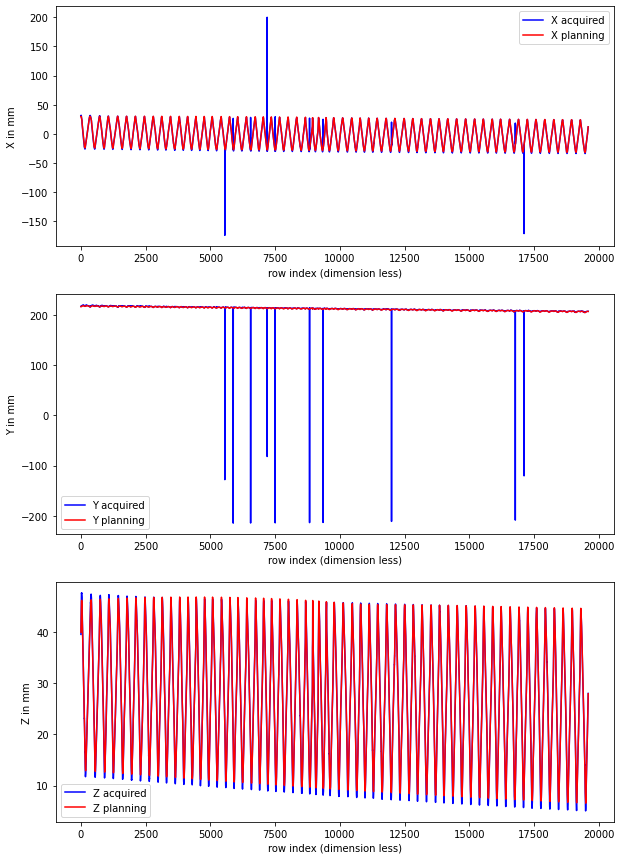

In [641]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]
Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

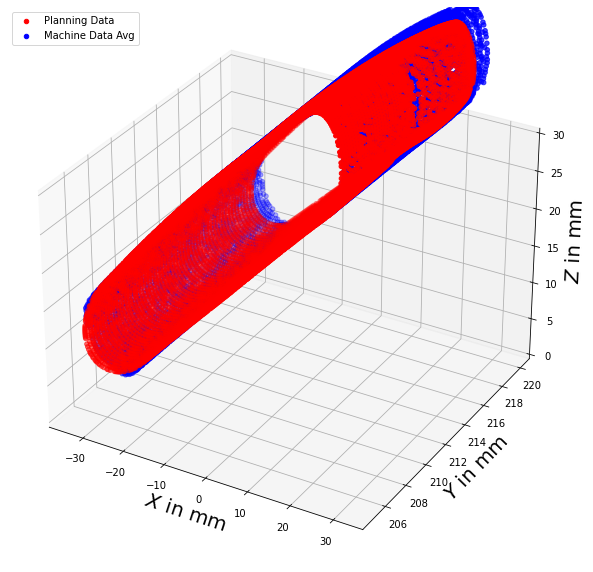

In [552]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [642]:
def remove_peaks(final_df, compensation_values_df):
    x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
    y_final = final_df['MachineY'].copy(deep=True)
    z_final = final_df['MachineZ'].copy(deep=True)
    a_final = final_df['MachineA'].copy(deep=True)
    c_final = final_df['MachineC'].copy(deep=True)

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype = np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype = np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final
    
    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
    size3_final = x_final.shape[0]
    conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

    # prininting the compensation error values
    df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
    df_obj3_final.head(5)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
    df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    # Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
    machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

    x_out_final = machine_points_xyz_final[0,0,:]
    y_out_final = machine_points_xyz_final[1,0,:]
    z_out_final = machine_points_xyz_final[2,0,:]

    a_out_final = machine_direction_ac_final[0,0,:]
    c_out_final = machine_direction_ac_final[1,0,:]

    conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
    df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

    conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
    dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
    #subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset
    
    return Y_final, final_df

In [643]:
# Peak removal: by observing the data,
# it can be seen that the using just one of the components (in this case Y) all the outlers can be eliminated. 
count = 0
col = final_df.columns
while True:
    Y_final, final_df = remove_peaks(final_df,compensation_values_df)
    # Two types of spikes are typicalled observed (check visualizaion by runnung  vizualization.ipnyb) 
    # one in positive direction and othes in negetive direction, so for robostness both are considered. 
    # At the same time, it is not wise to remove the original expected trajectory of the tool path in begining and the end,
    # so especially for the positive direction they are intentionally not removed 
    print(-(np.mean(Y_final)-7*np.std(Y_final)), np.mean(Y_final), np.std(Y_final),(np.mean(Y_final)+7*np.std(Y_final)))
    peaks1, _ = find_peaks(-Y_final, height=(-(np.mean(Y_final)-7*np.std(Y_final)),None))
    #peaks2,_ = find_peaks(Y_final[0:-1000], height=(240,None))
    peaks2,_ = find_peaks(Y_final, height=((np.mean(Y_final)+7*np.std(Y_final)),None))
    peaks = list(peaks1) + list(peaks2)
    print(peaks)
    
    if(len(peaks)==0):
        break
        
    # if each peak on a plateu has to be removed its very expensive, so if two neighbous are consicutively classifies as peaks 
    # (given by count), it is assumed as plateu and 100 datapoints are removed.
    # This is a reasonable compromise in accuracy for significant speedup
        
    #elif(len(peaks)==1 and abs(Y_final[peaks[0]] - Y_final[peaks[0]+20] )<=0.3):
    elif(len(peaks)==1 and count>2 and peaks[-1]+100<final_df.shape[0]):
        arr = final_df.to_numpy()
        arr = np.delete(arr, np.arange(peaks[0],peaks[0]+100), 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = 0
        
    elif(len(peaks)==1 and count>2 and (final_df.shape[0]-100<peaks[-1]<final_df.shape[0])):
        arr = final_df.to_numpy()
        arr = np.delete(arr, np.arange(peaks[0],peaks[0]+(final_df.shape[0]-peaks[-1])), 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = 0
        
    else:
        arr = final_df.to_numpy()
        arr = np.delete(arr,peaks, 0)
        final_df = pd.DataFrame(arr,columns=col)
        count = count+1
        

-141.95443339596136 212.53422636647088 10.082827567215643 283.1140193369804
[5558, 5882, 6554, 7193, 7504, 8831, 9353, 11997, 16778, 17117]
-180.59650557204935 212.7355747769272 4.591295600696835 244.87464398180504
[8825]
-188.7036649454344 212.7573346431334 3.4362385282427104 236.81100434083237
[]


In [644]:
final_df.shape

(19584, 71)

### Visulaiztion of effect of removing peaks

19584


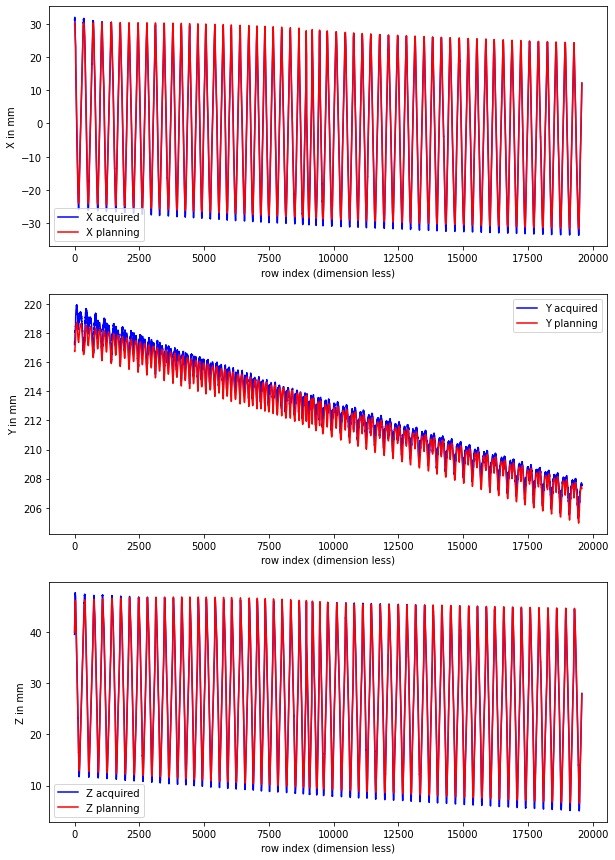

In [656]:
x_final = final_df['MachineX'].copy(deep=True)                 # using machine data from newly created combined dataset
y_final = final_df['MachineY'].copy(deep=True)
z_final = final_df['MachineZ'].copy(deep=True)
a_final = final_df['MachineA'].copy(deep=True)
c_final = final_df['MachineC'].copy(deep=True)

size1_final = x_final.shape[0]
print(size1_final)

# converting pandas series to numpy array
x_final = x_final.to_numpy()
y_final = y_final.to_numpy()
z_final = z_final.to_numpy()
a_final = a_final.to_numpy(dtype =  np.float64)
a_final = np.deg2rad(a_final)
c_final = c_final.to_numpy(dtype =  np.float64)
c_final = np.deg2rad(c_final)

tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()
    
X_inv_final = tool_tip_X_final
Y_inv_final = tool_tip_Y_final
Z_inv_final = tool_tip_Z_final
    
#compensation_values
compensation_values = compensation_values_df.to_numpy()

# Within each cube we have ranges defined in x,y,z for the machine position

x_range = np.arange(-200,201,100)
y_range = np.arange(-300,301,150)
z_range = np.arange(-500,1,50)

obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

# Caclculation of compensation error values based on machine positions obtained through inverse transformation
deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  
size3_final = x_final.shape[0]
conc3_final = np.concatenate((deltaX1_final.reshape(size3_final,1),deltaY1_final.reshape(size3_final,1),deltaZ1_final.reshape(size3_final,1),deltaI1_final.reshape(size3_final,1),deltaJ1_final.reshape(size3_final,1),deltaK1_final.reshape(size3_final,1)),axis=1)

# prininting the compensation error values
df_obj3_final = pd.DataFrame(conc3_final, columns=['deltaX1 final','deltaY1 final','deltaZ1 final','deltaI1 final','deltaJ1 final','deltaK1 final'])
df_obj3_final.head(5)  

x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
y_compensated_final = y_final + deltaY1_final*10**-3
z_compensated_final = z_final + deltaZ1_final*10**-3

conc4_final = np.concatenate((x_compensated_final.reshape(size3_final,1),y_compensated_final.reshape(size3_final,1),z_compensated_final.reshape(size3_final,1)),axis=1)
df_obj4_final = pd.DataFrame(conc4_final, columns=['x_compensated final','y_compensated final','z_compensated final'])

obj_final = transformation.Transformation(size1_final,angle)
# Forward Transformation fuction:
# Input : Machine points in machine coordinate system
# Output: returns too tip points and orientation in workpiece coordinate system
tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

X_final = tool_position_workpiece_CS_final[0,0,:]
Y_final = tool_position_workpiece_CS_final[1,0,:]

Z_final = tool_position_workpiece_CS_final[2,0,:]

I_final = tool_orientation_workpiece_CS_final[0,0,:]
J_final = tool_orientation_workpiece_CS_final[1,0,:]
K_final = tool_orientation_workpiece_CS_final[2,0,:]

# Verification the correctness of code, i.e on applying reverse transformation on the forward transformation we should get same values
machine_points_xyz_final, machine_direction_ac_final = obj_final.backward(X_final,Y_final,Z_final,I_final,J_final,K_final)

x_out_final = machine_points_xyz_final[0,0,:]
y_out_final = machine_points_xyz_final[1,0,:]
z_out_final = machine_points_xyz_final[2,0,:]

a_out_final = machine_direction_ac_final[0,0,:]
c_out_final = machine_direction_ac_final[1,0,:]

conc1_final = np.concatenate((x_final.reshape(size1_final,1),x_out_final.reshape(size1_final,1),y_final.reshape(size1_final,1),y_out_final.reshape(size1_final,1),z_final.reshape(size1_final,1),z_out_final.reshape(size1_final,1),a_final.reshape(size1_final,1),a_out_final.reshape(size1_final,1),c_final.reshape(size1_final,1),c_out_final.reshape(size1_final,1)),axis=1)
df_obj1_final = pd.DataFrame(conc1_final, columns=['x final','x_out final','y final','y_out final','z final','z_out final','a final','a_out final','c final','c_out'])

conc11_final = np.concatenate((x_final.reshape(size1_final,1),y_final.reshape(size1_final,1),z_final.reshape(size1_final,1),a_final.reshape(size1_final,1),c_final.reshape(size1_final,1),X_final.reshape(size1_final,1),Y_final.reshape(size1_final,1),Z_final.reshape(size1_final,1),I_final.reshape(size1_final,1),J_final.reshape(size1_final,1),K_final.reshape(size1_final,1)),axis=1)
dfout11_final = pd.DataFrame(conc11_final, columns=['x final','y final','z final','a final','c final','X final','Y final','Z final','I final','J final','K final'])
    
subplotter(0,final_df.shape[0],X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)   # using combined dataset

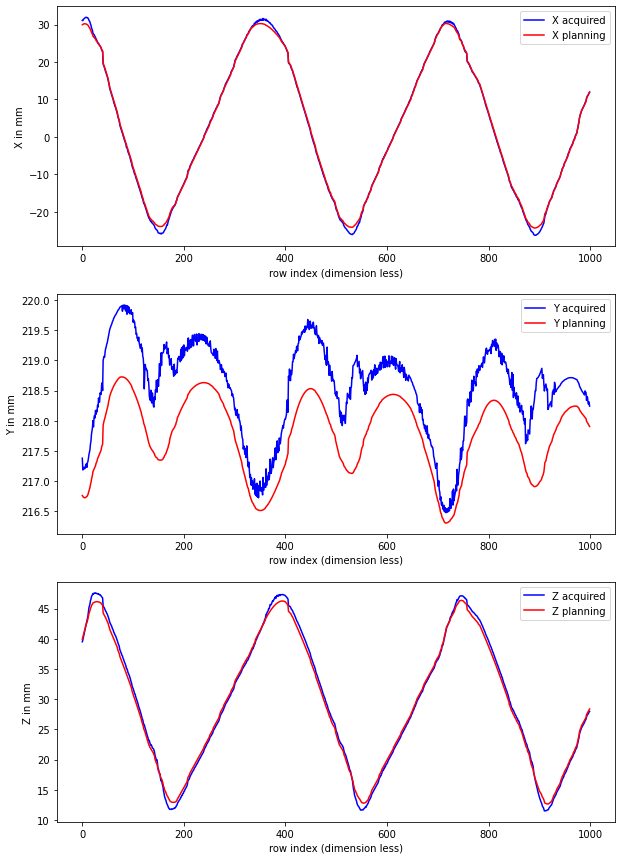

In [658]:
subplotter(0,1000,X_final,Y_final,Z_final,X_inv_final,Y_inv_final,Z_inv_final)

In [685]:
def shift(final_df, compensation_values_df):
    x_final = final_df['MachineX']                 # using machine data from newly created combined dataset
    y_final = final_df['MachineY']
    z_final = final_df['MachineZ']
    a_final = final_df['MachineA']
    c_final = final_df['MachineC']

    size1_final = x_final.shape[0]

    # converting pandas series to numpy array
    x_final = x_final.to_numpy()
    y_final = y_final.to_numpy()
    z_final = z_final.to_numpy()
    a_final = a_final.to_numpy(dtype =  np.float64)
    a_final = np.deg2rad(a_final)
    c_final = c_final.to_numpy(dtype =  np.float64)
    c_final = np.deg2rad(c_final)

    tool_tip_X_final = final_df['Tool Tip Point X'].to_numpy()        # using newly created combined dataset
    tool_tip_Y_final = final_df['Tool Tip Point Y'].to_numpy()
    tool_tip_Z_final = final_df['Tool Tip Point Z'].to_numpy()

    X_inv_final = tool_tip_X_final
    Y_inv_final = tool_tip_Y_final
    Z_inv_final = tool_tip_Z_final

    #compensation_values
    compensation_values = compensation_values_df.to_numpy()

    # Within each cube we have ranges defined in x,y,z for the machine position

    x_range = np.arange(-200,201,100)
    y_range = np.arange(-300,301,150)
    z_range = np.arange(-500,1,50)

    obj3_final = compensation.Compensation(compensation_values,x_range,y_range,z_range)

    # Caclculation of compensation error values based on machine positions obtained through inverse transformation
    deltaX1_final, deltaY1_final, deltaZ1_final,deltaI1_final,deltaJ1_final,deltaK1_final = obj3_final.calculate(x_final,y_final,z_final)  

    x_compensated_final = x_final + deltaX1_final*10**-3    # since given compensation is to be converted from microns to mm (10**-6 x 10**3 = 10**-3)
    y_compensated_final = y_final + deltaY1_final*10**-3
    z_compensated_final = z_final + deltaZ1_final*10**-3

    obj_final = transformation.Transformation(size1_final,angle)
    # Forward Transformation fuction:
    # Input : Machine points in machine coordinate system
    # Output: returns too tip points and orientation in workpiece coordinate system
    tool_position_workpiece_CS_final, tool_orientation_workpiece_CS_final = obj_final.forward(x_compensated_final,y_compensated_final,z_compensated_final,a_final,c_final)

    X_final = tool_position_workpiece_CS_final[0,0,:]
    Y_final = tool_position_workpiece_CS_final[1,0,:]
    Z_final = tool_position_workpiece_CS_final[2,0,:]

    I_final = tool_orientation_workpiece_CS_final[0,0,:]
    J_final = tool_orientation_workpiece_CS_final[1,0,:]
    K_final = tool_orientation_workpiece_CS_final[2,0,:]

    #Shifting the data 
    div = 20
    length = Y_final.shape[0]
    chunck_len = int(length/div)
    
    for i in np.arange(0,div):
        if(i != div-1):
            diff = Y_final[i*chunck_len:(i+1)*chunck_len] - Y_inv_final[i*chunck_len:(i+1)*chunck_len]
            Y_final[i*chunck_len:(i+1)*chunck_len] = Y_final[i*chunck_len:(i+1)*chunck_len] - np.mean(diff)

        else:
            diff = Y_final[i*chunck_len:length] - Y_inv_final[i*chunck_len:length]
            Y_final[i*chunck_len:length] = Y_final[i*chunck_len:length] - np.mean(diff)

        
    return X_final,Y_final,Z_final



In [686]:
X_mc, Y_mc, Z_mc = shift(final_df,compensation_values_df)

In [687]:
final_df['Tool Tip Point Machine X'] = X_mc
final_df['Tool Tip Point Machine Y'] = Y_mc
final_df['Tool Tip Point Machine Z'] = Z_mc

In [688]:
print(final_df.shape)
final_df.iloc[0:10]

(19584, 74)


Leading angle Side tilt angle Surface Contact point X  \
0     -0.046457        0.936221               25.567235   
1     -0.035958        0.937537               25.570671   
2      -0.02606        0.938421               25.575944   
3     -0.017839        0.938866                25.57773   
4      0.006823        0.938831               25.579916   
5      0.003928        0.938373               25.580361   
6      0.017142        0.937401               25.578973   
7      0.026149        0.935882               25.578973   
8      0.036207        0.933949               25.575912   
9       0.04268        0.932776               25.574731   

  Surface contact point Y Surface contact point z Surface Orietation X  \
0              219.516265               41.464655             0.805318   
1              219.515785               41.477781             0.820696   
2              219.515178                41.50155             0.832201   
3              219.515052               41.511133             0.840626   
4              219.514703               41.532935             0.845171   
5              219.514748                41.55361              0.84623   
6              219.514904                 41.5729             0.843715   
7              219.514904                 41.5729             0.837161   
8              219.515187               41.590664             0.827304   
9              219.515362               41.595035             0.820877   

  Surface Orietation Y Surface Orietation Z Tool Tip Point X Tool Tip Point Y  \
0             0.538555            -0.247832        29.975561        216.76355   
1             0.536413             -0.19677        30.071505       216.750275   
2             0.534778             -0.14647        30.146114       216.739883   
3             0.533563             -0.09305        30.198856       216.732498   
4             0.532908            -0.041167        30.228802       216.728241   
5             0.532702             0.011116        30.236225       216.727112   
6             0.533014             0.063567        30.220451       216.729187   
7             0.533879             0.118888        30.181906       216.734406   
8              0.53521             0.170638         30.12063       216.742767   
9             0.536071             0.196946        30.081354       216.748123   

  Tool Tip Point Z Tool Orientation X Tool Orientation Y Tool Orientation Z  \
0        39.938759           0.070792            0.99747           0.006424   
1        40.251606            0.07076           0.997465           0.007543   
2        40.570351           0.070711           0.997459           0.008694   
3        40.893467           0.070645           0.997453           0.009871   
4        41.219433           0.070561           0.997446           0.011074   
5        41.546539            0.07046           0.997439           0.012297   
6        41.873158           0.070342           0.997431           0.013539   
7        42.197624           0.070208           0.997423           0.014796   
8         42.51836           0.070057           0.997414           0.016065   
9        42.676785           0.069976           0.997409           0.016703   

  Closes Point Distance (Surface Contact Point - Acquired TCP 1030 blade0)  \
0                                           6.033303                         
1                                           6.030347                         
2                                            6.02365                         
3                                           6.020969                         
4                                           6.013478                         
5                                           6.005956                         
6                                           5.998682                         
7                                           5.998682                         
8                                           5.991948                     

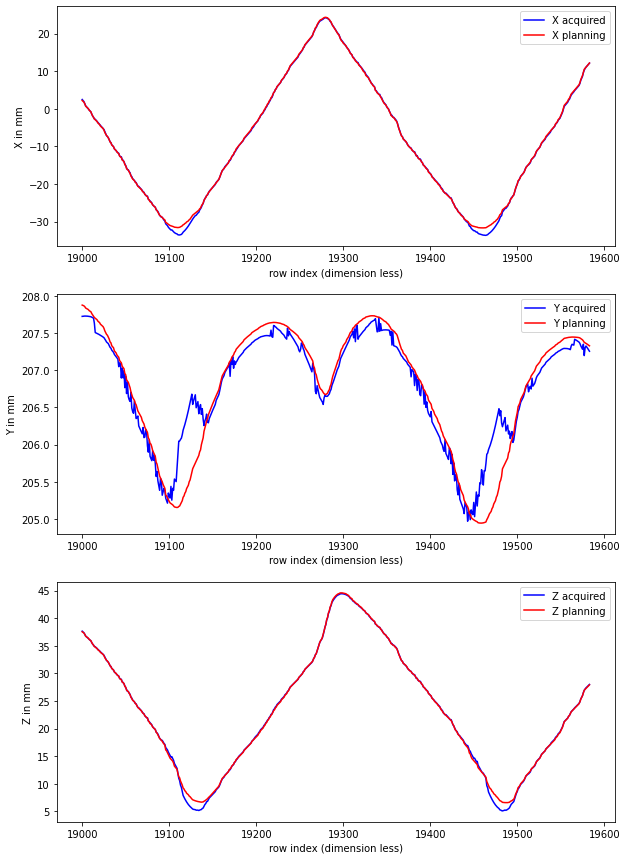

In [694]:
subplotter(19000,final_df.shape[0],final_df['Tool Tip Point Machine X'],final_df['Tool Tip Point Machine Y'],final_df['Tool Tip Point Machine Z'],final_df['Tool Tip Point X'],final_df['Tool Tip Point Y'],final_df['Tool Tip Point Z'])

0.5390354471599977


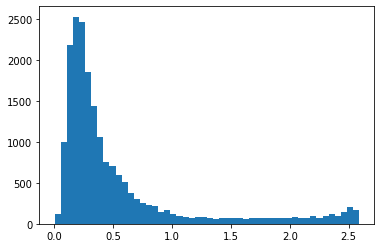

In [726]:
#tool point deviation

tool_point_deviation = np.sqrt(((final_df['Tool Tip Point Machine X'] - final_df['Tool Tip Point X'])**2 + (final_df['Tool Tip Point Machine Y'] - final_df['Tool Tip Point Y'])**2 + (final_df['Tool Tip Point Machine Z'] - final_df['Tool Tip Point Z'])**2).to_numpy(dtype=np.float64))
print(np.mean(tool_point_deviation))
plt.hist(tool_point_deviation, bins=50)
plt.show()

In [721]:
final_df['Tool Point Deviation'] = tool_point_deviation

In [725]:
final_df.iloc[10000:10020]

Leading angle Side tilt angle Surface Contact point X  \
10000      0.694917        1.458942               -7.171475   
10001      0.702754        1.456845               -6.556316   
10002      0.704933        1.455334               -6.248121   
10003      0.708872        1.454278               -5.941017   
10004      0.714645        1.451582               -5.325674   
10005      0.721918        1.449245               -4.710397   
10006      0.724454        1.447781               -4.402698   
10007      0.725942        1.446028               -4.094946   
10008      0.728961        1.444559               -3.783296   
10009        0.7364        1.440173               -2.864224   
10010      0.739829        1.438825               -2.553158   
10011      0.742852        1.437586               -2.248977   
10012      0.744256        1.435773               -1.941274   
10013      0.750577        1.433168               -1.326078   
10014      0.751794        1.431293               -1.018424   
10015      0.753107        1.429496               -0.712269   
10016      0.752097        1.427012               -0.406875   
10017      0.754267        1.425297               -0.095553   
10018      0.757666        1.424096                0.211918   
10019      0.758905        1.422222                0.519495   

      Surface contact point Y Surface contact point z Surface Orietation X  \
10000              218.629366               23.477503             0.476783   
10001              218.660066               23.811791             0.476925   
10002              218.672052               23.979206             0.476893   
10003              218.686491               24.146049             0.477045   
10004              218.710638               24.480296             0.477158   
10005              218.735393               24.814485             0.477283   
10006              218.745399               24.981613             0.477333   
10007              218.753266                25.14878             0.477373   
10008              218.761992               25.318054             0.476764   
10009              218.787523               25.817364             0.477568   
10010              218.795298               25.986368             0.477049   
10011              218.804128               26.151653             0.477673   
10012              218.808639               26.318906             0.477708   
10013              218.822452                26.65329             0.477805   
10014              218.825224                 26.8206             0.477838   
10015              218.828199               26.987116             0.478119   
10016              218.826709               27.153299             0.478523   
10017              218.828463               27.322694             0.477936   
10018              218.833376               27.489984             0.477985   
10019               218.83374                27.65742             0.478014   

      Surface Orietation Y Surface Orietation Z Tool Tip Point X  \
10000             0.018036            -0.878836        -4.934375   
10001             0.014548            -0.878824        -4.362189   
10002             0.013256            -0.878861        -4.076332   
10003             0.011484            -0.878804        -3.790619   
10004             0.008509            -0.878776        -3.219621   
10005             0.005145            -0.878734        -2.649145   
10006             0.003749            -0.878714        -2.364097   
10007             0.002638            -0.878697        -2.079171   
10008             0.001311            -0.879031        -1.794345   
10009            -0.002995             -0.87859        -0.940499   
10010            -0.004453            -0.878866        -0.656065   
10011            -0.006158            -0.878516        -0.371719   
10012            -0.007216            -0.878489        -0.087454   
10013            -0.010347            -0.878405         0.480864   
10014            -0.011

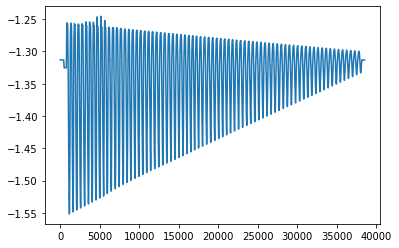

In [459]:
plt.plot(a)

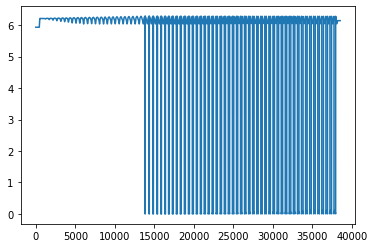

In [460]:
plt.plot(c)

Text(0.5, 1.0, 'TCP Error plot')

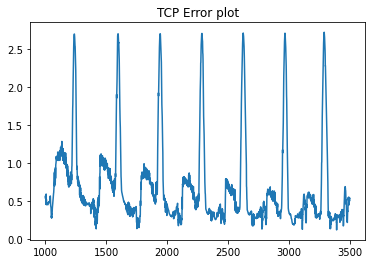

In [461]:
plt.plot((final_df['tcp_error']).iloc[1000:3500])
plt.title('TCP Error plot')

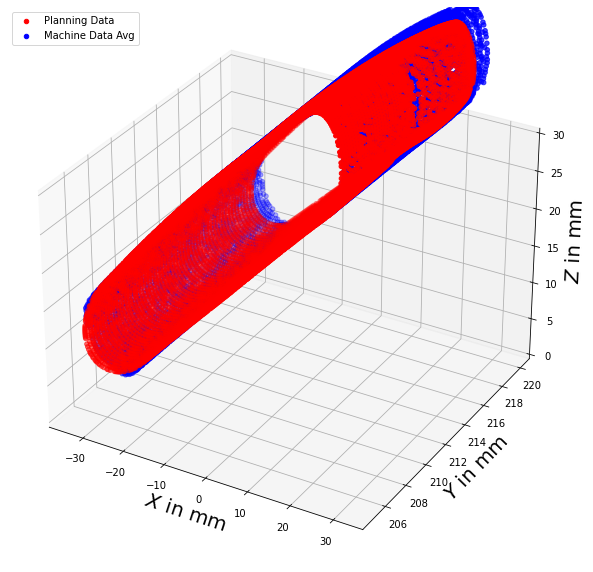

In [462]:
plt.figure(figsize=(10,15))
ax1 = plt.axes(projection='3d')
ax1.set_zlim3d([0,30])

ax1.set_xlabel('$X$ in mm', fontsize=20)
ax1.set_ylabel('$Y$ in mm', fontsize=20)
ax1.set_zlabel('$Z$ in mm', fontsize=20)

ax1.scatter3D(X_inv_final, Y_inv_final, Z_inv_final, color = 'red',label = 'Planning Data')
ax1.legend()

ax1.scatter3D(X_final, Y_final, Z_final, color = 'blue',label = 'Machine Data Avg')
ax1.legend()

In [468]:
mean = final_df['tcp_error'].mean()
mean

0.6223451036285506

In [469]:
median = final_df['tcp_error'].median()
median

0.33680819855975225

In [470]:
minimum = final_df['tcp_error'].min()
minimum

0.08460864350350288

In [471]:
maximum = final_df['tcp_error'].max()  
maximum

2.740941680439054

In [ ]:
final_df = final_df.iloc[0:21500]

In [ ]:
# saving data 
final_df.to_excel(str(dir_final_save)+'finaldf_forward_with_compensation'+str(block)+'__'+str(angle)+'.xlsx') 